# Conditional Generative Adversarial Networks  (Conditional GANs)

이름: 최정우

학번: M2018076

Colab link: http://bit.ly/2Vj0mqg

---

MNIST 데이터셋을 이용해 conditional generative adversarial networks (Conditional GAN) 기반 generative model을 구축한다.


단, 과제는 다음 조건을 만족해야 한다.

- 조건(condition)은 데이터의 label로 부여한다.

- noise z에 대한 확률분포 p(z)가 다차원 normal distribution을 따른다고 가정한다.

- 딥네트워크는 두 가지 구조로 설계해 본다.
  + 생성 네트웍(G)와 판별 네트웍(D)를 모두 fully connected layer(케라스 Dense 레이어)로 구성한다. 
  + 생성 네트웍(G)와 판별 네트웍(D)를 모두 convolutional layer(케라스의 Conv2D, Conv2DTranspose)로 구성한다.

---

다음을 확인하는 리포트를 Colab 노트북을 이용해 작성한다.

- 조건을 Conditional GAN의 생성 네트웍(G)와 판별 네트웍(D)에 어떻게 텐서 형태를 취해 입력으로 줘야하는지 명시하고, 이에 대해 논의한다.

- 학습과정에서 생성 네트웍(G)와 판별 네트웍(D)의 loss 값의 변화를 가시화 한다.

- 조건별로 noise z에 대해 생성 네트웍이 손글씨 숫자 이미지가 만들어내는지 확인한다. 의미있게 만들어진 이미지는 어떤 특징을 가지고 있는지 논의한다.

- (* 이것 이외에도 의미있는 실험들을 스스로 생각하고 수행해 본다)



## 목차


1. Dependencies & Prerequisites
2. MNIST 데이터셋 불러오기
3. Conditional GAN based on Dense layer
4. Conditional GAN based on Convolutional layer


## 1. Dependencies & Prerequisites

###Install Prerequisites

Tensorflow probability를 사용하기위해서는 nightly 버전의 tensorflow를 설치해야한다.

Weight를 저장 및 불러오기에 사용하기위해 PyDrive 를 설치한다.

In [0]:
!pip install -q --upgrade tf-nightly-gpu-2.0-preview
!pip install -q tfp-nightly
!pip3 install h5py pyyaml 
!pip install -U -q PyDrive
!pip install imageio

    100% |████████████████████████████████| 345.7MB 62kB/s 
    100% |████████████████████████████████| 61kB 24.9MB/s 
    100% |████████████████████████████████| 430kB 9.0MB/s 
    100% |████████████████████████████████| 3.1MB 7.9MB/s 
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
    100% |████████████████████████████████| 931kB 20.3MB/s 
    100% |████████████████████████████████| 993kB 24.6MB/s 


###Import

사용할 라이브러리를 import 하고, 자주사용되는 라이브러리는 약칭으로 지정한다.


In [0]:
import sys
import os
import glob
import PIL
import imageio
from IPython import display
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf                       # 텐서플로우 임포트
import tensorflow_probability as tfp

from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트

tfd = tfp.distributions

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Tensorflow: ", tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print("Keras: ", tf.keras.__version__)  # 케라스 버전을 확인한다.

print("Tensorflow Probability: ", tfp.__version__)       # TFP 버젼을 확인한다.

Python: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
Numpy: 1.16.2
Tensorflow:  2.0.0-dev20190424
Keras:  2.2.4-tf
Tensorflow Probability:  0.7.0-dev20190424


###구글 드라이브 연결
Colab의 현재 세션과 구글 드라이브를 연결하기 위해서 사용한다.

Weight를 저장하거나 저장된 weight를 불러오는데 필요하다.

사용방법: 코드 실행시 오른쪽 GDrive_Auth 아래에 생성되는 링크를 타고 구글 로그인을 한뒤에 권한을 수락하고 보이는 코드를 복사하여 링크 아래의 사각형에 붙여넣은 후 엔터를 친다.

In [0]:
#@title GDrive_Auth { vertical-output: true, display-mode: "both" }

# Colab의 현재 세션과 구글 드라이브를 연결하기 위해서 사용한다.
# weight를 저장하거나 불러오는데 필요하다.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 2. MNIST 데이터셋 불러오기

Keras 라이브러리를 이용하여 MNIST 데이터셋을 불러오고, 데이터 값이 0과 1사이를 가지도록 정규화후 이진화 한다.

Training dataset 과 Test dataset 을 합친 데이터셋을 이용하여 학습을 진행한다.


In [0]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
total_images = np.append(train_images, test_images, axis=0)
total_labels = np.append(train_labels, test_labels, axis=0)

# Normalize the images to [-1, 1] (* tanh을 거친 값과 비교해야 하기 때문...)
total_images = (total_images - 127.5) / 127.5 

# tensorflow probablity layer가 float32를 입력을 받기 때문에 float64를 float32로 캐스팅
total_images = total_images.astype('float32')


# 데이터가 [-1, 1] 사이로 정규화 되었는지 확인
print(np.amin(total_images), np.amax(total_images))

print(total_images.shape)
print(total_labels.shape)
print(total_images[0].shape)
print(total_images[0][0][0].dtype)
print(total_labels[0].dtype)

11493376/11490434 [==============================] - 0s 0us/step
-1.0 1.0
(70000, 28, 28)
(70000,)
(28, 28)
float32
uint8


### Onehot encoding
훈련시 사용할 condition을 Onehot encoding 하여 사용한다.

Onehot encoding 은 전체 클래스 사이즈의 0벡터를 선언하여 그중에 해당클래스의 인덱스의 값을 1로 변환시켜주는 인코딩 방식이다. tf.keras.utils.to_categorical 을 이용하면 이를 쉽게 변환할수 있다.

인코딩된 조건은 Generator model의 입력 노이즈에 concatenate 하여 모델에 주어진다.

In [0]:
num_classes = 10

total_labels_onehots = tf.keras.utils.to_categorical(total_labels, num_classes)

# 데이터 변환 확인
print(total_labels_onehots.shape)


(70000, 10)


####Tensor 변환(Numpy)

이미지의 사이즈가 2 by 2라고 할때, 주어진 Tensor를  repeat, reshape, transpose 의 방식을 거쳐서 이미지의 픽셀당 조건을 주는 방식으로 변경시킬 수 있다. 

Generator model를 통해서 생성된 이미지를 discriminator 가 조건에 부합하는 이미지인지 판별 해야한다. 이때 이미지에 Tensor로 확장된 조건을 Concatenate 하여 입력한다.

In [0]:
k = np.array([[1,2,3],[4,5,6],[7,8,9]])
y = np.repeat(k, 2*2).reshape((-1,3,2,2)).transpose(0,2,3,1)
print(y.shape)
print(y)

(3, 2, 2, 3)
[[[[1 2 3]
   [1 2 3]]

  [[1 2 3]
   [1 2 3]]]


 [[[4 5 6]
   [4 5 6]]

  [[4 5 6]
   [4 5 6]]]


 [[[7 8 9]
   [7 8 9]]

  [[7 8 9]
   [7 8 9]]]]


실제 onehot encoding 된 라벨값에 적용시켰을때 원하는 조건에 결과가 1이 됨을 알수있다.

In [0]:
total_labels_onehots_img = np.repeat(total_labels_onehots, 28*28). reshape((-1,num_classes,28,28)).transpose(0,2,3,1)


# 데이터 변환 확인
print(total_labels_onehots.shape)
print(total_labels_onehots_img.shape)

print("라벨 값:",total_labels[0])
print("onehot encoding 라벨:", total_labels_onehots[0])
print("확장된 onehot encoding 라벨:", total_labels_onehots_img[0,0,0])


(70000, 10)
(70000, 28, 28, 10)
라벨 값: 5
onehot encoding 라벨: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
확장된 onehot encoding 라벨: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Batch 만들기

전체 데이터를 shuffle 하여 100개의 이미지와 그 라벨정보를 가지는 배치로 나누어 train dataset을 구성한다.

In [0]:
# 트레이닝 데이터 배치 사이즈 결정 및 셔플
BUFFER_SIZE = 70000
BATCH_SIZE = 100

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((total_images, total_labels_onehots, total_labels_onehots_img)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


## 3. Conditional GAN based on Dense layer


### Generator model with Dense layer

333개의 노드를 가지는 Dense layer를 가지고 입력 노이즈를 28x28의 이미지로 변환시키는 생성 네트워크모델을 구성한다. 이때 입력되는 라벨은 노이즈에 concatenate 되어 총 110의 차원의 벡터가 네트워크 모델에 입력된다.

In [0]:
# Generator 모델 작성

x = layers.Input(shape=(100))

c_onehot = layers.Input(shape=(10))

gen1 = layers.Dense(333)
LReLU = layers.LeakyReLU()
gen2 = layers.Dense(28*28, activation='tanh')
gen_output = layers.Reshape(target_shape=(28,28))

inputs = layers.concatenate([x, c_onehot], axis=1)
x_gen = gen1(inputs)
x_gen = LReLU(x_gen)
x_gen = gen2(x_gen)
gen_data = gen_output(x_gen)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 333)          36963       concatenate[0][0]          

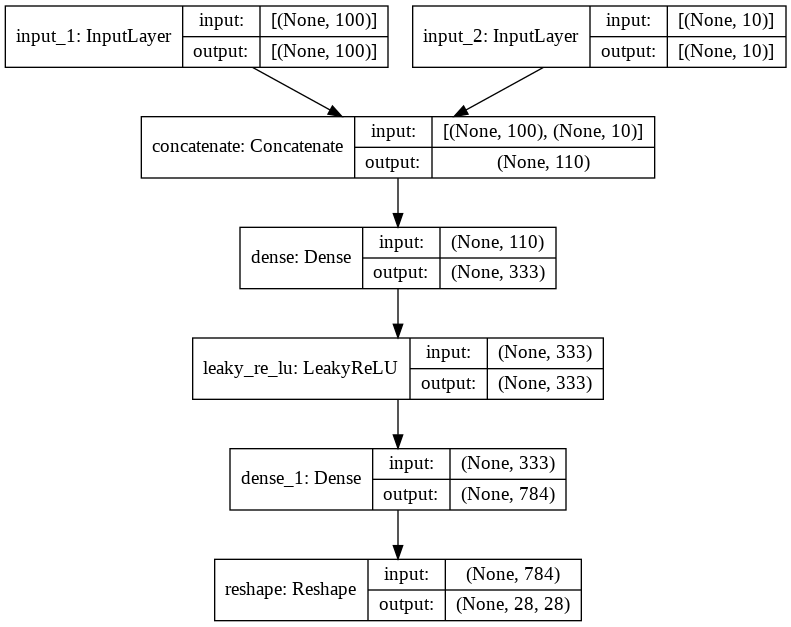

In [0]:
G = models.Model([x,c_onehot], gen_data)
G.summary()
tf.keras.utils.plot_model(G, 'generator.png', show_shapes=True)

### Discriminator model with Dense layer

Generator model과 같이 333개의 노드를 가지는 Dense layer를 가지고 28x28의 입력 이미지가 진짜인지 가짜인지 판별하는 네트워크를 변환시키는 생성 네트워크모델을 구성한다. 이때 입력되는 라벨은 이미지를 평활화한뒤에 concatenate 되어 총 794의 차원의 벡터가 네트워크 모델에 의해 처리된다. 또한 50%의 확률로 노드를 비활성화하는 Dropout layer 를 이용하여 Ensemble효과를 본다.

In [0]:
# Discriminator 모델 작성

dsc1 = layers.Dense(333)
LReLU = layers.LeakyReLU()
drop = layers.Dropout(0.5)
dsc_out = layers.Dense(1)

data = layers.Input(shape=(28,28))
x_flatten = layers.Flatten()(data)

inputs = layers.concatenate([x_flatten, c_onehot], axis=1)
x_dsc = dsc1(inputs)
x_dsc = LReLU(x_dsc)
x_dsc = drop(x_dsc)
dsc_result = dsc_out(x_dsc)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           flatten[0][0]                    
                                                                 input_2[0][0]              

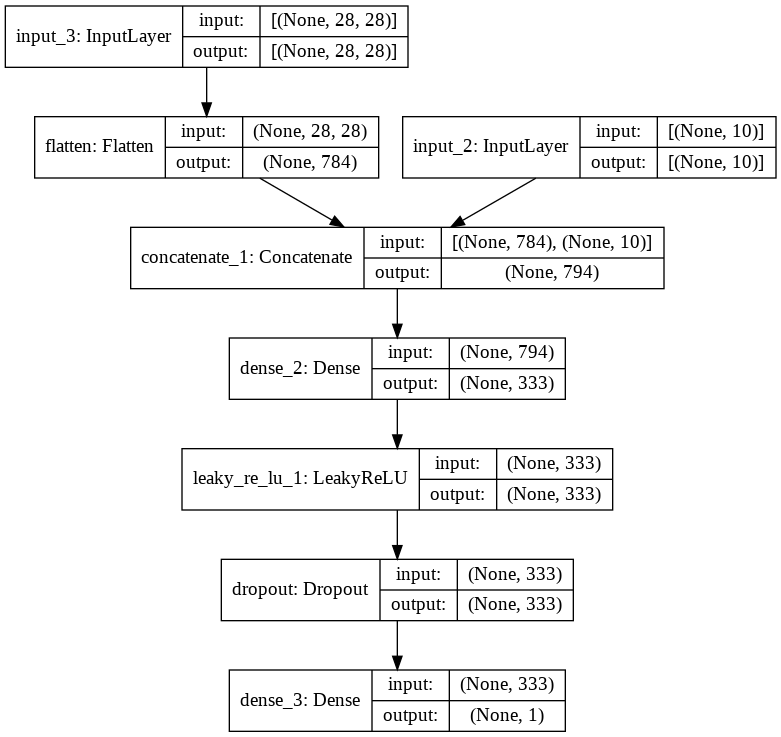

In [0]:
D = models.Model([data,c_onehot], dsc_result)
D.summary()
tf.keras.utils.plot_model(D, "discriminator.png", show_shapes=True)

### Noise image Test

훈련 전 생성한 네트워들이 잘 동작하는지 확인해본다.

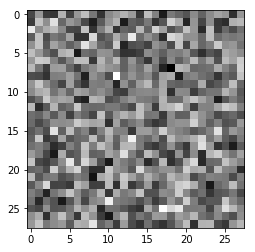

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = tf.random.normal([1, 100])
condition = 3
cond_np = np.zeros([1,10]).astype(np.float32)
cond_np[0][condition-1] = 1.0
cond_tensor = tf.convert_to_tensor(cond_np, dtype=np.float32)

fake_image_test = G([test_noise, cond_tensor])

plt.imshow(fake_image_test[0], cmap='gray')

In [0]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.

decision = D([fake_image_test, cond_tensor])
print(decision)


tf.Tensor([[0.10567535]], shape=(1, 1), dtype=float32)


### Loss function
GAN의 목적함수는 다음과 같다.

$$
\begin{align}
    \min_{G}\max_{D} V(G, D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$



In [0]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss
판별자 D 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최대화 문제를 풀고자 한다.
$$
\begin{align}
    \max_{D} V(D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(\mathbf{x}_{\textrm{fake}}))]
\end{align}
$$



In [0]:
# Discriminator loss 정의

def D_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#### Generator Loss
생성자 G 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최소화 문제를 풀고자 한다.
$$
\begin{align}
    \min_{G} V(G) = \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$

In [0]:
# Generator loss 정의

def G_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

#### 학습 파라미터 설정

Adam optimizer 를 사용하고 learning rate는 Generator의 로스를 10배 높게 설정한다.
여러번의 학습을 통해 최종적으로 214의 epoch을 했을때의 결과가 좋게 나오는것을 확인할수 있었다.
입력노이즈의 사이즈는 100으로 정한다.

In [0]:
# GAN 트레이닝에 쓰일 optimizer 정의

G_optimizer = tf.keras.optimizers.Adam(1e-3)
D_optimizer = tf.keras.optimizers.Adam(1e-4)


In [0]:
# 학습 루프 설정

EPOCHS = 214
noise_dim = 100


### Train/Test function

실제로 연산을 진행하는 순서를 정하는 학습및 검증 함수를 작성한다.
train 함수 에서는 각 Epoch별로 조건별 생성결과를 저장하고 추후 그래프를 그리기위해서 로스값을 리스트에 저장한다.

In [0]:
# 배치단위 학습 함수 설정 (* AutoGraph 기능 쓰기!)

@tf.function
def train_step(real_images, condition):  
  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])
  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
        fake_images = G([noises,condition], training=True)
    
        real_output = D([real_images, condition], training=True)
        fake_output = D([fake_images, condition], training=True)

        gen_loss = G_loss(fake_output)
        dsc_loss = D_loss(real_output, fake_output)
    
    gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
    dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  
    G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables)) 
    D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

    return gen_loss, dsc_loss
  

In [0]:
def test_step(real_images, condition):  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])

    fake_images = G([noises, condition], training=False)

    real_output = D([real_images, condition], training=False)
    fake_output = D([fake_images, condition], training=False)    

    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)

    print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())
    
    return gen_loss.numpy(), dsc_loss.numpy()

In [0]:
# Loss 저장 리스트
train_gen_list = []
train_dsc_list = []
test_gen_list = []
test_dsc_list = []

# 학습 함수
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        temp_train_gen = []
        temp_train_dsc = []
        for i, (image_batch, image_cond, _) in enumerate(dataset):
            train_gen_loss, train_dsc_loss = train_step(image_batch, image_cond)
            temp_train_gen.append(train_gen_loss.numpy())
            temp_train_dsc.append(train_dsc_loss.numpy())
            
            if i == BUFFER_SIZE//BATCH_SIZE-1:
                test_gen_loss, test_dsc_loss = test_step(image_batch, image_cond)
        
        train_gen_list.append(np.mean(np.asarray(temp_train_gen)))
        train_dsc_list.append(np.mean(np.asarray(temp_train_dsc)))
        test_gen_list.append(test_gen_loss)
        test_dsc_list.append(test_dsc_loss)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    
        
        
        import matplotlib.pyplot as plt

        noises = tf.random.normal([10, 100])
        test_cond = list(range(10))
        cond_np = np.zeros([10,10]).astype(np.float32)

        for i, cond in enumerate(test_cond):
            cond_np[i][cond] = 1.0

        cond_tensor = tf.convert_to_tensor(cond_np, dtype=np.float32)

        generated_image = G([noises, cond_tensor])

        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

        for ax in axes.flat:
            ax.axis('off')

        axes[0,0].imshow(generated_image[0], cmap='gray')
        axes[0,0].title.set_text("Condition:"+str(test_cond[0]))
        axes[0,1].imshow(generated_image[1], cmap='gray')
        axes[0,1].title.set_text("Condition:"+str(test_cond[1]))
        axes[0,2].imshow(generated_image[2], cmap='gray')
        axes[0,2].title.set_text("Condition:"+str(test_cond[2]))
        axes[0,3].imshow(generated_image[3], cmap='gray')
        axes[0,3].title.set_text("Condition:"+str(test_cond[3]))
        axes[0,4].imshow(generated_image[4], cmap='gray')
        axes[0,4].title.set_text("Condition:"+str(test_cond[4]))

        axes[1,0].imshow(generated_image[5], cmap='gray')
        axes[1,0].title.set_text("Condition:"+str(test_cond[5]))
        axes[1,1].imshow(generated_image[6], cmap='gray')
        axes[1,1].title.set_text("Condition:"+str(test_cond[6]))
        axes[1,2].imshow(generated_image[7], cmap='gray')
        axes[1,2].title.set_text("Condition:"+str(test_cond[7]))
        axes[1,3].imshow(generated_image[8], cmap='gray')
        axes[1,3].title.set_text("Condition:"+str(test_cond[8]))
        axes[1,4].imshow(generated_image[9], cmap='gray')
        axes[1,4].title.set_text("Condition:"+str(test_cond[9]))

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.close()
        
        checkpoint_name = "CGAN_E"+str(epoch)
        G.save_weights("G_"+checkpoint_name)
        D.save_weights("D_"+checkpoint_name)
        
        # Google auth refresh
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)

        # Upload weights
        for f in glob.glob("*G_"+checkpoint_name+"*"):
            print("Upload file:",f)
            # Upload model
            model_file = drive.CreateFile({'title' : f})
            model_file.SetContentFile(f)
            model_file.Upload()
            
        for f in glob.glob("*D_"+checkpoint_name+"*"):
            print("Upload file:",f)
            # Upload model
            model_file = drive.CreateFile({'title' : f})
            model_file.SetContentFile(f)
            model_file.Upload()
            
            
    return train_gen_list, train_dsc_list, test_gen_list, test_dsc_list

### Training

이미지와 loss의 변화를 확인하기위해서 모든 결과를 압축하여 구글드라이브에 업로드한다.

In [0]:
# 학습!!!
%%time
total_train_gen_list, total_train_dsc_list, total_test_gen_list, total_test_dsc_list = train(train_dataset, EPOCHS)

import pickle
total_train_gen_list, total_train_dsc_list, total_test_gen_list, total_test_dsc_list
with open('train_gen_loss.pkl', 'wb') as f:
    pickle.dump(total_train_gen_list, f)
with open('train_dsc_loss.pkl', 'wb') as f:
    pickle.dump(total_train_dsc_list, f)
with open('test_gen_loss.pkl', 'wb') as f:
    pickle.dump(total_test_gen_list, f)
with open('test_dsc_loss.pkl', 'wb') as f:
    pickle.dump(total_test_dsc_list, f)

!zip loss_data.zip *.pkl
!zip img_output.zip image*.png

# Google auth refresh
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print("Upload file:",'loss_data.zip')
# Upload loss data
model_file = drive.CreateFile({'title' : 'loss_data.zip'})
model_file.SetContentFile('loss_data.zip')
model_file.Upload()

print("Upload file:",'img_output.zip')
# Upload loss data
model_file = drive.CreateFile({'title' : 'img_output.zip'})
model_file.SetContentFile('img_output.zip')
model_file.Upload()

Generator loss: 0.77284914 Discriminator loss: 1.2184992
Time for epoch 1 is 14.335514068603516 sec


W0424 12:24:38.372485 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E0.data-00000-of-00003
Upload file: G_CGAN_E0.index
Upload file: G_CGAN_E0.data-00002-of-00003
Upload file: G_CGAN_E0.data-00001-of-00003
Upload file: D_CGAN_E0.index
Upload file: D_CGAN_E0.data-00002-of-00003
Upload file: D_CGAN_E0.data-00001-of-00003
Upload file: D_CGAN_E0.data-00000-of-00003
Generator loss: 0.78214574 Discriminator loss: 1.2887995
Time for epoch 2 is 12.77867841720581 sec


W0424 12:25:06.703156 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E11.data-00000-of-00003
Upload file: G_CGAN_E16.index
Upload file: G_CGAN_E17.data-00000-of-00003
Upload file: G_CGAN_E12.index
Upload file: G_CGAN_E14.data-00000-of-00003
Upload file: G_CGAN_E15.data-00000-of-00003
Upload file: G_CGAN_E18.data-00000-of-00003
Upload file: G_CGAN_E19.data-00001-of-00003
Upload file: G_CGAN_E13.index
Upload file: G_CGAN_E15.data-00001-of-00003
Upload file: G_CGAN_E18.index
Upload file: G_CGAN_E1.index
Upload file: G_CGAN_E12.data-00000-of-00003
Upload file: G_CGAN_E19.data-00002-of-00003
Upload file: G_CGAN_E16.data-00000-of-00003
Upload file: G_CGAN_E10.index
Upload file: G_CGAN_E15.data-00002-of-00003
Upload file: G_CGAN_E19.data-00000-of-00003
Upload file: G_CGAN_E1.data-00001-of-00003
Upload file: G_CGAN_E17.index
Upload file: G_CGAN_E19.index
Upload file: G_CGAN_E18.data-00002-of-00003
Upload file: G_CGAN_E17.data-00002-of-00003
Upload file: G_CGAN_E11.data-00001-of-00003
Upload file: G_CGAN_E11.data-00002-of-00003
Upload file: G

W0424 12:27:50.685197 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E23.data-00001-of-00003
Upload file: G_CGAN_E27.data-00001-of-00003
Upload file: G_CGAN_E26.index
Upload file: G_CGAN_E29.data-00002-of-00003
Upload file: G_CGAN_E24.data-00000-of-00003
Upload file: G_CGAN_E29.data-00000-of-00003
Upload file: G_CGAN_E20.data-00001-of-00003
Upload file: G_CGAN_E20.index
Upload file: G_CGAN_E2.data-00001-of-00003
Upload file: G_CGAN_E22.data-00000-of-00003
Upload file: G_CGAN_E24.index
Upload file: G_CGAN_E21.data-00001-of-00003
Upload file: G_CGAN_E2.index
Upload file: G_CGAN_E22.index
Upload file: G_CGAN_E24.data-00001-of-00003
Upload file: G_CGAN_E2.data-00002-of-00003
Upload file: G_CGAN_E27.data-00002-of-00003
Upload file: G_CGAN_E20.data-00000-of-00003
Upload file: G_CGAN_E26.data-00001-of-00003
Upload file: G_CGAN_E25.data-00001-of-00003
Upload file: G_CGAN_E26.data-00000-of-00003
Upload file: G_CGAN_E25.data-00002-of-00003
Upload file: G_CGAN_E21.data-00000-of-00003
Upload file: G_CGAN_E22.data-00001-of-00003
Upload file: G_CG

W0424 12:30:30.985365 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E38.data-00000-of-00003
Upload file: G_CGAN_E33.data-00002-of-00003
Upload file: G_CGAN_E33.data-00000-of-00003
Upload file: G_CGAN_E30.data-00000-of-00003
Upload file: G_CGAN_E32.data-00002-of-00003
Upload file: G_CGAN_E30.index
Upload file: G_CGAN_E34.data-00002-of-00003
Upload file: G_CGAN_E38.data-00001-of-00003
Upload file: G_CGAN_E35.index
Upload file: G_CGAN_E39.data-00002-of-00003
Upload file: G_CGAN_E31.data-00002-of-00003
Upload file: G_CGAN_E36.index
Upload file: G_CGAN_E34.data-00000-of-00003
Upload file: G_CGAN_E36.data-00002-of-00003
Upload file: G_CGAN_E3.data-00002-of-00003
Upload file: G_CGAN_E36.data-00001-of-00003
Upload file: G_CGAN_E38.index
Upload file: G_CGAN_E39.data-00000-of-00003
Upload file: G_CGAN_E35.data-00000-of-00003
Upload file: G_CGAN_E32.index
Upload file: G_CGAN_E33.data-00001-of-00003
Upload file: G_CGAN_E37.data-00000-of-00003
Upload file: G_CGAN_E39.index
Upload file: G_CGAN_E31.data-00001-of-00003
Upload file: G_CGAN_E32.data-

W0424 12:33:09.830209 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E45.data-00000-of-00003
Upload file: G_CGAN_E44.index
Upload file: G_CGAN_E44.data-00000-of-00003
Upload file: G_CGAN_E42.index
Upload file: G_CGAN_E40.data-00001-of-00003
Upload file: G_CGAN_E45.data-00001-of-00003
Upload file: G_CGAN_E43.data-00002-of-00003
Upload file: G_CGAN_E47.data-00000-of-00003
Upload file: G_CGAN_E40.data-00000-of-00003
Upload file: G_CGAN_E49.data-00001-of-00003
Upload file: G_CGAN_E49.index
Upload file: G_CGAN_E41.data-00002-of-00003
Upload file: G_CGAN_E46.data-00000-of-00003
Upload file: G_CGAN_E41.index
Upload file: G_CGAN_E42.data-00000-of-00003
Upload file: G_CGAN_E43.index
Upload file: G_CGAN_E44.data-00001-of-00003
Upload file: G_CGAN_E4.data-00000-of-00003
Upload file: G_CGAN_E47.data-00002-of-00003
Upload file: G_CGAN_E46.data-00002-of-00003
Upload file: G_CGAN_E41.data-00001-of-00003
Upload file: G_CGAN_E40.data-00002-of-00003
Upload file: G_CGAN_E4.data-00001-of-00003
Upload file: G_CGAN_E41.data-00000-of-00003
Upload file: G_C

W0424 12:35:53.230316 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E54.data-00002-of-00003
Upload file: G_CGAN_E50.index
Upload file: G_CGAN_E58.data-00002-of-00003
Upload file: G_CGAN_E59.data-00000-of-00003
Upload file: G_CGAN_E55.index
Upload file: G_CGAN_E52.data-00000-of-00003
Upload file: G_CGAN_E50.data-00001-of-00003
Upload file: G_CGAN_E59.data-00001-of-00003
Upload file: G_CGAN_E56.data-00001-of-00003
Upload file: G_CGAN_E51.data-00000-of-00003
Upload file: G_CGAN_E53.data-00001-of-00003
Upload file: G_CGAN_E52.index
Upload file: G_CGAN_E52.data-00002-of-00003
Upload file: G_CGAN_E56.index
Upload file: G_CGAN_E57.data-00002-of-00003
Upload file: G_CGAN_E55.data-00000-of-00003
Upload file: G_CGAN_E53.data-00000-of-00003
Upload file: G_CGAN_E5.index
Upload file: G_CGAN_E55.data-00002-of-00003
Upload file: G_CGAN_E54.data-00000-of-00003
Upload file: G_CGAN_E58.data-00001-of-00003
Upload file: G_CGAN_E52.data-00001-of-00003
Upload file: G_CGAN_E58.data-00000-of-00003
Upload file: G_CGAN_E53.data-00002-of-00003
Upload file: G_

W0424 12:38:29.875335 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E69.data-00001-of-00003
Upload file: G_CGAN_E67.data-00000-of-00003
Upload file: G_CGAN_E63.data-00002-of-00003
Upload file: G_CGAN_E63.index
Upload file: G_CGAN_E67.data-00001-of-00003
Upload file: G_CGAN_E60.data-00001-of-00003
Upload file: G_CGAN_E63.data-00001-of-00003
Upload file: G_CGAN_E68.index
Upload file: G_CGAN_E65.data-00002-of-00003
Upload file: G_CGAN_E69.index
Upload file: G_CGAN_E62.data-00000-of-00003
Upload file: G_CGAN_E66.data-00002-of-00003
Upload file: G_CGAN_E69.data-00002-of-00003
Upload file: G_CGAN_E65.index
Upload file: G_CGAN_E6.data-00000-of-00003
Upload file: G_CGAN_E67.data-00002-of-00003
Upload file: G_CGAN_E61.index
Upload file: G_CGAN_E61.data-00000-of-00003
Upload file: G_CGAN_E61.data-00001-of-00003
Upload file: G_CGAN_E64.data-00001-of-00003
Upload file: G_CGAN_E66.data-00000-of-00003
Upload file: G_CGAN_E60.data-00002-of-00003
Upload file: G_CGAN_E68.data-00001-of-00003
Upload file: G_CGAN_E60.index
Upload file: G_CGAN_E67.index

W0424 12:41:05.111683 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E79.data-00000-of-00003
Upload file: G_CGAN_E77.data-00000-of-00003
Upload file: G_CGAN_E74.data-00001-of-00003
Upload file: G_CGAN_E78.index
Upload file: G_CGAN_E75.index
Upload file: G_CGAN_E7.data-00002-of-00003
Upload file: G_CGAN_E75.data-00000-of-00003
Upload file: G_CGAN_E78.data-00002-of-00003
Upload file: G_CGAN_E78.data-00001-of-00003
Upload file: G_CGAN_E72.data-00000-of-00003
Upload file: G_CGAN_E70.data-00001-of-00003
Upload file: G_CGAN_E7.index
Upload file: G_CGAN_E79.data-00002-of-00003
Upload file: G_CGAN_E76.index
Upload file: G_CGAN_E77.data-00002-of-00003
Upload file: G_CGAN_E76.data-00002-of-00003
Upload file: G_CGAN_E79.index
Upload file: G_CGAN_E76.data-00000-of-00003
Upload file: G_CGAN_E71.data-00000-of-00003
Upload file: G_CGAN_E72.data-00001-of-00003
Upload file: G_CGAN_E72.index
Upload file: G_CGAN_E71.data-00002-of-00003
Upload file: G_CGAN_E7.data-00001-of-00003
Upload file: G_CGAN_E73.data-00002-of-00003
Upload file: G_CGAN_E77.data-00

W0424 12:43:41.962873 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E8.data-00001-of-00003
Upload file: G_CGAN_E8.data-00000-of-00003
Upload file: G_CGAN_E82.index
Upload file: G_CGAN_E87.data-00001-of-00003
Upload file: G_CGAN_E83.index
Upload file: G_CGAN_E89.index
Upload file: G_CGAN_E84.data-00000-of-00003
Upload file: G_CGAN_E86.data-00002-of-00003
Upload file: G_CGAN_E85.index
Upload file: G_CGAN_E85.data-00001-of-00003
Upload file: G_CGAN_E81.index
Upload file: G_CGAN_E81.data-00001-of-00003
Upload file: G_CGAN_E88.data-00001-of-00003
Upload file: G_CGAN_E85.data-00000-of-00003
Upload file: G_CGAN_E82.data-00001-of-00003
Upload file: G_CGAN_E89.data-00002-of-00003
Upload file: G_CGAN_E81.data-00000-of-00003
Upload file: G_CGAN_E87.data-00000-of-00003
Upload file: G_CGAN_E88.index
Upload file: G_CGAN_E87.data-00002-of-00003
Upload file: G_CGAN_E82.data-00002-of-00003
Upload file: G_CGAN_E84.data-00001-of-00003
Upload file: G_CGAN_E88.data-00000-of-00003
Upload file: G_CGAN_E80.data-00000-of-00003
Upload file: G_CGAN_E8.data-00

W0424 12:46:20.322294 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E96.data-00002-of-00003
Upload file: G_CGAN_E90.data-00001-of-00003
Upload file: G_CGAN_E94.data-00001-of-00003
Upload file: G_CGAN_E95.index
Upload file: G_CGAN_E98.data-00000-of-00003
Upload file: G_CGAN_E90.data-00002-of-00003
Upload file: G_CGAN_E99.data-00000-of-00003
Upload file: G_CGAN_E99.data-00001-of-00003
Upload file: G_CGAN_E96.data-00001-of-00003
Upload file: G_CGAN_E91.data-00001-of-00003
Upload file: G_CGAN_E92.data-00000-of-00003
Upload file: G_CGAN_E97.data-00000-of-00003
Upload file: G_CGAN_E9.index
Upload file: G_CGAN_E99.index
Upload file: G_CGAN_E97.data-00002-of-00003
Upload file: G_CGAN_E97.data-00001-of-00003
Upload file: G_CGAN_E91.index
Upload file: G_CGAN_E96.data-00000-of-00003
Upload file: G_CGAN_E93.index
Upload file: G_CGAN_E98.data-00001-of-00003
Upload file: G_CGAN_E97.index
Upload file: G_CGAN_E98.data-00002-of-00003
Upload file: G_CGAN_E95.data-00000-of-00003
Upload file: G_CGAN_E96.index
Upload file: G_CGAN_E92.data-00002-of-00003

W0424 12:48:52.835726 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E10.index
Upload file: G_CGAN_E10.data-00000-of-00003
Upload file: G_CGAN_E10.data-00001-of-00003
Upload file: G_CGAN_E10.data-00002-of-00003
Upload file: D_CGAN_E10.data-00000-of-00003
Upload file: D_CGAN_E10.data-00001-of-00003
Upload file: D_CGAN_E10.data-00002-of-00003
Upload file: D_CGAN_E10.index
Generator loss: 0.85228723 Discriminator loss: 1.2602508
Time for epoch 12 is 12.699177742004395 sec


W0424 12:49:20.340264 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E11.data-00000-of-00003
Upload file: G_CGAN_E11.data-00001-of-00003
Upload file: G_CGAN_E11.data-00002-of-00003
Upload file: G_CGAN_E11.index
Upload file: D_CGAN_E11.data-00002-of-00003
Upload file: D_CGAN_E11.index
Upload file: D_CGAN_E11.data-00000-of-00003
Upload file: D_CGAN_E11.data-00001-of-00003
Generator loss: 0.7716337 Discriminator loss: 1.287754
Time for epoch 13 is 7.6310038566589355 sec


W0424 12:49:40.815427 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E12.index
Upload file: G_CGAN_E12.data-00000-of-00003
Upload file: G_CGAN_E12.data-00001-of-00003
Upload file: G_CGAN_E12.data-00002-of-00003
Upload file: D_CGAN_E12.data-00000-of-00003
Upload file: D_CGAN_E12.data-00002-of-00003
Upload file: D_CGAN_E12.data-00001-of-00003
Upload file: D_CGAN_E12.index
Generator loss: 0.90123665 Discriminator loss: 1.1908399
Time for epoch 14 is 7.75864052772522 sec


W0424 12:50:02.393815 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E13.index
Upload file: G_CGAN_E13.data-00002-of-00003
Upload file: G_CGAN_E13.data-00001-of-00003
Upload file: G_CGAN_E13.data-00000-of-00003
Upload file: D_CGAN_E13.data-00002-of-00003
Upload file: D_CGAN_E13.index
Upload file: D_CGAN_E13.data-00000-of-00003
Upload file: D_CGAN_E13.data-00001-of-00003
Generator loss: 0.7609539 Discriminator loss: 1.2888548
Time for epoch 15 is 7.603129148483276 sec


W0424 12:50:23.953454 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E14.data-00000-of-00003
Upload file: G_CGAN_E14.data-00001-of-00003
Upload file: G_CGAN_E14.index
Upload file: G_CGAN_E14.data-00002-of-00003
Upload file: D_CGAN_E14.data-00000-of-00003
Upload file: D_CGAN_E14.data-00001-of-00003
Upload file: D_CGAN_E14.index
Upload file: D_CGAN_E14.data-00002-of-00003
Generator loss: 0.8344648 Discriminator loss: 1.3089811
Time for epoch 16 is 7.64869236946106 sec


W0424 12:50:44.768830 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E15.data-00000-of-00003
Upload file: G_CGAN_E15.data-00001-of-00003
Upload file: G_CGAN_E15.data-00002-of-00003
Upload file: G_CGAN_E15.index
Upload file: D_CGAN_E15.index
Upload file: D_CGAN_E15.data-00001-of-00003
Upload file: D_CGAN_E15.data-00000-of-00003
Upload file: D_CGAN_E15.data-00002-of-00003
Generator loss: 0.7769424 Discriminator loss: 1.2660412
Time for epoch 17 is 8.09726071357727 sec


W0424 12:51:06.139885 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E16.index
Upload file: G_CGAN_E16.data-00000-of-00003
Upload file: G_CGAN_E16.data-00001-of-00003
Upload file: G_CGAN_E16.data-00002-of-00003
Upload file: D_CGAN_E16.data-00002-of-00003
Upload file: D_CGAN_E16.data-00001-of-00003
Upload file: D_CGAN_E16.data-00000-of-00003
Upload file: D_CGAN_E16.index
Generator loss: 0.77120155 Discriminator loss: 1.2574017
Time for epoch 18 is 7.639662742614746 sec


W0424 12:51:27.413441 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E17.data-00000-of-00003
Upload file: G_CGAN_E17.index
Upload file: G_CGAN_E17.data-00002-of-00003
Upload file: G_CGAN_E17.data-00001-of-00003
Upload file: D_CGAN_E17.data-00002-of-00003
Upload file: D_CGAN_E17.data-00000-of-00003
Upload file: D_CGAN_E17.index
Upload file: D_CGAN_E17.data-00001-of-00003
Generator loss: 0.76680344 Discriminator loss: 1.2741427
Time for epoch 19 is 7.548112630844116 sec


W0424 12:51:48.402591 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E18.data-00000-of-00003
Upload file: G_CGAN_E18.index
Upload file: G_CGAN_E18.data-00002-of-00003
Upload file: G_CGAN_E18.data-00001-of-00003
Upload file: D_CGAN_E18.data-00001-of-00003
Upload file: D_CGAN_E18.index
Upload file: D_CGAN_E18.data-00000-of-00003
Upload file: D_CGAN_E18.data-00002-of-00003
Generator loss: 0.77114594 Discriminator loss: 1.2417545
Time for epoch 20 is 7.582286357879639 sec


W0424 12:52:09.773080 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E19.data-00001-of-00003
Upload file: G_CGAN_E19.data-00002-of-00003
Upload file: G_CGAN_E19.data-00000-of-00003
Upload file: G_CGAN_E19.index
Upload file: D_CGAN_E19.index
Upload file: D_CGAN_E19.data-00000-of-00003
Upload file: D_CGAN_E19.data-00001-of-00003
Upload file: D_CGAN_E19.data-00002-of-00003
Generator loss: 0.77662396 Discriminator loss: 1.2765195
Time for epoch 21 is 8.50273060798645 sec


W0424 12:52:32.429253 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E20.data-00001-of-00003
Upload file: G_CGAN_E20.index
Upload file: G_CGAN_E20.data-00000-of-00003
Upload file: G_CGAN_E20.data-00002-of-00003
Upload file: D_CGAN_E20.index
Upload file: D_CGAN_E20.data-00000-of-00003
Upload file: D_CGAN_E20.data-00001-of-00003
Upload file: D_CGAN_E20.data-00002-of-00003
Generator loss: 0.8073305 Discriminator loss: 1.2072
Time for epoch 22 is 7.75393009185791 sec


W0424 12:52:54.287765 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E21.data-00001-of-00003
Upload file: G_CGAN_E21.data-00000-of-00003
Upload file: G_CGAN_E21.data-00002-of-00003
Upload file: G_CGAN_E21.index
Upload file: D_CGAN_E21.data-00000-of-00003
Upload file: D_CGAN_E21.data-00001-of-00003
Upload file: D_CGAN_E21.index
Upload file: D_CGAN_E21.data-00002-of-00003
Generator loss: 0.8095124 Discriminator loss: 1.2717364
Time for epoch 23 is 7.699826717376709 sec


W0424 12:53:15.669861 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E22.data-00000-of-00003
Upload file: G_CGAN_E22.index
Upload file: G_CGAN_E22.data-00001-of-00003
Upload file: G_CGAN_E22.data-00002-of-00003
Upload file: D_CGAN_E22.data-00001-of-00003
Upload file: D_CGAN_E22.data-00000-of-00003
Upload file: D_CGAN_E22.data-00002-of-00003
Upload file: D_CGAN_E22.index
Generator loss: 0.77637666 Discriminator loss: 1.2447038
Time for epoch 24 is 7.710740327835083 sec


W0424 12:53:36.413947 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E23.data-00001-of-00003
Upload file: G_CGAN_E23.index
Upload file: G_CGAN_E23.data-00000-of-00003
Upload file: G_CGAN_E23.data-00002-of-00003
Upload file: D_CGAN_E23.index
Upload file: D_CGAN_E23.data-00001-of-00003
Upload file: D_CGAN_E23.data-00002-of-00003
Upload file: D_CGAN_E23.data-00000-of-00003
Generator loss: 0.7601768 Discriminator loss: 1.2685022
Time for epoch 25 is 7.602314710617065 sec


W0424 12:53:59.667458 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E24.data-00000-of-00003
Upload file: G_CGAN_E24.index
Upload file: G_CGAN_E24.data-00001-of-00003
Upload file: G_CGAN_E24.data-00002-of-00003
Upload file: D_CGAN_E24.data-00002-of-00003
Upload file: D_CGAN_E24.index
Upload file: D_CGAN_E24.data-00001-of-00003
Upload file: D_CGAN_E24.data-00000-of-00003
Generator loss: 0.7672955 Discriminator loss: 1.3039458
Time for epoch 26 is 7.592390060424805 sec


W0424 12:54:20.167124 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E25.data-00001-of-00003
Upload file: G_CGAN_E25.data-00002-of-00003
Upload file: G_CGAN_E25.index
Upload file: G_CGAN_E25.data-00000-of-00003
Upload file: D_CGAN_E25.data-00001-of-00003
Upload file: D_CGAN_E25.index
Upload file: D_CGAN_E25.data-00002-of-00003
Upload file: D_CGAN_E25.data-00000-of-00003
Generator loss: 0.7292394 Discriminator loss: 1.3671262
Time for epoch 27 is 7.660873651504517 sec


W0424 12:54:40.654971 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E26.index
Upload file: G_CGAN_E26.data-00001-of-00003
Upload file: G_CGAN_E26.data-00000-of-00003
Upload file: G_CGAN_E26.data-00002-of-00003
Upload file: D_CGAN_E26.data-00002-of-00003
Upload file: D_CGAN_E26.data-00001-of-00003
Upload file: D_CGAN_E26.index
Upload file: D_CGAN_E26.data-00000-of-00003
Generator loss: 0.70496833 Discriminator loss: 1.3069432
Time for epoch 28 is 7.8297693729400635 sec


W0424 12:55:00.790747 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E27.data-00001-of-00003
Upload file: G_CGAN_E27.data-00002-of-00003
Upload file: G_CGAN_E27.data-00000-of-00003
Upload file: G_CGAN_E27.index
Upload file: D_CGAN_E27.data-00000-of-00003
Upload file: D_CGAN_E27.data-00001-of-00003
Upload file: D_CGAN_E27.data-00002-of-00003
Upload file: D_CGAN_E27.index
Generator loss: 0.7468068 Discriminator loss: 1.2927442
Time for epoch 29 is 7.582341432571411 sec


W0424 12:55:21.365007 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E28.data-00000-of-00003
Upload file: G_CGAN_E28.index
Upload file: G_CGAN_E28.data-00001-of-00003
Upload file: G_CGAN_E28.data-00002-of-00003
Upload file: D_CGAN_E28.data-00000-of-00003
Upload file: D_CGAN_E28.index
Upload file: D_CGAN_E28.data-00001-of-00003
Upload file: D_CGAN_E28.data-00002-of-00003
Generator loss: 0.79998183 Discriminator loss: 1.239001
Time for epoch 30 is 7.692582607269287 sec


W0424 12:55:42.398076 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E29.data-00002-of-00003
Upload file: G_CGAN_E29.data-00000-of-00003
Upload file: G_CGAN_E29.data-00001-of-00003
Upload file: G_CGAN_E29.index
Upload file: D_CGAN_E29.data-00002-of-00003
Upload file: D_CGAN_E29.data-00001-of-00003
Upload file: D_CGAN_E29.data-00000-of-00003
Upload file: D_CGAN_E29.index
Generator loss: 0.78745157 Discriminator loss: 1.2481682
Time for epoch 31 is 7.600005388259888 sec


W0424 12:56:03.021862 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E30.data-00000-of-00003
Upload file: G_CGAN_E30.index
Upload file: G_CGAN_E30.data-00002-of-00003
Upload file: G_CGAN_E30.data-00001-of-00003
Upload file: D_CGAN_E30.data-00001-of-00003
Upload file: D_CGAN_E30.index
Upload file: D_CGAN_E30.data-00002-of-00003
Upload file: D_CGAN_E30.data-00000-of-00003
Generator loss: 0.8475435 Discriminator loss: 1.1369861
Time for epoch 32 is 8.642496585845947 sec


W0424 12:56:24.775162 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E31.data-00002-of-00003
Upload file: G_CGAN_E31.data-00001-of-00003
Upload file: G_CGAN_E31.data-00000-of-00003
Upload file: G_CGAN_E31.index
Upload file: D_CGAN_E31.data-00001-of-00003
Upload file: D_CGAN_E31.data-00000-of-00003
Upload file: D_CGAN_E31.data-00002-of-00003
Upload file: D_CGAN_E31.index
Generator loss: 0.79041666 Discriminator loss: 1.2771714
Time for epoch 33 is 7.529780387878418 sec


W0424 12:56:45.500422 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E32.data-00002-of-00003
Upload file: G_CGAN_E32.index
Upload file: G_CGAN_E32.data-00000-of-00003
Upload file: G_CGAN_E32.data-00001-of-00003
Upload file: D_CGAN_E32.data-00001-of-00003
Upload file: D_CGAN_E32.data-00000-of-00003
Upload file: D_CGAN_E32.data-00002-of-00003
Upload file: D_CGAN_E32.index
Generator loss: 0.77904177 Discriminator loss: 1.2316246
Time for epoch 34 is 7.893500089645386 sec


W0424 12:57:06.872876 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E33.data-00002-of-00003
Upload file: G_CGAN_E33.data-00000-of-00003
Upload file: G_CGAN_E33.data-00001-of-00003
Upload file: G_CGAN_E33.index
Upload file: D_CGAN_E33.data-00001-of-00003
Upload file: D_CGAN_E33.data-00000-of-00003
Upload file: D_CGAN_E33.index
Upload file: D_CGAN_E33.data-00002-of-00003
Generator loss: 0.78210497 Discriminator loss: 1.2459986
Time for epoch 35 is 7.836649179458618 sec


W0424 12:57:27.286253 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E34.data-00002-of-00003
Upload file: G_CGAN_E34.data-00000-of-00003
Upload file: G_CGAN_E34.data-00001-of-00003
Upload file: G_CGAN_E34.index
Upload file: D_CGAN_E34.index
Upload file: D_CGAN_E34.data-00002-of-00003
Upload file: D_CGAN_E34.data-00000-of-00003
Upload file: D_CGAN_E34.data-00001-of-00003
Generator loss: 0.82471055 Discriminator loss: 1.231955
Time for epoch 36 is 7.9681689739227295 sec


W0424 12:57:48.341292 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E35.index
Upload file: G_CGAN_E35.data-00000-of-00003
Upload file: G_CGAN_E35.data-00001-of-00003
Upload file: G_CGAN_E35.data-00002-of-00003
Upload file: D_CGAN_E35.index
Upload file: D_CGAN_E35.data-00001-of-00003
Upload file: D_CGAN_E35.data-00000-of-00003
Upload file: D_CGAN_E35.data-00002-of-00003
Generator loss: 0.77388453 Discriminator loss: 1.206959
Time for epoch 37 is 7.727478504180908 sec


W0424 12:58:08.830976 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E36.index
Upload file: G_CGAN_E36.data-00002-of-00003
Upload file: G_CGAN_E36.data-00001-of-00003
Upload file: G_CGAN_E36.data-00000-of-00003
Upload file: D_CGAN_E36.index
Upload file: D_CGAN_E36.data-00000-of-00003
Upload file: D_CGAN_E36.data-00001-of-00003
Upload file: D_CGAN_E36.data-00002-of-00003
Generator loss: 0.84860474 Discriminator loss: 1.180087
Time for epoch 38 is 7.526993274688721 sec


W0424 12:58:29.791693 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E37.data-00000-of-00003
Upload file: G_CGAN_E37.data-00001-of-00003
Upload file: G_CGAN_E37.data-00002-of-00003
Upload file: G_CGAN_E37.index
Upload file: D_CGAN_E37.data-00001-of-00003
Upload file: D_CGAN_E37.data-00000-of-00003
Upload file: D_CGAN_E37.index
Upload file: D_CGAN_E37.data-00002-of-00003
Generator loss: 0.7794522 Discriminator loss: 1.3140404
Time for epoch 39 is 8.121721029281616 sec


W0424 12:58:51.314321 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E38.data-00000-of-00003
Upload file: G_CGAN_E38.data-00001-of-00003
Upload file: G_CGAN_E38.index
Upload file: G_CGAN_E38.data-00002-of-00003
Upload file: D_CGAN_E38.data-00000-of-00003
Upload file: D_CGAN_E38.data-00001-of-00003
Upload file: D_CGAN_E38.index
Upload file: D_CGAN_E38.data-00002-of-00003
Generator loss: 0.80033785 Discriminator loss: 1.2138348
Time for epoch 40 is 8.514487743377686 sec


W0424 12:59:12.972046 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E39.data-00002-of-00003
Upload file: G_CGAN_E39.data-00000-of-00003
Upload file: G_CGAN_E39.index
Upload file: G_CGAN_E39.data-00001-of-00003
Upload file: D_CGAN_E39.index
Upload file: D_CGAN_E39.data-00001-of-00003
Upload file: D_CGAN_E39.data-00000-of-00003
Upload file: D_CGAN_E39.data-00002-of-00003
Generator loss: 0.7636613 Discriminator loss: 1.2984107
Time for epoch 41 is 7.491639137268066 sec


W0424 12:59:33.250264 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E40.data-00001-of-00003
Upload file: G_CGAN_E40.data-00000-of-00003
Upload file: G_CGAN_E40.data-00002-of-00003
Upload file: G_CGAN_E40.index
Upload file: D_CGAN_E40.data-00000-of-00003
Upload file: D_CGAN_E40.data-00002-of-00003
Upload file: D_CGAN_E40.index
Upload file: D_CGAN_E40.data-00001-of-00003
Generator loss: 0.80294174 Discriminator loss: 1.2234323
Time for epoch 42 is 7.622558832168579 sec


W0424 12:59:56.941720 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E41.data-00002-of-00003
Upload file: G_CGAN_E41.index
Upload file: G_CGAN_E41.data-00001-of-00003
Upload file: G_CGAN_E41.data-00000-of-00003
Upload file: D_CGAN_E41.data-00001-of-00003
Upload file: D_CGAN_E41.data-00002-of-00003
Upload file: D_CGAN_E41.index
Upload file: D_CGAN_E41.data-00000-of-00003
Generator loss: 0.8391656 Discriminator loss: 1.1857904
Time for epoch 43 is 7.639065504074097 sec


W0424 13:00:19.151500 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E42.index
Upload file: G_CGAN_E42.data-00000-of-00003
Upload file: G_CGAN_E42.data-00002-of-00003
Upload file: G_CGAN_E42.data-00001-of-00003
Upload file: D_CGAN_E42.data-00002-of-00003
Upload file: D_CGAN_E42.data-00000-of-00003
Upload file: D_CGAN_E42.index
Upload file: D_CGAN_E42.data-00001-of-00003
Generator loss: 0.7093836 Discriminator loss: 1.3264744
Time for epoch 44 is 7.920391321182251 sec


W0424 13:00:40.648669 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E43.data-00002-of-00003
Upload file: G_CGAN_E43.index
Upload file: G_CGAN_E43.data-00001-of-00003
Upload file: G_CGAN_E43.data-00000-of-00003
Upload file: D_CGAN_E43.data-00000-of-00003
Upload file: D_CGAN_E43.index
Upload file: D_CGAN_E43.data-00001-of-00003
Upload file: D_CGAN_E43.data-00002-of-00003
Generator loss: 0.7821674 Discriminator loss: 1.2672548
Time for epoch 45 is 7.637127161026001 sec


W0424 13:01:01.468217 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E44.index
Upload file: G_CGAN_E44.data-00000-of-00003
Upload file: G_CGAN_E44.data-00001-of-00003
Upload file: G_CGAN_E44.data-00002-of-00003
Upload file: D_CGAN_E44.data-00002-of-00003
Upload file: D_CGAN_E44.data-00000-of-00003
Upload file: D_CGAN_E44.index
Upload file: D_CGAN_E44.data-00001-of-00003
Generator loss: 0.79706734 Discriminator loss: 1.2433434
Time for epoch 46 is 7.5040974617004395 sec


W0424 13:01:22.424780 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E45.data-00000-of-00003
Upload file: G_CGAN_E45.data-00001-of-00003
Upload file: G_CGAN_E45.index
Upload file: G_CGAN_E45.data-00002-of-00003
Upload file: D_CGAN_E45.index
Upload file: D_CGAN_E45.data-00002-of-00003
Upload file: D_CGAN_E45.data-00000-of-00003
Upload file: D_CGAN_E45.data-00001-of-00003
Generator loss: 0.8045131 Discriminator loss: 1.2364323
Time for epoch 47 is 7.766212701797485 sec


W0424 13:01:43.426517 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E46.data-00000-of-00003
Upload file: G_CGAN_E46.data-00002-of-00003
Upload file: G_CGAN_E46.index
Upload file: G_CGAN_E46.data-00001-of-00003
Upload file: D_CGAN_E46.data-00000-of-00003
Upload file: D_CGAN_E46.data-00002-of-00003
Upload file: D_CGAN_E46.index
Upload file: D_CGAN_E46.data-00001-of-00003
Generator loss: 0.81531364 Discriminator loss: 1.1751912
Time for epoch 48 is 7.747742652893066 sec


W0424 13:02:04.372989 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E47.data-00000-of-00003
Upload file: G_CGAN_E47.data-00002-of-00003
Upload file: G_CGAN_E47.data-00001-of-00003
Upload file: G_CGAN_E47.index
Upload file: D_CGAN_E47.data-00001-of-00003
Upload file: D_CGAN_E47.index
Upload file: D_CGAN_E47.data-00000-of-00003
Upload file: D_CGAN_E47.data-00002-of-00003
Generator loss: 0.8066605 Discriminator loss: 1.2379407
Time for epoch 49 is 7.611783742904663 sec


W0424 13:02:26.043719 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E48.data-00002-of-00003
Upload file: G_CGAN_E48.index
Upload file: G_CGAN_E48.data-00001-of-00003
Upload file: G_CGAN_E48.data-00000-of-00003
Upload file: D_CGAN_E48.data-00002-of-00003
Upload file: D_CGAN_E48.data-00000-of-00003
Upload file: D_CGAN_E48.index
Upload file: D_CGAN_E48.data-00001-of-00003
Generator loss: 0.8019481 Discriminator loss: 1.2347921
Time for epoch 50 is 7.541895627975464 sec


W0424 13:02:46.590249 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E49.data-00001-of-00003
Upload file: G_CGAN_E49.index
Upload file: G_CGAN_E49.data-00002-of-00003
Upload file: G_CGAN_E49.data-00000-of-00003
Upload file: D_CGAN_E49.data-00002-of-00003
Upload file: D_CGAN_E49.data-00001-of-00003
Upload file: D_CGAN_E49.index
Upload file: D_CGAN_E49.data-00000-of-00003
Generator loss: 0.7459311 Discriminator loss: 1.2612451
Time for epoch 51 is 7.785879373550415 sec


W0424 13:03:07.322595 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E50.index
Upload file: G_CGAN_E50.data-00001-of-00003
Upload file: G_CGAN_E50.data-00000-of-00003
Upload file: G_CGAN_E50.data-00002-of-00003
Upload file: D_CGAN_E50.index
Upload file: D_CGAN_E50.data-00002-of-00003
Upload file: D_CGAN_E50.data-00000-of-00003
Upload file: D_CGAN_E50.data-00001-of-00003
Generator loss: 0.7990012 Discriminator loss: 1.2411029
Time for epoch 52 is 7.694529294967651 sec


W0424 13:03:28.185169 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E51.data-00000-of-00003
Upload file: G_CGAN_E51.index
Upload file: G_CGAN_E51.data-00001-of-00003
Upload file: G_CGAN_E51.data-00002-of-00003
Upload file: D_CGAN_E51.data-00002-of-00003
Upload file: D_CGAN_E51.data-00001-of-00003
Upload file: D_CGAN_E51.index
Upload file: D_CGAN_E51.data-00000-of-00003
Generator loss: 0.7721374 Discriminator loss: 1.2780879
Time for epoch 53 is 7.811507701873779 sec


W0424 13:03:49.367988 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E52.data-00000-of-00003
Upload file: G_CGAN_E52.index
Upload file: G_CGAN_E52.data-00002-of-00003
Upload file: G_CGAN_E52.data-00001-of-00003
Upload file: D_CGAN_E52.data-00001-of-00003
Upload file: D_CGAN_E52.index
Upload file: D_CGAN_E52.data-00002-of-00003
Upload file: D_CGAN_E52.data-00000-of-00003
Generator loss: 0.82005453 Discriminator loss: 1.2458279
Time for epoch 54 is 7.687865972518921 sec


W0424 13:04:10.184890 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E53.data-00001-of-00003
Upload file: G_CGAN_E53.data-00000-of-00003
Upload file: G_CGAN_E53.data-00002-of-00003
Upload file: G_CGAN_E53.index
Upload file: D_CGAN_E53.data-00001-of-00003
Upload file: D_CGAN_E53.data-00000-of-00003
Upload file: D_CGAN_E53.index
Upload file: D_CGAN_E53.data-00002-of-00003
Generator loss: 0.8289387 Discriminator loss: 1.1840515
Time for epoch 55 is 8.21469783782959 sec


W0424 13:04:32.451789 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E54.data-00002-of-00003
Upload file: G_CGAN_E54.data-00000-of-00003
Upload file: G_CGAN_E54.index
Upload file: G_CGAN_E54.data-00001-of-00003
Upload file: D_CGAN_E54.data-00001-of-00003
Upload file: D_CGAN_E54.index
Upload file: D_CGAN_E54.data-00002-of-00003
Upload file: D_CGAN_E54.data-00000-of-00003
Generator loss: 0.7493829 Discriminator loss: 1.3277843
Time for epoch 56 is 7.570261240005493 sec


W0424 13:04:53.648054 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E55.index
Upload file: G_CGAN_E55.data-00000-of-00003
Upload file: G_CGAN_E55.data-00002-of-00003
Upload file: G_CGAN_E55.data-00001-of-00003
Upload file: D_CGAN_E55.index
Upload file: D_CGAN_E55.data-00000-of-00003
Upload file: D_CGAN_E55.data-00002-of-00003
Upload file: D_CGAN_E55.data-00001-of-00003
Generator loss: 0.80225646 Discriminator loss: 1.2363477
Time for epoch 57 is 7.533619403839111 sec


W0424 13:05:14.228049 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E56.data-00001-of-00003
Upload file: G_CGAN_E56.index
Upload file: G_CGAN_E56.data-00000-of-00003
Upload file: G_CGAN_E56.data-00002-of-00003
Upload file: D_CGAN_E56.data-00001-of-00003
Upload file: D_CGAN_E56.index
Upload file: D_CGAN_E56.data-00000-of-00003
Upload file: D_CGAN_E56.data-00002-of-00003
Generator loss: 0.76121145 Discriminator loss: 1.2537017
Time for epoch 58 is 7.524499416351318 sec


W0424 13:05:35.775009 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E57.data-00002-of-00003
Upload file: G_CGAN_E57.data-00001-of-00003
Upload file: G_CGAN_E57.data-00000-of-00003
Upload file: G_CGAN_E57.index
Upload file: D_CGAN_E57.data-00000-of-00003
Upload file: D_CGAN_E57.data-00002-of-00003
Upload file: D_CGAN_E57.data-00001-of-00003
Upload file: D_CGAN_E57.index
Generator loss: 0.8141339 Discriminator loss: 1.2423451
Time for epoch 59 is 8.474878787994385 sec


W0424 13:05:57.090786 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E58.data-00002-of-00003
Upload file: G_CGAN_E58.data-00001-of-00003
Upload file: G_CGAN_E58.data-00000-of-00003
Upload file: G_CGAN_E58.index
Upload file: D_CGAN_E58.data-00001-of-00003
Upload file: D_CGAN_E58.data-00000-of-00003
Upload file: D_CGAN_E58.data-00002-of-00003
Upload file: D_CGAN_E58.index
Generator loss: 0.791568 Discriminator loss: 1.2907934
Time for epoch 60 is 7.511309623718262 sec


W0424 13:06:17.535191 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E59.data-00000-of-00003
Upload file: G_CGAN_E59.data-00001-of-00003
Upload file: G_CGAN_E59.index
Upload file: G_CGAN_E59.data-00002-of-00003
Upload file: D_CGAN_E59.data-00002-of-00003
Upload file: D_CGAN_E59.data-00000-of-00003
Upload file: D_CGAN_E59.index
Upload file: D_CGAN_E59.data-00001-of-00003
Generator loss: 0.7579144 Discriminator loss: 1.3044806
Time for epoch 61 is 8.140850067138672 sec


W0424 13:06:38.666793 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E60.data-00001-of-00003
Upload file: G_CGAN_E60.data-00002-of-00003
Upload file: G_CGAN_E60.index
Upload file: G_CGAN_E60.data-00000-of-00003
Upload file: D_CGAN_E60.index
Upload file: D_CGAN_E60.data-00000-of-00003
Upload file: D_CGAN_E60.data-00001-of-00003
Upload file: D_CGAN_E60.data-00002-of-00003
Generator loss: 0.7178467 Discriminator loss: 1.2565999
Time for epoch 62 is 7.627480745315552 sec


W0424 13:06:59.742129 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E61.index
Upload file: G_CGAN_E61.data-00000-of-00003
Upload file: G_CGAN_E61.data-00001-of-00003
Upload file: G_CGAN_E61.data-00002-of-00003
Upload file: D_CGAN_E61.data-00001-of-00003
Upload file: D_CGAN_E61.data-00000-of-00003
Upload file: D_CGAN_E61.data-00002-of-00003
Upload file: D_CGAN_E61.index
Generator loss: 0.7915063 Discriminator loss: 1.26949
Time for epoch 63 is 8.069342136383057 sec


W0424 13:07:21.044709 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E62.data-00000-of-00003
Upload file: G_CGAN_E62.data-00002-of-00003
Upload file: G_CGAN_E62.index
Upload file: G_CGAN_E62.data-00001-of-00003
Upload file: D_CGAN_E62.data-00002-of-00003
Upload file: D_CGAN_E62.index
Upload file: D_CGAN_E62.data-00000-of-00003
Upload file: D_CGAN_E62.data-00001-of-00003
Generator loss: 0.8369882 Discriminator loss: 1.210784
Time for epoch 64 is 7.633641242980957 sec


W0424 13:07:42.567763 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E63.data-00002-of-00003
Upload file: G_CGAN_E63.index
Upload file: G_CGAN_E63.data-00001-of-00003
Upload file: G_CGAN_E63.data-00000-of-00003
Upload file: D_CGAN_E63.data-00001-of-00003
Upload file: D_CGAN_E63.data-00000-of-00003
Upload file: D_CGAN_E63.index
Upload file: D_CGAN_E63.data-00002-of-00003
Generator loss: 0.69075495 Discriminator loss: 1.3446031
Time for epoch 65 is 7.536350250244141 sec


W0424 13:08:03.405704 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E64.data-00001-of-00003
Upload file: G_CGAN_E64.data-00000-of-00003
Upload file: G_CGAN_E64.index
Upload file: G_CGAN_E64.data-00002-of-00003
Upload file: D_CGAN_E64.index
Upload file: D_CGAN_E64.data-00000-of-00003
Upload file: D_CGAN_E64.data-00002-of-00003
Upload file: D_CGAN_E64.data-00001-of-00003
Generator loss: 0.84731627 Discriminator loss: 1.1854167
Time for epoch 66 is 7.5729124546051025 sec


W0424 13:08:24.145514 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E65.data-00002-of-00003
Upload file: G_CGAN_E65.index
Upload file: G_CGAN_E65.data-00000-of-00003
Upload file: G_CGAN_E65.data-00001-of-00003
Upload file: D_CGAN_E65.data-00000-of-00003
Upload file: D_CGAN_E65.data-00002-of-00003
Upload file: D_CGAN_E65.data-00001-of-00003
Upload file: D_CGAN_E65.index
Generator loss: 0.7866346 Discriminator loss: 1.2291516
Time for epoch 67 is 7.604578971862793 sec


W0424 13:08:45.317622 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E66.data-00002-of-00003
Upload file: G_CGAN_E66.data-00000-of-00003
Upload file: G_CGAN_E66.index
Upload file: G_CGAN_E66.data-00001-of-00003
Upload file: D_CGAN_E66.data-00001-of-00003
Upload file: D_CGAN_E66.index
Upload file: D_CGAN_E66.data-00000-of-00003
Upload file: D_CGAN_E66.data-00002-of-00003
Generator loss: 0.79885703 Discriminator loss: 1.1882489
Time for epoch 68 is 7.792008876800537 sec


W0424 13:09:06.090515 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E67.data-00000-of-00003
Upload file: G_CGAN_E67.data-00001-of-00003
Upload file: G_CGAN_E67.data-00002-of-00003
Upload file: G_CGAN_E67.index
Upload file: D_CGAN_E67.index
Upload file: D_CGAN_E67.data-00002-of-00003
Upload file: D_CGAN_E67.data-00000-of-00003
Upload file: D_CGAN_E67.data-00001-of-00003
Generator loss: 0.75459445 Discriminator loss: 1.2862678
Time for epoch 69 is 7.502280235290527 sec


W0424 13:09:27.367216 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E68.index
Upload file: G_CGAN_E68.data-00001-of-00003
Upload file: G_CGAN_E68.data-00002-of-00003
Upload file: G_CGAN_E68.data-00000-of-00003
Upload file: D_CGAN_E68.index
Upload file: D_CGAN_E68.data-00000-of-00003
Upload file: D_CGAN_E68.data-00002-of-00003
Upload file: D_CGAN_E68.data-00001-of-00003
Generator loss: 0.7434013 Discriminator loss: 1.2895627
Time for epoch 70 is 7.630378246307373 sec


W0424 13:09:48.514690 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E69.data-00001-of-00003
Upload file: G_CGAN_E69.index
Upload file: G_CGAN_E69.data-00002-of-00003
Upload file: G_CGAN_E69.data-00000-of-00003
Upload file: D_CGAN_E69.data-00002-of-00003
Upload file: D_CGAN_E69.index
Upload file: D_CGAN_E69.data-00001-of-00003
Upload file: D_CGAN_E69.data-00000-of-00003
Generator loss: 0.69582367 Discriminator loss: 1.365284
Time for epoch 71 is 7.638699769973755 sec


W0424 13:10:10.077069 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E70.data-00001-of-00003
Upload file: G_CGAN_E70.data-00000-of-00003
Upload file: G_CGAN_E70.data-00002-of-00003
Upload file: G_CGAN_E70.index
Upload file: D_CGAN_E70.data-00000-of-00003
Upload file: D_CGAN_E70.data-00002-of-00003
Upload file: D_CGAN_E70.data-00001-of-00003
Upload file: D_CGAN_E70.index
Generator loss: 0.7453343 Discriminator loss: 1.2600725
Time for epoch 72 is 7.738084316253662 sec


W0424 13:10:31.201695 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E71.data-00000-of-00003
Upload file: G_CGAN_E71.data-00002-of-00003
Upload file: G_CGAN_E71.index
Upload file: G_CGAN_E71.data-00001-of-00003
Upload file: D_CGAN_E71.index
Upload file: D_CGAN_E71.data-00001-of-00003
Upload file: D_CGAN_E71.data-00000-of-00003
Upload file: D_CGAN_E71.data-00002-of-00003
Generator loss: 0.76682466 Discriminator loss: 1.2990056
Time for epoch 73 is 7.584549188613892 sec


W0424 13:10:54.322221 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E72.data-00000-of-00003
Upload file: G_CGAN_E72.data-00001-of-00003
Upload file: G_CGAN_E72.index
Upload file: G_CGAN_E72.data-00002-of-00003
Upload file: D_CGAN_E72.data-00001-of-00003
Upload file: D_CGAN_E72.data-00000-of-00003
Upload file: D_CGAN_E72.data-00002-of-00003
Upload file: D_CGAN_E72.index
Generator loss: 0.7719326 Discriminator loss: 1.2559819
Time for epoch 74 is 8.331699132919312 sec


W0424 13:11:15.864733 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E73.data-00002-of-00003
Upload file: G_CGAN_E73.data-00000-of-00003
Upload file: G_CGAN_E73.data-00001-of-00003
Upload file: G_CGAN_E73.index
Upload file: D_CGAN_E73.data-00000-of-00003
Upload file: D_CGAN_E73.data-00002-of-00003
Upload file: D_CGAN_E73.index
Upload file: D_CGAN_E73.data-00001-of-00003
Generator loss: 0.7358234 Discriminator loss: 1.3442004
Time for epoch 75 is 7.628680229187012 sec


W0424 13:11:37.598823 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E74.data-00001-of-00003
Upload file: G_CGAN_E74.data-00000-of-00003
Upload file: G_CGAN_E74.index
Upload file: G_CGAN_E74.data-00002-of-00003
Upload file: D_CGAN_E74.index
Upload file: D_CGAN_E74.data-00001-of-00003
Upload file: D_CGAN_E74.data-00000-of-00003
Upload file: D_CGAN_E74.data-00002-of-00003
Generator loss: 0.81624854 Discriminator loss: 1.2299497
Time for epoch 76 is 8.191864967346191 sec


W0424 13:11:58.328927 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E75.index
Upload file: G_CGAN_E75.data-00000-of-00003
Upload file: G_CGAN_E75.data-00001-of-00003
Upload file: G_CGAN_E75.data-00002-of-00003
Upload file: D_CGAN_E75.data-00002-of-00003
Upload file: D_CGAN_E75.index
Upload file: D_CGAN_E75.data-00001-of-00003
Upload file: D_CGAN_E75.data-00000-of-00003
Generator loss: 0.7909096 Discriminator loss: 1.2553391
Time for epoch 77 is 7.6188437938690186 sec


W0424 13:12:19.151015 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E76.index
Upload file: G_CGAN_E76.data-00002-of-00003
Upload file: G_CGAN_E76.data-00000-of-00003
Upload file: G_CGAN_E76.data-00001-of-00003
Upload file: D_CGAN_E76.data-00001-of-00003
Upload file: D_CGAN_E76.index
Upload file: D_CGAN_E76.data-00000-of-00003
Upload file: D_CGAN_E76.data-00002-of-00003
Generator loss: 0.8322672 Discriminator loss: 1.1618887
Time for epoch 78 is 8.383464097976685 sec


W0424 13:12:43.199070 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E77.data-00000-of-00003
Upload file: G_CGAN_E77.data-00002-of-00003
Upload file: G_CGAN_E77.data-00001-of-00003
Upload file: G_CGAN_E77.index
Upload file: D_CGAN_E77.index
Upload file: D_CGAN_E77.data-00001-of-00003
Upload file: D_CGAN_E77.data-00002-of-00003
Upload file: D_CGAN_E77.data-00000-of-00003
Generator loss: 0.7809141 Discriminator loss: 1.2688317
Time for epoch 79 is 7.56842827796936 sec


W0424 13:13:04.108324 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E78.index
Upload file: G_CGAN_E78.data-00002-of-00003
Upload file: G_CGAN_E78.data-00001-of-00003
Upload file: G_CGAN_E78.data-00000-of-00003
Upload file: D_CGAN_E78.data-00002-of-00003
Upload file: D_CGAN_E78.data-00000-of-00003
Upload file: D_CGAN_E78.index
Upload file: D_CGAN_E78.data-00001-of-00003
Generator loss: 0.7400143 Discriminator loss: 1.312195
Time for epoch 80 is 7.602833271026611 sec


W0424 13:13:24.759619 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E79.data-00000-of-00003
Upload file: G_CGAN_E79.data-00002-of-00003
Upload file: G_CGAN_E79.index
Upload file: G_CGAN_E79.data-00001-of-00003
Upload file: D_CGAN_E79.data-00001-of-00003
Upload file: D_CGAN_E79.data-00002-of-00003
Upload file: D_CGAN_E79.index
Upload file: D_CGAN_E79.data-00000-of-00003
Generator loss: 0.77816856 Discriminator loss: 1.2569673
Time for epoch 81 is 7.552635192871094 sec


W0424 13:13:44.934741 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E80.data-00000-of-00003
Upload file: G_CGAN_E80.index
Upload file: G_CGAN_E80.data-00001-of-00003
Upload file: G_CGAN_E80.data-00002-of-00003
Upload file: D_CGAN_E80.data-00001-of-00003
Upload file: D_CGAN_E80.data-00000-of-00003
Upload file: D_CGAN_E80.data-00002-of-00003
Upload file: D_CGAN_E80.index
Generator loss: 0.74453896 Discriminator loss: 1.3104507
Time for epoch 82 is 8.268862247467041 sec


W0424 13:14:06.295882 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E81.index
Upload file: G_CGAN_E81.data-00001-of-00003
Upload file: G_CGAN_E81.data-00000-of-00003
Upload file: G_CGAN_E81.data-00002-of-00003
Upload file: D_CGAN_E81.data-00002-of-00003
Upload file: D_CGAN_E81.data-00000-of-00003
Upload file: D_CGAN_E81.index
Upload file: D_CGAN_E81.data-00001-of-00003
Generator loss: 0.79465836 Discriminator loss: 1.2427177
Time for epoch 83 is 7.752435684204102 sec


W0424 13:14:28.219971 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E82.index
Upload file: G_CGAN_E82.data-00001-of-00003
Upload file: G_CGAN_E82.data-00002-of-00003
Upload file: G_CGAN_E82.data-00000-of-00003
Upload file: D_CGAN_E82.index
Upload file: D_CGAN_E82.data-00002-of-00003
Upload file: D_CGAN_E82.data-00001-of-00003
Upload file: D_CGAN_E82.data-00000-of-00003
Generator loss: 0.76479703 Discriminator loss: 1.2325677
Time for epoch 84 is 7.55056619644165 sec


W0424 13:14:48.876751 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E83.index
Upload file: G_CGAN_E83.data-00001-of-00003
Upload file: G_CGAN_E83.data-00000-of-00003
Upload file: G_CGAN_E83.data-00002-of-00003
Upload file: D_CGAN_E83.data-00002-of-00003
Upload file: D_CGAN_E83.data-00000-of-00003
Upload file: D_CGAN_E83.data-00001-of-00003
Upload file: D_CGAN_E83.index
Generator loss: 0.74441636 Discriminator loss: 1.3103863
Time for epoch 85 is 7.526031017303467 sec


W0424 13:15:09.755418 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E84.data-00000-of-00003
Upload file: G_CGAN_E84.data-00001-of-00003
Upload file: G_CGAN_E84.data-00002-of-00003
Upload file: G_CGAN_E84.index
Upload file: D_CGAN_E84.data-00000-of-00003
Upload file: D_CGAN_E84.index
Upload file: D_CGAN_E84.data-00002-of-00003
Upload file: D_CGAN_E84.data-00001-of-00003
Generator loss: 0.80644965 Discriminator loss: 1.2625186
Time for epoch 86 is 7.553823947906494 sec


W0424 13:15:30.258464 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E85.index
Upload file: G_CGAN_E85.data-00001-of-00003
Upload file: G_CGAN_E85.data-00000-of-00003
Upload file: G_CGAN_E85.data-00002-of-00003
Upload file: D_CGAN_E85.data-00002-of-00003
Upload file: D_CGAN_E85.data-00001-of-00003
Upload file: D_CGAN_E85.data-00000-of-00003
Upload file: D_CGAN_E85.index
Generator loss: 0.79592925 Discriminator loss: 1.2314543
Time for epoch 87 is 7.522264003753662 sec


W0424 13:15:51.113543 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E86.data-00002-of-00003
Upload file: G_CGAN_E86.data-00001-of-00003
Upload file: G_CGAN_E86.data-00000-of-00003
Upload file: G_CGAN_E86.index
Upload file: D_CGAN_E86.data-00000-of-00003
Upload file: D_CGAN_E86.data-00002-of-00003
Upload file: D_CGAN_E86.index
Upload file: D_CGAN_E86.data-00001-of-00003
Generator loss: 0.7813663 Discriminator loss: 1.2645056
Time for epoch 88 is 7.5330986976623535 sec


W0424 13:16:12.241101 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E87.data-00001-of-00003
Upload file: G_CGAN_E87.data-00000-of-00003
Upload file: G_CGAN_E87.data-00002-of-00003
Upload file: G_CGAN_E87.index
Upload file: D_CGAN_E87.data-00000-of-00003
Upload file: D_CGAN_E87.data-00002-of-00003
Upload file: D_CGAN_E87.data-00001-of-00003
Upload file: D_CGAN_E87.index
Generator loss: 0.81364113 Discriminator loss: 1.2407779
Time for epoch 89 is 7.909200191497803 sec


W0424 13:16:33.379150 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E88.data-00001-of-00003
Upload file: G_CGAN_E88.index
Upload file: G_CGAN_E88.data-00000-of-00003
Upload file: G_CGAN_E88.data-00002-of-00003
Upload file: D_CGAN_E88.data-00000-of-00003
Upload file: D_CGAN_E88.data-00001-of-00003
Upload file: D_CGAN_E88.data-00002-of-00003
Upload file: D_CGAN_E88.index
Generator loss: 0.8053584 Discriminator loss: 1.2679659
Time for epoch 90 is 7.591803550720215 sec


W0424 13:16:55.631074 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E89.index
Upload file: G_CGAN_E89.data-00002-of-00003
Upload file: G_CGAN_E89.data-00001-of-00003
Upload file: G_CGAN_E89.data-00000-of-00003
Upload file: D_CGAN_E89.data-00001-of-00003
Upload file: D_CGAN_E89.data-00000-of-00003
Upload file: D_CGAN_E89.index
Upload file: D_CGAN_E89.data-00002-of-00003
Generator loss: 0.7809559 Discriminator loss: 1.276955
Time for epoch 91 is 7.707664489746094 sec


W0424 13:17:16.276762 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E90.data-00001-of-00003
Upload file: G_CGAN_E90.data-00002-of-00003
Upload file: G_CGAN_E90.data-00000-of-00003
Upload file: G_CGAN_E90.index
Upload file: D_CGAN_E90.data-00002-of-00003
Upload file: D_CGAN_E90.data-00001-of-00003
Upload file: D_CGAN_E90.data-00000-of-00003
Upload file: D_CGAN_E90.index
Generator loss: 0.8311645 Discriminator loss: 1.2182665
Time for epoch 92 is 7.488386869430542 sec


W0424 13:17:36.664186 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E91.data-00001-of-00003
Upload file: G_CGAN_E91.index
Upload file: G_CGAN_E91.data-00000-of-00003
Upload file: G_CGAN_E91.data-00002-of-00003
Upload file: D_CGAN_E91.data-00001-of-00003
Upload file: D_CGAN_E91.index
Upload file: D_CGAN_E91.data-00002-of-00003
Upload file: D_CGAN_E91.data-00000-of-00003
Generator loss: 0.7693858 Discriminator loss: 1.2463596
Time for epoch 93 is 8.5326828956604 sec


W0424 13:17:59.470252 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E92.data-00000-of-00003
Upload file: G_CGAN_E92.data-00002-of-00003
Upload file: G_CGAN_E92.index
Upload file: G_CGAN_E92.data-00001-of-00003
Upload file: D_CGAN_E92.data-00001-of-00003
Upload file: D_CGAN_E92.data-00000-of-00003
Upload file: D_CGAN_E92.data-00002-of-00003
Upload file: D_CGAN_E92.index
Generator loss: 0.79901564 Discriminator loss: 1.2140167
Time for epoch 94 is 7.644111633300781 sec


W0424 13:18:22.141911 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E93.index
Upload file: G_CGAN_E93.data-00000-of-00003
Upload file: G_CGAN_E93.data-00002-of-00003
Upload file: G_CGAN_E93.data-00001-of-00003
Upload file: D_CGAN_E93.index
Upload file: D_CGAN_E93.data-00000-of-00003
Upload file: D_CGAN_E93.data-00002-of-00003
Upload file: D_CGAN_E93.data-00001-of-00003
Generator loss: 0.78404206 Discriminator loss: 1.2667891
Time for epoch 95 is 7.614778995513916 sec


W0424 13:18:43.122917 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E94.data-00001-of-00003
Upload file: G_CGAN_E94.data-00002-of-00003
Upload file: G_CGAN_E94.index
Upload file: G_CGAN_E94.data-00000-of-00003
Upload file: D_CGAN_E94.index
Upload file: D_CGAN_E94.data-00000-of-00003
Upload file: D_CGAN_E94.data-00001-of-00003
Upload file: D_CGAN_E94.data-00002-of-00003
Generator loss: 0.75765085 Discriminator loss: 1.2702143
Time for epoch 96 is 7.668315649032593 sec


W0424 13:19:04.475024 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E95.index
Upload file: G_CGAN_E95.data-00000-of-00003
Upload file: G_CGAN_E95.data-00001-of-00003
Upload file: G_CGAN_E95.data-00002-of-00003
Upload file: D_CGAN_E95.data-00002-of-00003
Upload file: D_CGAN_E95.data-00000-of-00003
Upload file: D_CGAN_E95.index
Upload file: D_CGAN_E95.data-00001-of-00003
Generator loss: 0.71817565 Discriminator loss: 1.3748972
Time for epoch 97 is 7.839401483535767 sec


W0424 13:19:26.789657 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E96.data-00002-of-00003
Upload file: G_CGAN_E96.data-00001-of-00003
Upload file: G_CGAN_E96.data-00000-of-00003
Upload file: G_CGAN_E96.index
Upload file: D_CGAN_E96.index
Upload file: D_CGAN_E96.data-00001-of-00003
Upload file: D_CGAN_E96.data-00000-of-00003
Upload file: D_CGAN_E96.data-00002-of-00003
Generator loss: 0.8469941 Discriminator loss: 1.1648498
Time for epoch 98 is 7.524042844772339 sec


W0424 13:19:48.451844 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E97.data-00000-of-00003
Upload file: G_CGAN_E97.data-00002-of-00003
Upload file: G_CGAN_E97.data-00001-of-00003
Upload file: G_CGAN_E97.index
Upload file: D_CGAN_E97.data-00000-of-00003
Upload file: D_CGAN_E97.data-00001-of-00003
Upload file: D_CGAN_E97.data-00002-of-00003
Upload file: D_CGAN_E97.index
Generator loss: 0.79318726 Discriminator loss: 1.2111111
Time for epoch 99 is 7.64022159576416 sec


W0424 13:20:09.259499 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E98.data-00000-of-00003
Upload file: G_CGAN_E98.data-00001-of-00003
Upload file: G_CGAN_E98.data-00002-of-00003
Upload file: G_CGAN_E98.index
Upload file: D_CGAN_E98.data-00000-of-00003
Upload file: D_CGAN_E98.data-00002-of-00003
Upload file: D_CGAN_E98.data-00001-of-00003
Upload file: D_CGAN_E98.index
Generator loss: 0.80470216 Discriminator loss: 1.2763734
Time for epoch 100 is 7.645837306976318 sec


W0424 13:20:29.910218 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E99.data-00000-of-00003
Upload file: G_CGAN_E99.data-00001-of-00003
Upload file: G_CGAN_E99.index
Upload file: G_CGAN_E99.data-00002-of-00003
Upload file: D_CGAN_E99.data-00001-of-00003
Upload file: D_CGAN_E99.data-00002-of-00003
Upload file: D_CGAN_E99.data-00000-of-00003
Upload file: D_CGAN_E99.index
Generator loss: 0.828545 Discriminator loss: 1.1796757
Time for epoch 101 is 7.563339471817017 sec


W0424 13:20:51.691463 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E100.data-00000-of-00003
Upload file: G_CGAN_E100.data-00002-of-00003
Upload file: G_CGAN_E100.index
Upload file: G_CGAN_E100.data-00001-of-00003
Upload file: D_CGAN_E100.data-00002-of-00003
Upload file: D_CGAN_E100.data-00001-of-00003
Upload file: D_CGAN_E100.data-00000-of-00003
Upload file: D_CGAN_E100.index
Generator loss: 0.7788576 Discriminator loss: 1.2545731
Time for epoch 102 is 7.6308910846710205 sec


W0424 13:21:13.033173 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E101.data-00002-of-00003
Upload file: G_CGAN_E101.data-00000-of-00003
Upload file: G_CGAN_E101.index
Upload file: G_CGAN_E101.data-00001-of-00003
Upload file: D_CGAN_E101.index
Upload file: D_CGAN_E101.data-00000-of-00003
Upload file: D_CGAN_E101.data-00002-of-00003
Upload file: D_CGAN_E101.data-00001-of-00003
Generator loss: 0.77105385 Discriminator loss: 1.2592318
Time for epoch 103 is 7.508371591567993 sec


W0424 13:21:33.669472 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E102.data-00000-of-00003
Upload file: G_CGAN_E102.data-00001-of-00003
Upload file: G_CGAN_E102.data-00002-of-00003
Upload file: G_CGAN_E102.index
Upload file: D_CGAN_E102.index
Upload file: D_CGAN_E102.data-00000-of-00003
Upload file: D_CGAN_E102.data-00002-of-00003
Upload file: D_CGAN_E102.data-00001-of-00003
Generator loss: 0.7813173 Discriminator loss: 1.267283
Time for epoch 104 is 7.7817816734313965 sec


W0424 13:21:54.843198 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E103.data-00000-of-00003
Upload file: G_CGAN_E103.index
Upload file: G_CGAN_E103.data-00002-of-00003
Upload file: G_CGAN_E103.data-00001-of-00003
Upload file: D_CGAN_E103.data-00002-of-00003
Upload file: D_CGAN_E103.data-00000-of-00003
Upload file: D_CGAN_E103.data-00001-of-00003
Upload file: D_CGAN_E103.index
Generator loss: 0.74711126 Discriminator loss: 1.3199573
Time for epoch 105 is 8.530165433883667 sec


W0424 13:22:17.023938 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E104.index
Upload file: G_CGAN_E104.data-00001-of-00003
Upload file: G_CGAN_E104.data-00000-of-00003
Upload file: G_CGAN_E104.data-00002-of-00003
Upload file: D_CGAN_E104.index
Upload file: D_CGAN_E104.data-00001-of-00003
Upload file: D_CGAN_E104.data-00002-of-00003
Upload file: D_CGAN_E104.data-00000-of-00003
Generator loss: 0.7885669 Discriminator loss: 1.2554369
Time for epoch 106 is 7.488758325576782 sec


W0424 13:22:37.649815 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E105.index
Upload file: G_CGAN_E105.data-00002-of-00003
Upload file: G_CGAN_E105.data-00000-of-00003
Upload file: G_CGAN_E105.data-00001-of-00003
Upload file: D_CGAN_E105.data-00002-of-00003
Upload file: D_CGAN_E105.data-00001-of-00003
Upload file: D_CGAN_E105.index
Upload file: D_CGAN_E105.data-00000-of-00003
Generator loss: 0.7694293 Discriminator loss: 1.2954295
Time for epoch 107 is 7.715282917022705 sec


W0424 13:22:58.168327 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E106.data-00002-of-00003
Upload file: G_CGAN_E106.index
Upload file: G_CGAN_E106.data-00001-of-00003
Upload file: G_CGAN_E106.data-00000-of-00003
Upload file: D_CGAN_E106.data-00001-of-00003
Upload file: D_CGAN_E106.data-00002-of-00003
Upload file: D_CGAN_E106.index
Upload file: D_CGAN_E106.data-00000-of-00003
Generator loss: 0.75194114 Discriminator loss: 1.29582
Time for epoch 108 is 8.427619695663452 sec


W0424 13:23:20.219330 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E107.data-00000-of-00003
Upload file: G_CGAN_E107.data-00002-of-00003
Upload file: G_CGAN_E107.index
Upload file: G_CGAN_E107.data-00001-of-00003
Upload file: D_CGAN_E107.data-00002-of-00003
Upload file: D_CGAN_E107.index
Upload file: D_CGAN_E107.data-00000-of-00003
Upload file: D_CGAN_E107.data-00001-of-00003
Generator loss: 0.8156798 Discriminator loss: 1.2469735
Time for epoch 109 is 7.463943719863892 sec


W0424 13:23:40.978477 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E108.data-00000-of-00003
Upload file: G_CGAN_E108.data-00001-of-00003
Upload file: G_CGAN_E108.data-00002-of-00003
Upload file: G_CGAN_E108.index
Upload file: D_CGAN_E108.data-00000-of-00003
Upload file: D_CGAN_E108.index
Upload file: D_CGAN_E108.data-00002-of-00003
Upload file: D_CGAN_E108.data-00001-of-00003
Generator loss: 0.74726725 Discriminator loss: 1.318862
Time for epoch 110 is 7.540915012359619 sec


W0424 13:24:01.562772 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E109.data-00001-of-00003
Upload file: G_CGAN_E109.index
Upload file: G_CGAN_E109.data-00000-of-00003
Upload file: G_CGAN_E109.data-00002-of-00003
Upload file: D_CGAN_E109.data-00000-of-00003
Upload file: D_CGAN_E109.index
Upload file: D_CGAN_E109.data-00002-of-00003
Upload file: D_CGAN_E109.data-00001-of-00003
Generator loss: 0.7536321 Discriminator loss: 1.3158195
Time for epoch 111 is 7.5676634311676025 sec


W0424 13:24:22.753750 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E110.data-00000-of-00003
Upload file: G_CGAN_E110.data-00001-of-00003
Upload file: G_CGAN_E110.data-00002-of-00003
Upload file: G_CGAN_E110.index
Upload file: D_CGAN_E110.index
Upload file: D_CGAN_E110.data-00001-of-00003
Upload file: D_CGAN_E110.data-00000-of-00003
Upload file: D_CGAN_E110.data-00002-of-00003
Generator loss: 0.83734095 Discriminator loss: 1.1990042
Time for epoch 112 is 8.432605504989624 sec


W0424 13:24:44.586158 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E111.data-00001-of-00003
Upload file: G_CGAN_E111.data-00000-of-00003
Upload file: G_CGAN_E111.index
Upload file: G_CGAN_E111.data-00002-of-00003
Upload file: D_CGAN_E111.data-00000-of-00003
Upload file: D_CGAN_E111.index
Upload file: D_CGAN_E111.data-00001-of-00003
Upload file: D_CGAN_E111.data-00002-of-00003
Generator loss: 0.82315123 Discriminator loss: 1.2620687
Time for epoch 113 is 12.608442544937134 sec


W0424 13:25:11.629173 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E112.data-00002-of-00003
Upload file: G_CGAN_E112.data-00001-of-00003
Upload file: G_CGAN_E112.index
Upload file: G_CGAN_E112.data-00000-of-00003
Upload file: D_CGAN_E112.data-00001-of-00003
Upload file: D_CGAN_E112.index
Upload file: D_CGAN_E112.data-00002-of-00003
Upload file: D_CGAN_E112.data-00000-of-00003
Generator loss: 0.7569585 Discriminator loss: 1.299734
Time for epoch 114 is 12.771923542022705 sec


W0424 13:25:38.818220 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E113.index
Upload file: G_CGAN_E113.data-00001-of-00003
Upload file: G_CGAN_E113.data-00000-of-00003
Upload file: G_CGAN_E113.data-00002-of-00003
Upload file: D_CGAN_E113.index
Upload file: D_CGAN_E113.data-00000-of-00003
Upload file: D_CGAN_E113.data-00002-of-00003
Upload file: D_CGAN_E113.data-00001-of-00003
Generator loss: 0.75179625 Discriminator loss: 1.2783978
Time for epoch 115 is 13.548017740249634 sec


W0424 13:26:06.686568 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E114.data-00000-of-00003
Upload file: G_CGAN_E114.data-00002-of-00003
Upload file: G_CGAN_E114.index
Upload file: G_CGAN_E114.data-00001-of-00003
Upload file: D_CGAN_E114.index
Upload file: D_CGAN_E114.data-00000-of-00003
Upload file: D_CGAN_E114.data-00002-of-00003
Upload file: D_CGAN_E114.data-00001-of-00003
Generator loss: 0.80954194 Discriminator loss: 1.2589118
Time for epoch 116 is 12.8698148727417 sec


W0424 13:26:33.272413 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E115.data-00000-of-00003
Upload file: G_CGAN_E115.index
Upload file: G_CGAN_E115.data-00002-of-00003
Upload file: G_CGAN_E115.data-00001-of-00003
Upload file: D_CGAN_E115.index
Upload file: D_CGAN_E115.data-00002-of-00003
Upload file: D_CGAN_E115.data-00000-of-00003
Upload file: D_CGAN_E115.data-00001-of-00003
Generator loss: 0.7753607 Discriminator loss: 1.251044
Time for epoch 117 is 12.8047935962677 sec


W0424 13:27:01.408482 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E116.data-00001-of-00003
Upload file: G_CGAN_E116.data-00002-of-00003
Upload file: G_CGAN_E116.data-00000-of-00003
Upload file: G_CGAN_E116.index
Upload file: D_CGAN_E116.index
Upload file: D_CGAN_E116.data-00000-of-00003
Upload file: D_CGAN_E116.data-00002-of-00003
Upload file: D_CGAN_E116.data-00001-of-00003
Generator loss: 0.7648885 Discriminator loss: 1.2885792
Time for epoch 118 is 13.984472274780273 sec


W0424 13:27:29.588159 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E117.index
Upload file: G_CGAN_E117.data-00002-of-00003
Upload file: G_CGAN_E117.data-00000-of-00003
Upload file: G_CGAN_E117.data-00001-of-00003
Upload file: D_CGAN_E117.data-00000-of-00003
Upload file: D_CGAN_E117.index
Upload file: D_CGAN_E117.data-00002-of-00003
Upload file: D_CGAN_E117.data-00001-of-00003
Generator loss: 0.7589561 Discriminator loss: 1.2945492
Time for epoch 119 is 13.031856298446655 sec


W0424 13:27:56.911780 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E118.index
Upload file: G_CGAN_E118.data-00000-of-00003
Upload file: G_CGAN_E118.data-00002-of-00003
Upload file: G_CGAN_E118.data-00001-of-00003
Upload file: D_CGAN_E118.data-00001-of-00003
Upload file: D_CGAN_E118.data-00002-of-00003
Upload file: D_CGAN_E118.data-00000-of-00003
Upload file: D_CGAN_E118.index
Generator loss: 0.77986175 Discriminator loss: 1.2264066
Time for epoch 120 is 13.041605472564697 sec


W0424 13:28:24.469968 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E119.data-00000-of-00003
Upload file: G_CGAN_E119.index
Upload file: G_CGAN_E119.data-00001-of-00003
Upload file: G_CGAN_E119.data-00002-of-00003
Upload file: D_CGAN_E119.data-00001-of-00003
Upload file: D_CGAN_E119.index
Upload file: D_CGAN_E119.data-00002-of-00003
Upload file: D_CGAN_E119.data-00000-of-00003
Generator loss: 0.8671581 Discriminator loss: 1.222598
Time for epoch 121 is 13.493456363677979 sec


W0424 13:28:52.156006 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E120.data-00001-of-00003
Upload file: G_CGAN_E120.data-00000-of-00003
Upload file: G_CGAN_E120.data-00002-of-00003
Upload file: G_CGAN_E120.index
Upload file: D_CGAN_E120.data-00001-of-00003
Upload file: D_CGAN_E120.data-00000-of-00003
Upload file: D_CGAN_E120.index
Upload file: D_CGAN_E120.data-00002-of-00003
Generator loss: 0.7994453 Discriminator loss: 1.2299097
Time for epoch 122 is 13.3225417137146 sec


W0424 13:29:19.583696 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E121.index
Upload file: G_CGAN_E121.data-00001-of-00003
Upload file: G_CGAN_E121.data-00000-of-00003
Upload file: G_CGAN_E121.data-00002-of-00003
Upload file: D_CGAN_E121.index
Upload file: D_CGAN_E121.data-00001-of-00003
Upload file: D_CGAN_E121.data-00002-of-00003
Upload file: D_CGAN_E121.data-00000-of-00003
Generator loss: 0.7867964 Discriminator loss: 1.2745311
Time for epoch 123 is 12.762017011642456 sec


W0424 13:29:46.517455 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E122.index
Upload file: G_CGAN_E122.data-00000-of-00003
Upload file: G_CGAN_E122.data-00001-of-00003
Upload file: G_CGAN_E122.data-00002-of-00003
Upload file: D_CGAN_E122.data-00002-of-00003
Upload file: D_CGAN_E122.data-00000-of-00003
Upload file: D_CGAN_E122.data-00001-of-00003
Upload file: D_CGAN_E122.index
Generator loss: 0.78254145 Discriminator loss: 1.2450534
Time for epoch 124 is 13.323835134506226 sec


W0424 13:30:14.489230 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E123.data-00002-of-00003
Upload file: G_CGAN_E123.index
Upload file: G_CGAN_E123.data-00000-of-00003
Upload file: G_CGAN_E123.data-00001-of-00003
Upload file: D_CGAN_E123.index
Upload file: D_CGAN_E123.data-00002-of-00003
Upload file: D_CGAN_E123.data-00001-of-00003
Upload file: D_CGAN_E123.data-00000-of-00003
Generator loss: 0.7863303 Discriminator loss: 1.3113732
Time for epoch 125 is 13.102039098739624 sec


W0424 13:30:41.774323 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E124.index
Upload file: G_CGAN_E124.data-00001-of-00003
Upload file: G_CGAN_E124.data-00002-of-00003
Upload file: G_CGAN_E124.data-00000-of-00003
Upload file: D_CGAN_E124.index
Upload file: D_CGAN_E124.data-00002-of-00003
Upload file: D_CGAN_E124.data-00001-of-00003
Upload file: D_CGAN_E124.data-00000-of-00003
Generator loss: 0.81652796 Discriminator loss: 1.2176677
Time for epoch 126 is 12.849812030792236 sec


W0424 13:31:08.481966 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E125.data-00001-of-00003
Upload file: G_CGAN_E125.index
Upload file: G_CGAN_E125.data-00002-of-00003
Upload file: G_CGAN_E125.data-00000-of-00003
Upload file: D_CGAN_E125.data-00001-of-00003
Upload file: D_CGAN_E125.data-00000-of-00003
Upload file: D_CGAN_E125.index
Upload file: D_CGAN_E125.data-00002-of-00003
Generator loss: 0.7427676 Discriminator loss: 1.2690817
Time for epoch 127 is 13.396094560623169 sec


W0424 13:31:35.199195 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E126.data-00002-of-00003
Upload file: G_CGAN_E126.data-00001-of-00003
Upload file: G_CGAN_E126.data-00000-of-00003
Upload file: G_CGAN_E126.index
Upload file: D_CGAN_E126.data-00002-of-00003
Upload file: D_CGAN_E126.index
Upload file: D_CGAN_E126.data-00000-of-00003
Upload file: D_CGAN_E126.data-00001-of-00003
Generator loss: 0.78290224 Discriminator loss: 1.2406418
Time for epoch 128 is 12.983022212982178 sec


W0424 13:32:02.407651 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E127.index
Upload file: G_CGAN_E127.data-00000-of-00003
Upload file: G_CGAN_E127.data-00002-of-00003
Upload file: G_CGAN_E127.data-00001-of-00003
Upload file: D_CGAN_E127.data-00002-of-00003
Upload file: D_CGAN_E127.data-00001-of-00003
Upload file: D_CGAN_E127.data-00000-of-00003
Upload file: D_CGAN_E127.index
Generator loss: 0.80235803 Discriminator loss: 1.2591269
Time for epoch 129 is 13.31618857383728 sec


W0424 13:32:29.711658 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E128.data-00000-of-00003
Upload file: G_CGAN_E128.data-00001-of-00003
Upload file: G_CGAN_E128.data-00002-of-00003
Upload file: G_CGAN_E128.index
Upload file: D_CGAN_E128.data-00001-of-00003
Upload file: D_CGAN_E128.data-00000-of-00003
Upload file: D_CGAN_E128.data-00002-of-00003
Upload file: D_CGAN_E128.index
Generator loss: 0.7679945 Discriminator loss: 1.2554727
Time for epoch 130 is 13.205425500869751 sec


W0424 13:32:57.005842 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E129.data-00000-of-00003
Upload file: G_CGAN_E129.data-00002-of-00003
Upload file: G_CGAN_E129.index
Upload file: G_CGAN_E129.data-00001-of-00003
Upload file: D_CGAN_E129.data-00000-of-00003
Upload file: D_CGAN_E129.data-00001-of-00003
Upload file: D_CGAN_E129.data-00002-of-00003
Upload file: D_CGAN_E129.index
Generator loss: 0.73543096 Discriminator loss: 1.3362799
Time for epoch 131 is 13.255635261535645 sec


W0424 13:33:23.669532 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E130.index
Upload file: G_CGAN_E130.data-00001-of-00003
Upload file: G_CGAN_E130.data-00002-of-00003
Upload file: G_CGAN_E130.data-00000-of-00003
Upload file: D_CGAN_E130.data-00000-of-00003
Upload file: D_CGAN_E130.data-00002-of-00003
Upload file: D_CGAN_E130.index
Upload file: D_CGAN_E130.data-00001-of-00003
Generator loss: 0.75128484 Discriminator loss: 1.3041775
Time for epoch 132 is 13.424856901168823 sec


W0424 13:33:51.193921 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E131.data-00001-of-00003
Upload file: G_CGAN_E131.index
Upload file: G_CGAN_E131.data-00002-of-00003
Upload file: G_CGAN_E131.data-00000-of-00003
Upload file: D_CGAN_E131.index
Upload file: D_CGAN_E131.data-00000-of-00003
Upload file: D_CGAN_E131.data-00002-of-00003
Upload file: D_CGAN_E131.data-00001-of-00003
Generator loss: 0.74374014 Discriminator loss: 1.2978915
Time for epoch 133 is 13.27548599243164 sec


W0424 13:34:18.741968 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E132.data-00002-of-00003
Upload file: G_CGAN_E132.index
Upload file: G_CGAN_E132.data-00001-of-00003
Upload file: G_CGAN_E132.data-00000-of-00003
Upload file: D_CGAN_E132.data-00000-of-00003
Upload file: D_CGAN_E132.index
Upload file: D_CGAN_E132.data-00002-of-00003
Upload file: D_CGAN_E132.data-00001-of-00003
Generator loss: 0.83055276 Discriminator loss: 1.2130458
Time for epoch 134 is 13.379387140274048 sec


W0424 13:34:45.269793 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E133.data-00001-of-00003
Upload file: G_CGAN_E133.index
Upload file: G_CGAN_E133.data-00000-of-00003
Upload file: G_CGAN_E133.data-00002-of-00003
Upload file: D_CGAN_E133.data-00002-of-00003
Upload file: D_CGAN_E133.data-00000-of-00003
Upload file: D_CGAN_E133.data-00001-of-00003
Upload file: D_CGAN_E133.index
Generator loss: 0.79339814 Discriminator loss: 1.2488594
Time for epoch 135 is 13.098475694656372 sec


W0424 13:35:12.256722 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E134.index
Upload file: G_CGAN_E134.data-00002-of-00003
Upload file: G_CGAN_E134.data-00000-of-00003
Upload file: G_CGAN_E134.data-00001-of-00003
Upload file: D_CGAN_E134.data-00000-of-00003
Upload file: D_CGAN_E134.data-00001-of-00003
Upload file: D_CGAN_E134.index
Upload file: D_CGAN_E134.data-00002-of-00003
Generator loss: 0.75136673 Discriminator loss: 1.3093562
Time for epoch 136 is 13.115283012390137 sec


W0424 13:35:38.224503 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E135.data-00001-of-00003
Upload file: G_CGAN_E135.index
Upload file: G_CGAN_E135.data-00000-of-00003
Upload file: G_CGAN_E135.data-00002-of-00003
Upload file: D_CGAN_E135.data-00002-of-00003
Upload file: D_CGAN_E135.index
Upload file: D_CGAN_E135.data-00000-of-00003
Upload file: D_CGAN_E135.data-00001-of-00003
Generator loss: 0.77968115 Discriminator loss: 1.2733498
Time for epoch 137 is 13.07724142074585 sec


W0424 13:36:05.163430 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E136.data-00000-of-00003
Upload file: G_CGAN_E136.data-00001-of-00003
Upload file: G_CGAN_E136.data-00002-of-00003
Upload file: G_CGAN_E136.index
Upload file: D_CGAN_E136.index
Upload file: D_CGAN_E136.data-00000-of-00003
Upload file: D_CGAN_E136.data-00002-of-00003
Upload file: D_CGAN_E136.data-00001-of-00003
Generator loss: 0.7966883 Discriminator loss: 1.3096358
Time for epoch 138 is 13.121838092803955 sec


W0424 13:36:31.928312 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E137.data-00000-of-00003
Upload file: G_CGAN_E137.data-00002-of-00003
Upload file: G_CGAN_E137.index
Upload file: G_CGAN_E137.data-00001-of-00003
Upload file: D_CGAN_E137.data-00000-of-00003
Upload file: D_CGAN_E137.index
Upload file: D_CGAN_E137.data-00002-of-00003
Upload file: D_CGAN_E137.data-00001-of-00003
Generator loss: 0.7245974 Discriminator loss: 1.3447285
Time for epoch 139 is 13.101116418838501 sec


W0424 13:37:00.146507 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E138.data-00001-of-00003
Upload file: G_CGAN_E138.data-00000-of-00003
Upload file: G_CGAN_E138.data-00002-of-00003
Upload file: G_CGAN_E138.index
Upload file: D_CGAN_E138.data-00001-of-00003
Upload file: D_CGAN_E138.data-00002-of-00003
Upload file: D_CGAN_E138.index
Upload file: D_CGAN_E138.data-00000-of-00003
Generator loss: 0.81985736 Discriminator loss: 1.2199774
Time for epoch 140 is 13.010987520217896 sec


W0424 13:37:26.568556 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E139.data-00001-of-00003
Upload file: G_CGAN_E139.data-00002-of-00003
Upload file: G_CGAN_E139.index
Upload file: G_CGAN_E139.data-00000-of-00003
Upload file: D_CGAN_E139.index
Upload file: D_CGAN_E139.data-00002-of-00003
Upload file: D_CGAN_E139.data-00001-of-00003
Upload file: D_CGAN_E139.data-00000-of-00003
Generator loss: 0.80410093 Discriminator loss: 1.2271358
Time for epoch 141 is 13.940712213516235 sec


W0424 13:37:53.856303 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E140.data-00000-of-00003
Upload file: G_CGAN_E140.data-00002-of-00003
Upload file: G_CGAN_E140.data-00001-of-00003
Upload file: G_CGAN_E140.index
Upload file: D_CGAN_E140.data-00000-of-00003
Upload file: D_CGAN_E140.data-00001-of-00003
Upload file: D_CGAN_E140.index
Upload file: D_CGAN_E140.data-00002-of-00003
Generator loss: 0.77115065 Discriminator loss: 1.2290041
Time for epoch 142 is 13.227988958358765 sec


W0424 13:38:20.044592 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E141.data-00001-of-00003
Upload file: G_CGAN_E141.index
Upload file: G_CGAN_E141.data-00000-of-00003
Upload file: G_CGAN_E141.data-00002-of-00003
Upload file: D_CGAN_E141.data-00001-of-00003
Upload file: D_CGAN_E141.data-00000-of-00003
Upload file: D_CGAN_E141.data-00002-of-00003
Upload file: D_CGAN_E141.index
Generator loss: 0.79279 Discriminator loss: 1.2937689
Time for epoch 143 is 12.96553897857666 sec


W0424 13:38:46.971289 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E142.data-00002-of-00003
Upload file: G_CGAN_E142.index
Upload file: G_CGAN_E142.data-00000-of-00003
Upload file: G_CGAN_E142.data-00001-of-00003
Upload file: D_CGAN_E142.index
Upload file: D_CGAN_E142.data-00000-of-00003
Upload file: D_CGAN_E142.data-00002-of-00003
Upload file: D_CGAN_E142.data-00001-of-00003
Generator loss: 0.80276984 Discriminator loss: 1.2225853
Time for epoch 144 is 13.078018188476562 sec


W0424 13:39:13.974968 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E143.data-00000-of-00003
Upload file: G_CGAN_E143.index
Upload file: G_CGAN_E143.data-00001-of-00003
Upload file: G_CGAN_E143.data-00002-of-00003
Upload file: D_CGAN_E143.data-00002-of-00003
Upload file: D_CGAN_E143.data-00000-of-00003
Upload file: D_CGAN_E143.index
Upload file: D_CGAN_E143.data-00001-of-00003
Generator loss: 0.7447163 Discriminator loss: 1.3023634
Time for epoch 145 is 13.387401580810547 sec


W0424 13:39:40.942834 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E144.index
Upload file: G_CGAN_E144.data-00001-of-00003
Upload file: G_CGAN_E144.data-00000-of-00003
Upload file: G_CGAN_E144.data-00002-of-00003
Upload file: D_CGAN_E144.data-00001-of-00003
Upload file: D_CGAN_E144.data-00000-of-00003
Upload file: D_CGAN_E144.data-00002-of-00003
Upload file: D_CGAN_E144.index
Generator loss: 0.8110174 Discriminator loss: 1.2531159
Time for epoch 146 is 13.09016466140747 sec


W0424 13:40:08.325406 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E145.data-00002-of-00003
Upload file: G_CGAN_E145.data-00001-of-00003
Upload file: G_CGAN_E145.index
Upload file: G_CGAN_E145.data-00000-of-00003
Upload file: D_CGAN_E145.data-00001-of-00003
Upload file: D_CGAN_E145.data-00000-of-00003
Upload file: D_CGAN_E145.data-00002-of-00003
Upload file: D_CGAN_E145.index
Generator loss: 0.7991376 Discriminator loss: 1.274576
Time for epoch 147 is 13.020829439163208 sec


W0424 13:40:35.187348 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E146.data-00002-of-00003
Upload file: G_CGAN_E146.index
Upload file: G_CGAN_E146.data-00000-of-00003
Upload file: G_CGAN_E146.data-00001-of-00003
Upload file: D_CGAN_E146.data-00000-of-00003
Upload file: D_CGAN_E146.data-00002-of-00003
Upload file: D_CGAN_E146.index
Upload file: D_CGAN_E146.data-00001-of-00003
Generator loss: 0.82063866 Discriminator loss: 1.2447326
Time for epoch 148 is 13.215945720672607 sec


W0424 13:41:03.671936 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E147.data-00001-of-00003
Upload file: G_CGAN_E147.data-00000-of-00003
Upload file: G_CGAN_E147.index
Upload file: G_CGAN_E147.data-00002-of-00003
Upload file: D_CGAN_E147.data-00001-of-00003
Upload file: D_CGAN_E147.data-00002-of-00003
Upload file: D_CGAN_E147.index
Upload file: D_CGAN_E147.data-00000-of-00003
Generator loss: 0.7446038 Discriminator loss: 1.3142259
Time for epoch 149 is 13.110751390457153 sec


W0424 13:41:30.397541 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E148.data-00002-of-00003
Upload file: G_CGAN_E148.data-00000-of-00003
Upload file: G_CGAN_E148.index
Upload file: G_CGAN_E148.data-00001-of-00003
Upload file: D_CGAN_E148.index
Upload file: D_CGAN_E148.data-00000-of-00003
Upload file: D_CGAN_E148.data-00001-of-00003
Upload file: D_CGAN_E148.data-00002-of-00003
Generator loss: 0.79009277 Discriminator loss: 1.2176766
Time for epoch 150 is 13.101306676864624 sec


W0424 13:41:57.542505 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E149.data-00000-of-00003
Upload file: G_CGAN_E149.data-00001-of-00003
Upload file: G_CGAN_E149.data-00002-of-00003
Upload file: G_CGAN_E149.index
Upload file: D_CGAN_E149.index
Upload file: D_CGAN_E149.data-00001-of-00003
Upload file: D_CGAN_E149.data-00000-of-00003
Upload file: D_CGAN_E149.data-00002-of-00003
Generator loss: 0.7739026 Discriminator loss: 1.2758237
Time for epoch 151 is 13.002685070037842 sec


W0424 13:42:25.348840 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E150.data-00000-of-00003
Upload file: G_CGAN_E150.data-00001-of-00003
Upload file: G_CGAN_E150.data-00002-of-00003
Upload file: G_CGAN_E150.index
Upload file: D_CGAN_E150.data-00000-of-00003
Upload file: D_CGAN_E150.data-00002-of-00003
Upload file: D_CGAN_E150.index
Upload file: D_CGAN_E150.data-00001-of-00003
Generator loss: 0.76939774 Discriminator loss: 1.2752632
Time for epoch 152 is 13.496744632720947 sec


W0424 13:42:52.572303 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E151.data-00001-of-00003
Upload file: G_CGAN_E151.data-00002-of-00003
Upload file: G_CGAN_E151.data-00000-of-00003
Upload file: G_CGAN_E151.index
Upload file: D_CGAN_E151.data-00001-of-00003
Upload file: D_CGAN_E151.data-00002-of-00003
Upload file: D_CGAN_E151.data-00000-of-00003
Upload file: D_CGAN_E151.index
Generator loss: 0.7604457 Discriminator loss: 1.2938516
Time for epoch 153 is 13.314168691635132 sec


W0424 13:43:20.080940 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E152.index
Upload file: G_CGAN_E152.data-00000-of-00003
Upload file: G_CGAN_E152.data-00001-of-00003
Upload file: G_CGAN_E152.data-00002-of-00003
Upload file: D_CGAN_E152.data-00002-of-00003
Upload file: D_CGAN_E152.index
Upload file: D_CGAN_E152.data-00000-of-00003
Upload file: D_CGAN_E152.data-00001-of-00003
Generator loss: 0.7592508 Discriminator loss: 1.2297335
Time for epoch 154 is 13.319494247436523 sec


W0424 13:43:47.447654 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E153.data-00000-of-00003
Upload file: G_CGAN_E153.data-00001-of-00003
Upload file: G_CGAN_E153.data-00002-of-00003
Upload file: G_CGAN_E153.index
Upload file: D_CGAN_E153.data-00002-of-00003
Upload file: D_CGAN_E153.data-00001-of-00003
Upload file: D_CGAN_E153.index
Upload file: D_CGAN_E153.data-00000-of-00003
Generator loss: 0.84543824 Discriminator loss: 1.2195356
Time for epoch 155 is 13.205175876617432 sec


W0424 13:44:15.148892 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E154.data-00002-of-00003
Upload file: G_CGAN_E154.data-00000-of-00003
Upload file: G_CGAN_E154.index
Upload file: G_CGAN_E154.data-00001-of-00003
Upload file: D_CGAN_E154.index
Upload file: D_CGAN_E154.data-00000-of-00003
Upload file: D_CGAN_E154.data-00002-of-00003
Upload file: D_CGAN_E154.data-00001-of-00003
Generator loss: 0.78079486 Discriminator loss: 1.2143362
Time for epoch 156 is 13.927172422409058 sec


W0424 13:44:43.986459 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E155.index
Upload file: G_CGAN_E155.data-00000-of-00003
Upload file: G_CGAN_E155.data-00002-of-00003
Upload file: G_CGAN_E155.data-00001-of-00003
Upload file: D_CGAN_E155.data-00002-of-00003
Upload file: D_CGAN_E155.data-00001-of-00003
Upload file: D_CGAN_E155.index
Upload file: D_CGAN_E155.data-00000-of-00003
Generator loss: 0.72706145 Discriminator loss: 1.3239176
Time for epoch 157 is 13.402852058410645 sec


W0424 13:45:12.328934 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E156.data-00001-of-00003
Upload file: G_CGAN_E156.data-00000-of-00003
Upload file: G_CGAN_E156.index
Upload file: G_CGAN_E156.data-00002-of-00003
Upload file: D_CGAN_E156.index
Upload file: D_CGAN_E156.data-00002-of-00003
Upload file: D_CGAN_E156.data-00001-of-00003
Upload file: D_CGAN_E156.data-00000-of-00003
Generator loss: 0.7293097 Discriminator loss: 1.3390334
Time for epoch 158 is 13.065846681594849 sec


W0424 13:45:39.928324 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E157.data-00002-of-00003
Upload file: G_CGAN_E157.data-00001-of-00003
Upload file: G_CGAN_E157.data-00000-of-00003
Upload file: G_CGAN_E157.index
Upload file: D_CGAN_E157.data-00000-of-00003
Upload file: D_CGAN_E157.index
Upload file: D_CGAN_E157.data-00002-of-00003
Upload file: D_CGAN_E157.data-00001-of-00003
Generator loss: 0.82398224 Discriminator loss: 1.2126486
Time for epoch 159 is 13.706984996795654 sec


W0424 13:46:08.691358 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E158.data-00002-of-00003
Upload file: G_CGAN_E158.data-00000-of-00003
Upload file: G_CGAN_E158.data-00001-of-00003
Upload file: G_CGAN_E158.index
Upload file: D_CGAN_E158.index
Upload file: D_CGAN_E158.data-00002-of-00003
Upload file: D_CGAN_E158.data-00001-of-00003
Upload file: D_CGAN_E158.data-00000-of-00003
Generator loss: 0.76144487 Discriminator loss: 1.2669308
Time for epoch 160 is 13.255433559417725 sec


W0424 13:46:35.253992 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E159.data-00002-of-00003
Upload file: G_CGAN_E159.data-00001-of-00003
Upload file: G_CGAN_E159.data-00000-of-00003
Upload file: G_CGAN_E159.index
Upload file: D_CGAN_E159.index
Upload file: D_CGAN_E159.data-00000-of-00003
Upload file: D_CGAN_E159.data-00001-of-00003
Upload file: D_CGAN_E159.data-00002-of-00003
Generator loss: 0.7722336 Discriminator loss: 1.2547739
Time for epoch 161 is 13.546760559082031 sec


W0424 13:47:02.403251 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E160.data-00001-of-00003
Upload file: G_CGAN_E160.index
Upload file: G_CGAN_E160.data-00002-of-00003
Upload file: G_CGAN_E160.data-00000-of-00003
Upload file: D_CGAN_E160.data-00000-of-00003
Upload file: D_CGAN_E160.data-00001-of-00003
Upload file: D_CGAN_E160.data-00002-of-00003
Upload file: D_CGAN_E160.index
Generator loss: 0.7732501 Discriminator loss: 1.2451283
Time for epoch 162 is 13.706016302108765 sec


W0424 13:47:30.027563 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E161.data-00001-of-00003
Upload file: G_CGAN_E161.data-00000-of-00003
Upload file: G_CGAN_E161.index
Upload file: G_CGAN_E161.data-00002-of-00003
Upload file: D_CGAN_E161.data-00001-of-00003
Upload file: D_CGAN_E161.data-00002-of-00003
Upload file: D_CGAN_E161.index
Upload file: D_CGAN_E161.data-00000-of-00003
Generator loss: 0.8190706 Discriminator loss: 1.2389418
Time for epoch 163 is 13.129558801651001 sec


W0424 13:47:56.476897 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E162.data-00000-of-00003
Upload file: G_CGAN_E162.data-00002-of-00003
Upload file: G_CGAN_E162.index
Upload file: G_CGAN_E162.data-00001-of-00003
Upload file: D_CGAN_E162.data-00002-of-00003
Upload file: D_CGAN_E162.data-00001-of-00003
Upload file: D_CGAN_E162.index
Upload file: D_CGAN_E162.data-00000-of-00003
Generator loss: 0.8026865 Discriminator loss: 1.2072108
Time for epoch 164 is 13.23819637298584 sec


W0424 13:48:23.838690 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E163.data-00000-of-00003
Upload file: G_CGAN_E163.data-00002-of-00003
Upload file: G_CGAN_E163.index
Upload file: G_CGAN_E163.data-00001-of-00003
Upload file: D_CGAN_E163.data-00000-of-00003
Upload file: D_CGAN_E163.data-00001-of-00003
Upload file: D_CGAN_E163.data-00002-of-00003
Upload file: D_CGAN_E163.index
Generator loss: 0.8059523 Discriminator loss: 1.2153883
Time for epoch 165 is 14.17166781425476 sec


W0424 13:48:52.911228 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E164.data-00000-of-00003
Upload file: G_CGAN_E164.data-00001-of-00003
Upload file: G_CGAN_E164.index
Upload file: G_CGAN_E164.data-00002-of-00003
Upload file: D_CGAN_E164.data-00000-of-00003
Upload file: D_CGAN_E164.data-00002-of-00003
Upload file: D_CGAN_E164.index
Upload file: D_CGAN_E164.data-00001-of-00003
Generator loss: 0.75519973 Discriminator loss: 1.2866321
Time for epoch 166 is 13.103346347808838 sec


W0424 13:49:19.453604 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E165.data-00002-of-00003
Upload file: G_CGAN_E165.index
Upload file: G_CGAN_E165.data-00000-of-00003
Upload file: G_CGAN_E165.data-00001-of-00003
Upload file: D_CGAN_E165.index
Upload file: D_CGAN_E165.data-00002-of-00003
Upload file: D_CGAN_E165.data-00000-of-00003
Upload file: D_CGAN_E165.data-00001-of-00003
Generator loss: 0.8072305 Discriminator loss: 1.2565558
Time for epoch 167 is 14.110425472259521 sec


W0424 13:49:48.226455 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E166.data-00001-of-00003
Upload file: G_CGAN_E166.data-00002-of-00003
Upload file: G_CGAN_E166.index
Upload file: G_CGAN_E166.data-00000-of-00003
Upload file: D_CGAN_E166.data-00002-of-00003
Upload file: D_CGAN_E166.index
Upload file: D_CGAN_E166.data-00001-of-00003
Upload file: D_CGAN_E166.data-00000-of-00003
Generator loss: 0.8078957 Discriminator loss: 1.2334144
Time for epoch 168 is 14.530808448791504 sec


W0424 13:50:16.004303 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E167.data-00001-of-00003
Upload file: G_CGAN_E167.index
Upload file: G_CGAN_E167.data-00000-of-00003
Upload file: G_CGAN_E167.data-00002-of-00003
Upload file: D_CGAN_E167.data-00001-of-00003
Upload file: D_CGAN_E167.data-00002-of-00003
Upload file: D_CGAN_E167.index
Upload file: D_CGAN_E167.data-00000-of-00003
Generator loss: 0.751509 Discriminator loss: 1.2969313
Time for epoch 169 is 13.54774808883667 sec


W0424 13:50:44.123544 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E168.data-00001-of-00003
Upload file: G_CGAN_E168.data-00002-of-00003
Upload file: G_CGAN_E168.index
Upload file: G_CGAN_E168.data-00000-of-00003
Upload file: D_CGAN_E168.data-00002-of-00003
Upload file: D_CGAN_E168.data-00000-of-00003
Upload file: D_CGAN_E168.data-00001-of-00003
Upload file: D_CGAN_E168.index
Generator loss: 0.8155443 Discriminator loss: 1.2191722
Time for epoch 170 is 13.549851894378662 sec


W0424 13:51:11.652192 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E169.data-00002-of-00003
Upload file: G_CGAN_E169.data-00000-of-00003
Upload file: G_CGAN_E169.data-00001-of-00003
Upload file: G_CGAN_E169.index
Upload file: D_CGAN_E169.data-00001-of-00003
Upload file: D_CGAN_E169.index
Upload file: D_CGAN_E169.data-00002-of-00003
Upload file: D_CGAN_E169.data-00000-of-00003
Generator loss: 0.8149405 Discriminator loss: 1.2156231
Time for epoch 171 is 14.053378105163574 sec


W0424 13:51:40.289559 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E170.data-00000-of-00003
Upload file: G_CGAN_E170.index
Upload file: G_CGAN_E170.data-00001-of-00003
Upload file: G_CGAN_E170.data-00002-of-00003
Upload file: D_CGAN_E170.data-00001-of-00003
Upload file: D_CGAN_E170.index
Upload file: D_CGAN_E170.data-00000-of-00003
Upload file: D_CGAN_E170.data-00002-of-00003
Generator loss: 0.8070535 Discriminator loss: 1.2557874
Time for epoch 172 is 13.619328260421753 sec


W0424 13:52:07.344294 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E171.index
Upload file: G_CGAN_E171.data-00000-of-00003
Upload file: G_CGAN_E171.data-00002-of-00003
Upload file: G_CGAN_E171.data-00001-of-00003
Upload file: D_CGAN_E171.data-00001-of-00003
Upload file: D_CGAN_E171.data-00000-of-00003
Upload file: D_CGAN_E171.index
Upload file: D_CGAN_E171.data-00002-of-00003
Generator loss: 0.81847733 Discriminator loss: 1.2357683
Time for epoch 173 is 13.437460660934448 sec


W0424 13:52:34.186538 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E172.data-00001-of-00003
Upload file: G_CGAN_E172.data-00000-of-00003
Upload file: G_CGAN_E172.data-00002-of-00003
Upload file: G_CGAN_E172.index
Upload file: D_CGAN_E172.index
Upload file: D_CGAN_E172.data-00002-of-00003
Upload file: D_CGAN_E172.data-00000-of-00003
Upload file: D_CGAN_E172.data-00001-of-00003
Generator loss: 0.76370573 Discriminator loss: 1.2968979
Time for epoch 174 is 13.833078622817993 sec


W0424 13:53:04.069082 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E173.index
Upload file: G_CGAN_E173.data-00001-of-00003
Upload file: G_CGAN_E173.data-00000-of-00003
Upload file: G_CGAN_E173.data-00002-of-00003
Upload file: D_CGAN_E173.index
Upload file: D_CGAN_E173.data-00000-of-00003
Upload file: D_CGAN_E173.data-00001-of-00003
Upload file: D_CGAN_E173.data-00002-of-00003
Generator loss: 0.7768704 Discriminator loss: 1.293783
Time for epoch 175 is 13.756419658660889 sec


W0424 13:53:33.546902 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E174.data-00000-of-00003
Upload file: G_CGAN_E174.data-00001-of-00003
Upload file: G_CGAN_E174.data-00002-of-00003
Upload file: G_CGAN_E174.index
Upload file: D_CGAN_E174.data-00002-of-00003
Upload file: D_CGAN_E174.data-00001-of-00003
Upload file: D_CGAN_E174.index
Upload file: D_CGAN_E174.data-00000-of-00003
Generator loss: 0.8011975 Discriminator loss: 1.2489047
Time for epoch 176 is 13.8470618724823 sec


W0424 13:54:08.187692 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E175.index
Upload file: G_CGAN_E175.data-00000-of-00003
Upload file: G_CGAN_E175.data-00001-of-00003
Upload file: G_CGAN_E175.data-00002-of-00003
Upload file: D_CGAN_E175.data-00002-of-00003
Upload file: D_CGAN_E175.data-00001-of-00003
Upload file: D_CGAN_E175.data-00000-of-00003
Upload file: D_CGAN_E175.index
Generator loss: 0.7959011 Discriminator loss: 1.2421799
Time for epoch 177 is 13.76323390007019 sec


W0424 13:54:36.843501 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E176.index
Upload file: G_CGAN_E176.data-00002-of-00003
Upload file: G_CGAN_E176.data-00001-of-00003
Upload file: G_CGAN_E176.data-00000-of-00003
Upload file: D_CGAN_E176.data-00000-of-00003
Upload file: D_CGAN_E176.data-00002-of-00003
Upload file: D_CGAN_E176.index
Upload file: D_CGAN_E176.data-00001-of-00003
Generator loss: 0.75915366 Discriminator loss: 1.2973304
Time for epoch 178 is 13.422173261642456 sec


W0424 13:55:05.819359 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E177.data-00000-of-00003
Upload file: G_CGAN_E177.index
Upload file: G_CGAN_E177.data-00002-of-00003
Upload file: G_CGAN_E177.data-00001-of-00003
Upload file: D_CGAN_E177.data-00000-of-00003
Upload file: D_CGAN_E177.data-00001-of-00003
Upload file: D_CGAN_E177.index
Upload file: D_CGAN_E177.data-00002-of-00003
Generator loss: 0.7559032 Discriminator loss: 1.2832825
Time for epoch 179 is 14.538329839706421 sec


W0424 13:55:35.577256 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E178.data-00002-of-00003
Upload file: G_CGAN_E178.data-00001-of-00003
Upload file: G_CGAN_E178.data-00000-of-00003
Upload file: G_CGAN_E178.index
Upload file: D_CGAN_E178.data-00001-of-00003
Upload file: D_CGAN_E178.data-00000-of-00003
Upload file: D_CGAN_E178.data-00002-of-00003
Upload file: D_CGAN_E178.index
Generator loss: 0.7376659 Discriminator loss: 1.315006
Time for epoch 180 is 13.588257551193237 sec


W0424 13:56:04.090412 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E179.data-00002-of-00003
Upload file: G_CGAN_E179.data-00001-of-00003
Upload file: G_CGAN_E179.index
Upload file: G_CGAN_E179.data-00000-of-00003
Upload file: D_CGAN_E179.data-00000-of-00003
Upload file: D_CGAN_E179.data-00002-of-00003
Upload file: D_CGAN_E179.index
Upload file: D_CGAN_E179.data-00001-of-00003
Generator loss: 0.79593676 Discriminator loss: 1.2666786
Time for epoch 181 is 13.745655059814453 sec


W0424 13:56:32.254034 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E180.data-00001-of-00003
Upload file: G_CGAN_E180.data-00002-of-00003
Upload file: G_CGAN_E180.data-00000-of-00003
Upload file: G_CGAN_E180.index
Upload file: D_CGAN_E180.data-00000-of-00003
Upload file: D_CGAN_E180.data-00001-of-00003
Upload file: D_CGAN_E180.index
Upload file: D_CGAN_E180.data-00002-of-00003
Generator loss: 0.7758569 Discriminator loss: 1.270362
Time for epoch 182 is 14.478063344955444 sec


W0424 13:57:01.190265 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E181.index
Upload file: G_CGAN_E181.data-00001-of-00003
Upload file: G_CGAN_E181.data-00000-of-00003
Upload file: G_CGAN_E181.data-00002-of-00003
Upload file: D_CGAN_E181.data-00000-of-00003
Upload file: D_CGAN_E181.data-00001-of-00003
Upload file: D_CGAN_E181.index
Upload file: D_CGAN_E181.data-00002-of-00003
Generator loss: 0.7635838 Discriminator loss: 1.2406182
Time for epoch 183 is 13.59532117843628 sec


W0424 13:57:29.870336 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E182.data-00001-of-00003
Upload file: G_CGAN_E182.data-00000-of-00003
Upload file: G_CGAN_E182.data-00002-of-00003
Upload file: G_CGAN_E182.index
Upload file: D_CGAN_E182.data-00000-of-00003
Upload file: D_CGAN_E182.index
Upload file: D_CGAN_E182.data-00001-of-00003
Upload file: D_CGAN_E182.data-00002-of-00003
Generator loss: 0.8230247 Discriminator loss: 1.241148
Time for epoch 184 is 13.85063362121582 sec


W0424 13:57:57.960206 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E183.data-00001-of-00003
Upload file: G_CGAN_E183.index
Upload file: G_CGAN_E183.data-00000-of-00003
Upload file: G_CGAN_E183.data-00002-of-00003
Upload file: D_CGAN_E183.data-00002-of-00003
Upload file: D_CGAN_E183.index
Upload file: D_CGAN_E183.data-00000-of-00003
Upload file: D_CGAN_E183.data-00001-of-00003
Generator loss: 0.7626792 Discriminator loss: 1.3155005
Time for epoch 185 is 14.852404832839966 sec


W0424 13:58:26.895959 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E184.data-00001-of-00003
Upload file: G_CGAN_E184.data-00002-of-00003
Upload file: G_CGAN_E184.index
Upload file: G_CGAN_E184.data-00000-of-00003
Upload file: D_CGAN_E184.data-00000-of-00003
Upload file: D_CGAN_E184.index
Upload file: D_CGAN_E184.data-00002-of-00003
Upload file: D_CGAN_E184.data-00001-of-00003
Generator loss: 0.87225497 Discriminator loss: 1.1756396
Time for epoch 186 is 14.00033450126648 sec


W0424 13:58:55.933226 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E185.data-00000-of-00003
Upload file: G_CGAN_E185.data-00001-of-00003
Upload file: G_CGAN_E185.data-00002-of-00003
Upload file: G_CGAN_E185.index
Upload file: D_CGAN_E185.data-00001-of-00003
Upload file: D_CGAN_E185.data-00002-of-00003
Upload file: D_CGAN_E185.index
Upload file: D_CGAN_E185.data-00000-of-00003
Generator loss: 0.7763982 Discriminator loss: 1.2508144
Time for epoch 187 is 13.956185340881348 sec


W0424 13:59:25.093388 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E186.data-00002-of-00003
Upload file: G_CGAN_E186.data-00000-of-00003
Upload file: G_CGAN_E186.index
Upload file: G_CGAN_E186.data-00001-of-00003
Upload file: D_CGAN_E186.index
Upload file: D_CGAN_E186.data-00001-of-00003
Upload file: D_CGAN_E186.data-00000-of-00003
Upload file: D_CGAN_E186.data-00002-of-00003
Generator loss: 0.80384153 Discriminator loss: 1.2174768
Time for epoch 188 is 14.217470407485962 sec


W0424 13:59:53.330490 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E187.data-00001-of-00003
Upload file: G_CGAN_E187.data-00002-of-00003
Upload file: G_CGAN_E187.index
Upload file: G_CGAN_E187.data-00000-of-00003
Upload file: D_CGAN_E187.data-00001-of-00003
Upload file: D_CGAN_E187.data-00002-of-00003
Upload file: D_CGAN_E187.data-00000-of-00003
Upload file: D_CGAN_E187.index
Generator loss: 0.7887504 Discriminator loss: 1.2073264
Time for epoch 189 is 14.633668422698975 sec


W0424 14:00:22.518508 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E188.data-00001-of-00003
Upload file: G_CGAN_E188.data-00000-of-00003
Upload file: G_CGAN_E188.data-00002-of-00003
Upload file: G_CGAN_E188.index
Upload file: D_CGAN_E188.data-00000-of-00003
Upload file: D_CGAN_E188.data-00002-of-00003
Upload file: D_CGAN_E188.index
Upload file: D_CGAN_E188.data-00001-of-00003
Generator loss: 0.80946124 Discriminator loss: 1.25152
Time for epoch 190 is 14.255660057067871 sec


W0424 14:00:51.745622 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E189.data-00001-of-00003
Upload file: G_CGAN_E189.index
Upload file: G_CGAN_E189.data-00002-of-00003
Upload file: G_CGAN_E189.data-00000-of-00003
Upload file: D_CGAN_E189.data-00002-of-00003
Upload file: D_CGAN_E189.data-00001-of-00003
Upload file: D_CGAN_E189.index
Upload file: D_CGAN_E189.data-00000-of-00003
Generator loss: 0.9092116 Discriminator loss: 1.1404494
Time for epoch 191 is 14.044691324234009 sec


W0424 14:01:20.319863 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E190.data-00000-of-00003
Upload file: G_CGAN_E190.index
Upload file: G_CGAN_E190.data-00002-of-00003
Upload file: G_CGAN_E190.data-00001-of-00003
Upload file: D_CGAN_E190.data-00002-of-00003
Upload file: D_CGAN_E190.index
Upload file: D_CGAN_E190.data-00001-of-00003
Upload file: D_CGAN_E190.data-00000-of-00003
Generator loss: 0.80143785 Discriminator loss: 1.2424608
Time for epoch 192 is 14.488587856292725 sec


W0424 14:01:48.971960 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E191.data-00000-of-00003
Upload file: G_CGAN_E191.index
Upload file: G_CGAN_E191.data-00002-of-00003
Upload file: G_CGAN_E191.data-00001-of-00003
Upload file: D_CGAN_E191.data-00002-of-00003
Upload file: D_CGAN_E191.index
Upload file: D_CGAN_E191.data-00001-of-00003
Upload file: D_CGAN_E191.data-00000-of-00003
Generator loss: 0.68294954 Discriminator loss: 1.3321006
Time for epoch 193 is 14.613112449645996 sec


W0424 14:02:18.642819 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E192.data-00002-of-00003
Upload file: G_CGAN_E192.data-00000-of-00003
Upload file: G_CGAN_E192.index
Upload file: G_CGAN_E192.data-00001-of-00003
Upload file: D_CGAN_E192.index
Upload file: D_CGAN_E192.data-00002-of-00003
Upload file: D_CGAN_E192.data-00000-of-00003
Upload file: D_CGAN_E192.data-00001-of-00003
Generator loss: 0.8004351 Discriminator loss: 1.268096
Time for epoch 194 is 14.690023183822632 sec


W0424 14:02:47.312731 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E193.index
Upload file: G_CGAN_E193.data-00002-of-00003
Upload file: G_CGAN_E193.data-00001-of-00003
Upload file: G_CGAN_E193.data-00000-of-00003
Upload file: D_CGAN_E193.data-00000-of-00003
Upload file: D_CGAN_E193.data-00002-of-00003
Upload file: D_CGAN_E193.index
Upload file: D_CGAN_E193.data-00001-of-00003
Generator loss: 0.78173155 Discriminator loss: 1.2475905
Time for epoch 195 is 15.120369911193848 sec


W0424 14:03:17.163813 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E194.data-00000-of-00003
Upload file: G_CGAN_E194.index
Upload file: G_CGAN_E194.data-00002-of-00003
Upload file: G_CGAN_E194.data-00001-of-00003
Upload file: D_CGAN_E194.data-00002-of-00003
Upload file: D_CGAN_E194.index
Upload file: D_CGAN_E194.data-00000-of-00003
Upload file: D_CGAN_E194.data-00001-of-00003
Generator loss: 0.80555105 Discriminator loss: 1.245128
Time for epoch 196 is 15.676917314529419 sec


W0424 14:03:46.796175 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E195.data-00001-of-00003
Upload file: G_CGAN_E195.data-00002-of-00003
Upload file: G_CGAN_E195.data-00000-of-00003
Upload file: G_CGAN_E195.index
Upload file: D_CGAN_E195.data-00002-of-00003
Upload file: D_CGAN_E195.data-00000-of-00003
Upload file: D_CGAN_E195.data-00001-of-00003
Upload file: D_CGAN_E195.index
Generator loss: 0.69599223 Discriminator loss: 1.3325378
Time for epoch 197 is 15.093817949295044 sec


W0424 14:04:15.987258 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E196.index
Upload file: G_CGAN_E196.data-00000-of-00003
Upload file: G_CGAN_E196.data-00001-of-00003
Upload file: G_CGAN_E196.data-00002-of-00003
Upload file: D_CGAN_E196.index
Upload file: D_CGAN_E196.data-00002-of-00003
Upload file: D_CGAN_E196.data-00001-of-00003
Upload file: D_CGAN_E196.data-00000-of-00003
Generator loss: 0.7522392 Discriminator loss: 1.3141901
Time for epoch 198 is 15.157315492630005 sec


W0424 14:04:46.032868 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E197.index
Upload file: G_CGAN_E197.data-00002-of-00003
Upload file: G_CGAN_E197.data-00001-of-00003
Upload file: G_CGAN_E197.data-00000-of-00003
Upload file: D_CGAN_E197.data-00001-of-00003
Upload file: D_CGAN_E197.data-00002-of-00003
Upload file: D_CGAN_E197.data-00000-of-00003
Upload file: D_CGAN_E197.index
Generator loss: 0.81621855 Discriminator loss: 1.204913
Time for epoch 199 is 15.502333879470825 sec


W0424 14:05:15.931851 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E198.data-00001-of-00003
Upload file: G_CGAN_E198.data-00002-of-00003
Upload file: G_CGAN_E198.data-00000-of-00003
Upload file: G_CGAN_E198.index
Upload file: D_CGAN_E198.data-00000-of-00003
Upload file: D_CGAN_E198.data-00002-of-00003
Upload file: D_CGAN_E198.index
Upload file: D_CGAN_E198.data-00001-of-00003
Generator loss: 0.75563914 Discriminator loss: 1.3386779
Time for epoch 200 is 14.915105819702148 sec


W0424 14:05:45.039639 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E199.data-00000-of-00003
Upload file: G_CGAN_E199.data-00002-of-00003
Upload file: G_CGAN_E199.index
Upload file: G_CGAN_E199.data-00001-of-00003
Upload file: D_CGAN_E199.data-00002-of-00003
Upload file: D_CGAN_E199.index
Upload file: D_CGAN_E199.data-00000-of-00003
Upload file: D_CGAN_E199.data-00001-of-00003
Generator loss: 0.75743884 Discriminator loss: 1.2981123
Time for epoch 201 is 15.816312789916992 sec


W0424 14:06:15.247353 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E200.data-00001-of-00003
Upload file: G_CGAN_E200.data-00000-of-00003
Upload file: G_CGAN_E200.data-00002-of-00003
Upload file: G_CGAN_E200.index
Upload file: D_CGAN_E200.index
Upload file: D_CGAN_E200.data-00002-of-00003
Upload file: D_CGAN_E200.data-00001-of-00003
Upload file: D_CGAN_E200.data-00000-of-00003
Generator loss: 0.79970413 Discriminator loss: 1.2904801
Time for epoch 202 is 15.038881301879883 sec


W0424 14:06:44.397401 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E201.data-00001-of-00003
Upload file: G_CGAN_E201.index
Upload file: G_CGAN_E201.data-00000-of-00003
Upload file: G_CGAN_E201.data-00002-of-00003
Upload file: D_CGAN_E201.data-00000-of-00003
Upload file: D_CGAN_E201.data-00002-of-00003
Upload file: D_CGAN_E201.data-00001-of-00003
Upload file: D_CGAN_E201.index
Generator loss: 0.73533076 Discriminator loss: 1.3079531
Time for epoch 203 is 15.541768550872803 sec


W0424 14:07:13.987244 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E202.data-00000-of-00003
Upload file: G_CGAN_E202.data-00001-of-00003
Upload file: G_CGAN_E202.index
Upload file: G_CGAN_E202.data-00002-of-00003
Upload file: D_CGAN_E202.data-00000-of-00003
Upload file: D_CGAN_E202.data-00002-of-00003
Upload file: D_CGAN_E202.data-00001-of-00003
Upload file: D_CGAN_E202.index
Generator loss: 0.7530768 Discriminator loss: 1.2864151
Time for epoch 204 is 15.535099267959595 sec


W0424 14:07:45.275656 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E203.data-00002-of-00003
Upload file: G_CGAN_E203.index
Upload file: G_CGAN_E203.data-00000-of-00003
Upload file: G_CGAN_E203.data-00001-of-00003
Upload file: D_CGAN_E203.data-00000-of-00003
Upload file: D_CGAN_E203.data-00001-of-00003
Upload file: D_CGAN_E203.index
Upload file: D_CGAN_E203.data-00002-of-00003
Generator loss: 0.805861 Discriminator loss: 1.25298
Time for epoch 205 is 15.605611801147461 sec


W0424 14:08:15.162507 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E204.data-00001-of-00003
Upload file: G_CGAN_E204.data-00002-of-00003
Upload file: G_CGAN_E204.data-00000-of-00003
Upload file: G_CGAN_E204.index
Upload file: D_CGAN_E204.data-00002-of-00003
Upload file: D_CGAN_E204.index
Upload file: D_CGAN_E204.data-00001-of-00003
Upload file: D_CGAN_E204.data-00000-of-00003
Generator loss: 0.74537706 Discriminator loss: 1.3042502
Time for epoch 206 is 15.462682962417603 sec


W0424 14:08:46.610840 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E205.index
Upload file: G_CGAN_E205.data-00002-of-00003
Upload file: G_CGAN_E205.data-00000-of-00003
Upload file: G_CGAN_E205.data-00001-of-00003
Upload file: D_CGAN_E205.data-00001-of-00003
Upload file: D_CGAN_E205.data-00000-of-00003
Upload file: D_CGAN_E205.data-00002-of-00003
Upload file: D_CGAN_E205.index
Generator loss: 0.8004145 Discriminator loss: 1.2251166
Time for epoch 207 is 15.505739688873291 sec


W0424 14:09:17.087371 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E206.data-00002-of-00003
Upload file: G_CGAN_E206.data-00001-of-00003
Upload file: G_CGAN_E206.data-00000-of-00003
Upload file: G_CGAN_E206.index
Upload file: D_CGAN_E206.data-00001-of-00003
Upload file: D_CGAN_E206.data-00000-of-00003
Upload file: D_CGAN_E206.data-00002-of-00003
Upload file: D_CGAN_E206.index
Generator loss: 0.81419075 Discriminator loss: 1.2549301
Time for epoch 208 is 15.089537143707275 sec


W0424 14:09:46.342507 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E207.data-00001-of-00003
Upload file: G_CGAN_E207.data-00000-of-00003
Upload file: G_CGAN_E207.data-00002-of-00003
Upload file: G_CGAN_E207.index
Upload file: D_CGAN_E207.index
Upload file: D_CGAN_E207.data-00002-of-00003
Upload file: D_CGAN_E207.data-00000-of-00003
Upload file: D_CGAN_E207.data-00001-of-00003
Generator loss: 0.75949365 Discriminator loss: 1.2978562
Time for epoch 209 is 15.90291142463684 sec


W0424 14:10:16.308407 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E208.index
Upload file: G_CGAN_E208.data-00000-of-00003
Upload file: G_CGAN_E208.data-00002-of-00003
Upload file: G_CGAN_E208.data-00001-of-00003
Upload file: D_CGAN_E208.data-00000-of-00003
Upload file: D_CGAN_E208.index
Upload file: D_CGAN_E208.data-00001-of-00003
Upload file: D_CGAN_E208.data-00002-of-00003
Generator loss: 0.7328909 Discriminator loss: 1.2947342
Time for epoch 210 is 14.847202062606812 sec


W0424 14:10:45.743433 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E209.data-00001-of-00003
Upload file: G_CGAN_E209.data-00000-of-00003
Upload file: G_CGAN_E209.data-00002-of-00003
Upload file: G_CGAN_E209.index
Upload file: D_CGAN_E209.index
Upload file: D_CGAN_E209.data-00000-of-00003
Upload file: D_CGAN_E209.data-00001-of-00003
Upload file: D_CGAN_E209.data-00002-of-00003
Generator loss: 0.7960744 Discriminator loss: 1.2536193
Time for epoch 211 is 15.412656545639038 sec


W0424 14:11:16.584727 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E210.data-00000-of-00003
Upload file: G_CGAN_E210.index
Upload file: G_CGAN_E210.data-00001-of-00003
Upload file: G_CGAN_E210.data-00002-of-00003
Upload file: D_CGAN_E210.index
Upload file: D_CGAN_E210.data-00002-of-00003
Upload file: D_CGAN_E210.data-00000-of-00003
Upload file: D_CGAN_E210.data-00001-of-00003
Generator loss: 0.78585184 Discriminator loss: 1.2814686
Time for epoch 212 is 15.532822132110596 sec


W0424 14:11:46.748972 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E211.data-00002-of-00003
Upload file: G_CGAN_E211.data-00001-of-00003
Upload file: G_CGAN_E211.data-00000-of-00003
Upload file: G_CGAN_E211.index
Upload file: D_CGAN_E211.data-00002-of-00003
Upload file: D_CGAN_E211.data-00000-of-00003
Upload file: D_CGAN_E211.data-00001-of-00003
Upload file: D_CGAN_E211.index
Generator loss: 0.7713898 Discriminator loss: 1.281939
Time for epoch 213 is 15.259035348892212 sec


W0424 14:12:17.378396 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E212.data-00001-of-00003
Upload file: G_CGAN_E212.data-00000-of-00003
Upload file: G_CGAN_E212.index
Upload file: G_CGAN_E212.data-00002-of-00003
Upload file: D_CGAN_E212.data-00002-of-00003
Upload file: D_CGAN_E212.index
Upload file: D_CGAN_E212.data-00000-of-00003
Upload file: D_CGAN_E212.data-00001-of-00003
Generator loss: 0.82203597 Discriminator loss: 1.2474679
Time for epoch 214 is 15.13455581665039 sec


W0424 14:12:46.447854 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CGAN_E213.data-00002-of-00003
Upload file: G_CGAN_E213.index
Upload file: G_CGAN_E213.data-00001-of-00003
Upload file: G_CGAN_E213.data-00000-of-00003
Upload file: D_CGAN_E213.data-00002-of-00003
Upload file: D_CGAN_E213.index
Upload file: D_CGAN_E213.data-00001-of-00003
Upload file: D_CGAN_E213.data-00000-of-00003
updating: test_dsc_loss.pkl (deflated 52%)
updating: test_gen_loss.pkl (deflated 52%)
updating: train_dsc_loss.pkl (deflated 55%)
updating: train_gen_loss.pkl (deflated 54%)
updating: image_at_epoch_0000.png (deflated 32%)
updating: image_at_epoch_0001.png (deflated 30%)
updating: image_at_epoch_0002.png (deflated 32%)
updating: image_at_epoch_0003.png (deflated 32%)
updating: image_at_epoch_0004.png (deflated 33%)
updating: image_at_epoch_0005.png (deflated 30%)
updating: image_at_epoch_0006.png (deflated 31%)
updating: image_at_epoch_0007.png (deflated 30%)
updating: image_at_epoch_0008.png (deflated 31%)
updating: image_at_epoch_0009.png (deflated 30%)
upda

W0424 14:13:04.448780 140592627738496 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: loss_data.zip
Upload file: img_output.zip
CPU times: user 29min 35s, sys: 14min 5s, total: 43min 40s
Wall time: 1h 48min 45s


### Loss Graph
Train시와 Test 시의 Generator/Discriminator 의 로스를 그래프로 표현한다.
처음에는 Discriminator의 로스가 낮고 Generator의 로스가 높다. 다시말해 Generator가 Discriminator를 못 속인다고 볼 수 있다. 하지만 시간이 지날수록 Generator의 로스가 낮아지면서 Discriminator를 속이기 시작한다. 두 로스 그래프가 서로 교차하면서 더욱 정교한 학습이 진행되는 것을 확인할수 있다.

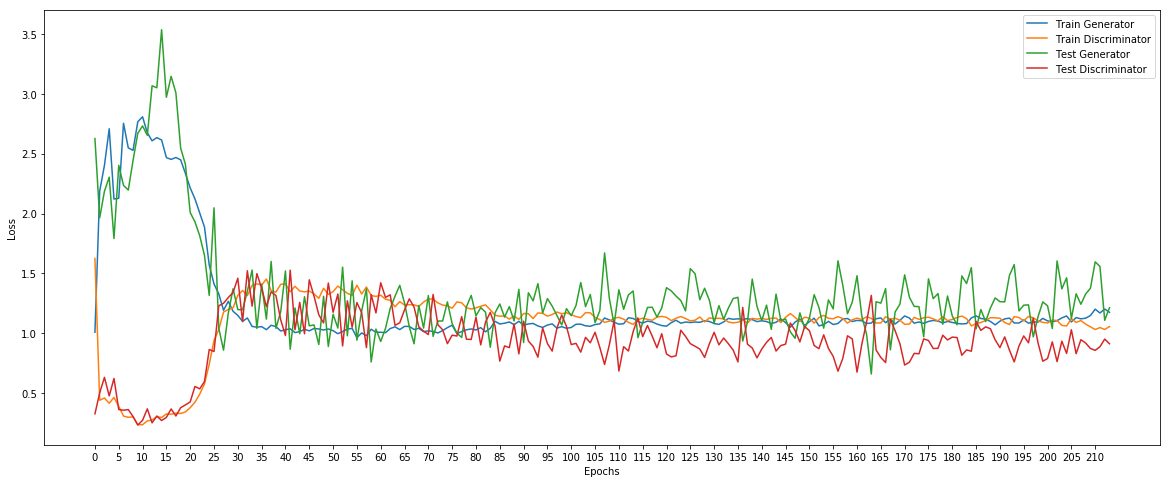

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,8))    
tr_gen, = ax.plot(train_gen_list, label='Train Generator')
tr_dsc, = ax.plot(train_dsc_list, label='Train Discriminator')
ts_gen, = ax.plot(test_gen_list, label='Test Generator')
ts_dsc, = ax.plot(test_dsc_list, label='Test Discriminator')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.xticks(np.arange(0, len(train_gen_list)+1, 5.0))

ax.legend([tr_gen, tr_dsc, ts_gen, ts_dsc], ['Train Generator','Train Discriminator', 'Test Generator', 'Test Discriminator'], loc = 'upper right')
plt.show()

### 학습 결과 출력

#### Load weight

재학습을 진행시켰을 때 기존의 로스와 결과가 도출되지 않아서 최종결과는 처음 학습에 저장하였던 로스를 이용하여 결과를 출력한다.

In [0]:
# Download weights zip file
link = 'https://drive.google.com/file/d/1ufDunikbKY-IFsnlsGhnI0LIa0cDpHFF'

# 웨이트 폴더 다운로드
file3 = drive.CreateFile({'id': link.split('/')[-1]})
print('Downloading file %s from Google Drive' % file3['title'])
file3.GetContentFile(file3['title'])  # Save Drive file as a local file

# 다운받은 웨이트 폴더 압축 해제
!unzip -o CGAN_214.zip

Archive:  CGAN_214.zip
  inflating: D_CGAN_E214.data-00000-of-00003  
   creating: __MACOSX/
  inflating: __MACOSX/._D_CGAN_E214.data-00000-of-00003  
  inflating: D_CGAN_E214.data-00001-of-00003  
  inflating: __MACOSX/._D_CGAN_E214.data-00001-of-00003  
  inflating: D_CGAN_E214.index       
  inflating: __MACOSX/._D_CGAN_E214.index  
  inflating: G_CGAN_E214.data-00000-of-00003  
  inflating: __MACOSX/._G_CGAN_E214.data-00000-of-00003  
  inflating: G_CGAN_E214.data-00001-of-00003  
  inflating: __MACOSX/._G_CGAN_E214.data-00001-of-00003  
  inflating: G_CGAN_E214.data-00002-of-00003  
  inflating: __MACOSX/._G_CGAN_E214.data-00002-of-00003  
  inflating: G_CGAN_E214.index       
  inflating: __MACOSX/._G_CGAN_E214.index  


#### Condition 별 생성 이미지 확인

주어진 조건에 맞게 이미지가 생성되는것을 확인 할 수 있다.

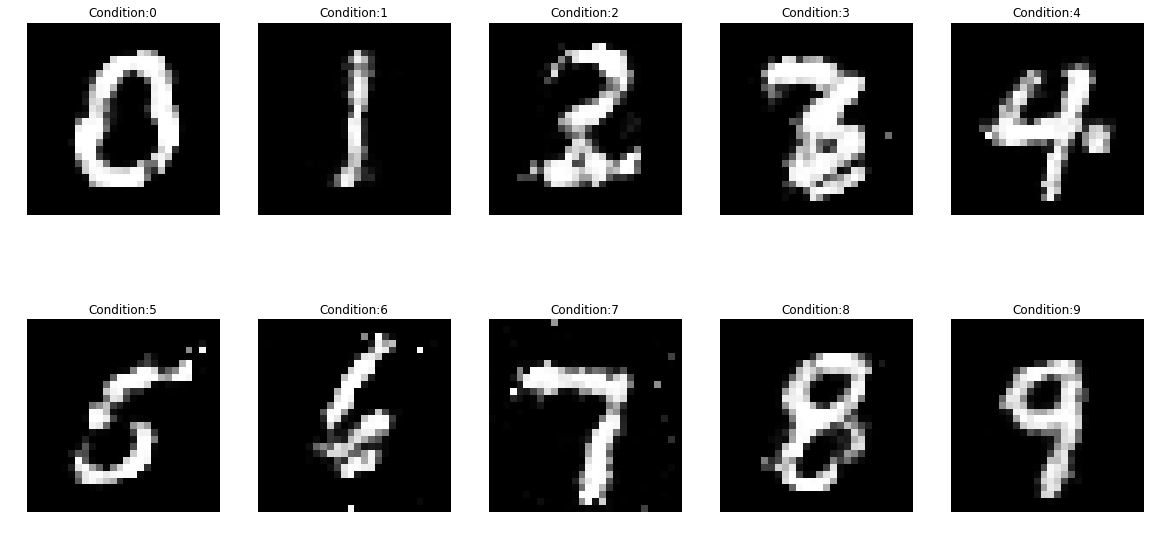

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

noises = tf.random.normal([10, 100])
condition = list(range(10))
cond_np = np.zeros([10,10]).astype(np.float32)

for i, cond in enumerate(condition):
    cond_np[i][cond] = 1.0
    
cond_tensor = tf.convert_to_tensor(cond_np, dtype=np.float32)

G.load_weights("G_CGAN_E214")
generated_image = G([noises, cond_tensor])

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,0].title.set_text("Condition:"+str(condition[0]))
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[0,1].title.set_text("Condition:"+str(condition[1]))
axes[0,2].imshow(generated_image[2], cmap='gray')
axes[0,2].title.set_text("Condition:"+str(condition[2]))
axes[0,3].imshow(generated_image[3], cmap='gray')
axes[0,3].title.set_text("Condition:"+str(condition[3]))
axes[0,4].imshow(generated_image[4], cmap='gray')
axes[0,4].title.set_text("Condition:"+str(condition[4]))

axes[1,0].imshow(generated_image[5], cmap='gray')
axes[1,0].title.set_text("Condition:"+str(condition[5]))
axes[1,1].imshow(generated_image[6], cmap='gray')
axes[1,1].title.set_text("Condition:"+str(condition[6]))
axes[1,2].imshow(generated_image[7], cmap='gray')
axes[1,2].title.set_text("Condition:"+str(condition[7]))
axes[1,3].imshow(generated_image[8], cmap='gray')
axes[1,3].title.set_text("Condition:"+str(condition[8]))
axes[1,4].imshow(generated_image[9], cmap='gray')
axes[1,4].title.set_text("Condition:"+str(condition[9]))

plt.show()

#### 훈련 과정에 따른 생성 이미지

Epoch 별로 저장한 이미지를 gif로 생성하여 추가하였다.
처음에는 노이즈였던 이미지가 점차 숫자의 모습을 갖추는 것을 확인 할 수 있다.

In [0]:
anim_file = 'cgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 3*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


![alt text](https://i.imgur.com/47OsoOe.gif)

## 4. Conditional GAN based on Convolutional layer


### Generator model with Convolutional layer

DCGAN을 참고하여 생성모델을 구현하였다. 
입력 값은 100차원의 노이즈와 10차원의 onehot encoding된 라벨을 concatenate 하여 사용한다.
입력된 데이터를 Dense 레이어를 이용하여 7\*7\*256만큼 확장하여 사용한다.
확장된 값을 Transpose Convolution layer를 이용하기 위해 3차원으로 변환한다.
한번의 특징 추출후 2번의 2배 확장을 통해서 원하는 이미지를 생성한다.

In [0]:
# Generator 모델 작성

x = layers.Input(shape=(100))
c_onehot = layers.Input(shape=(10))

inc1 = layers.Dense(7*7*256, use_bias=False)
BN1 = layers.BatchNormalization()
BN2 = layers.BatchNormalization()
BN3 = layers.BatchNormalization()
LReLU1 = layers.LeakyReLU()
LReLU2 = layers.LeakyReLU()
LReLU3 = layers.LeakyReLU()

conv2dT1 = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
conv2dT2 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
conv2dT3 = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

inputs = layers.concatenate([x, c_onehot], axis=1)

inc_x2 = LReLU1(BN1(inc1(inputs)))
x2 = layers.Reshape((7,7,256))(inc_x2)


x_gen2 = LReLU2(BN2(conv2dT1(x2)))
x_gen2 = LReLU3(BN3(conv2dT2(x_gen2)))
x_gen2 = conv2dT3(x_gen2)
conv_gen_data = layers.Reshape(target_shape=(28,28))(x_gen2)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 12544)        1379840     concatenate[0][0]            

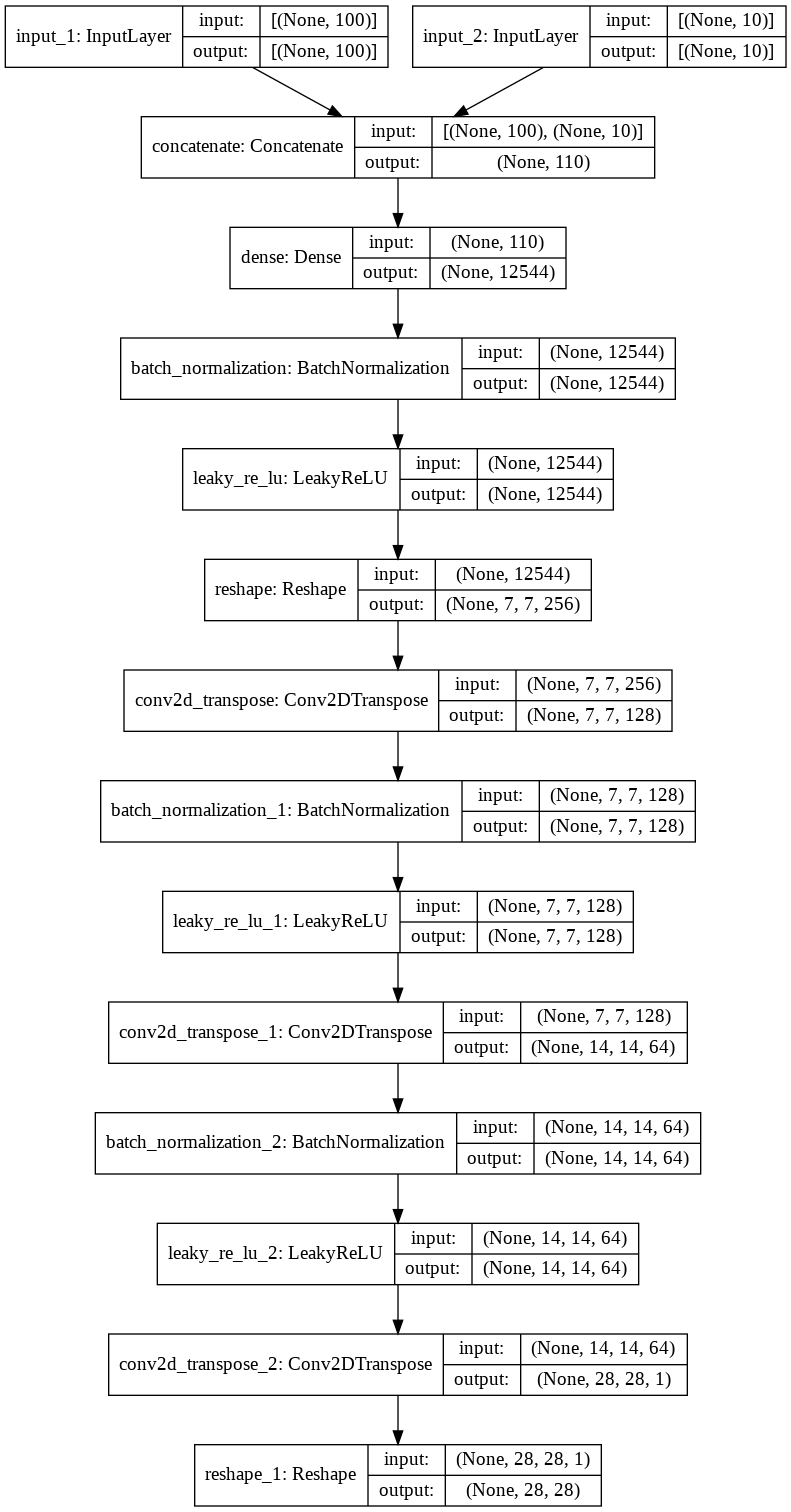

In [0]:
convG = models.Model([x, c_onehot], conv_gen_data)
convG.summary()
tf.keras.utils.plot_model(convG, 'convgenerator.png', show_shapes=True)

### Discriminator model with Convolutional layer

Generator model 과 반대로 2번의 Convolution layer 을 이용하여 실제 값인지 생성된 값인지 확인하는 네트워크를 구성한다.
입력 이미지에 각 픽셀별로 onehot encoding된 조건을 concatenate하여 사용한다.
각 convolution layer의 activation function 은 leaky relu를 사용하고 30%확률의 dropout을 이용하여 모델의 확장성을 더한다.

In [0]:
# Discriminator 모델 작성

raw_data = layers.Input(shape=(28,28))

c_onehot_img = layers.Input(shape=(28,28,10))

conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')

dsc_out = layers.Dense(1)

LReLU1 = layers.LeakyReLU()
LReLU2 = layers.LeakyReLU()

drop1 = layers.Dropout(0.3)
drop2 = layers.Dropout(0.3)

data = layers.Reshape(target_shape=(28,28,1))(raw_data)
inputs = layers.concatenate([data, c_onehot_img], axis=3)

x_dsc = drop1(LReLU1(conv1(inputs)))
x_dsc = drop2(LReLU2(conv2(inputs)))
x_dsc = layers.Flatten()(x_dsc)

dsc_result = dsc_out(x_dsc)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 28, 28, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 10)] 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 28, 28, 11)   0           reshape_2[0][0]                  
                                                                 input_4[0][0]              

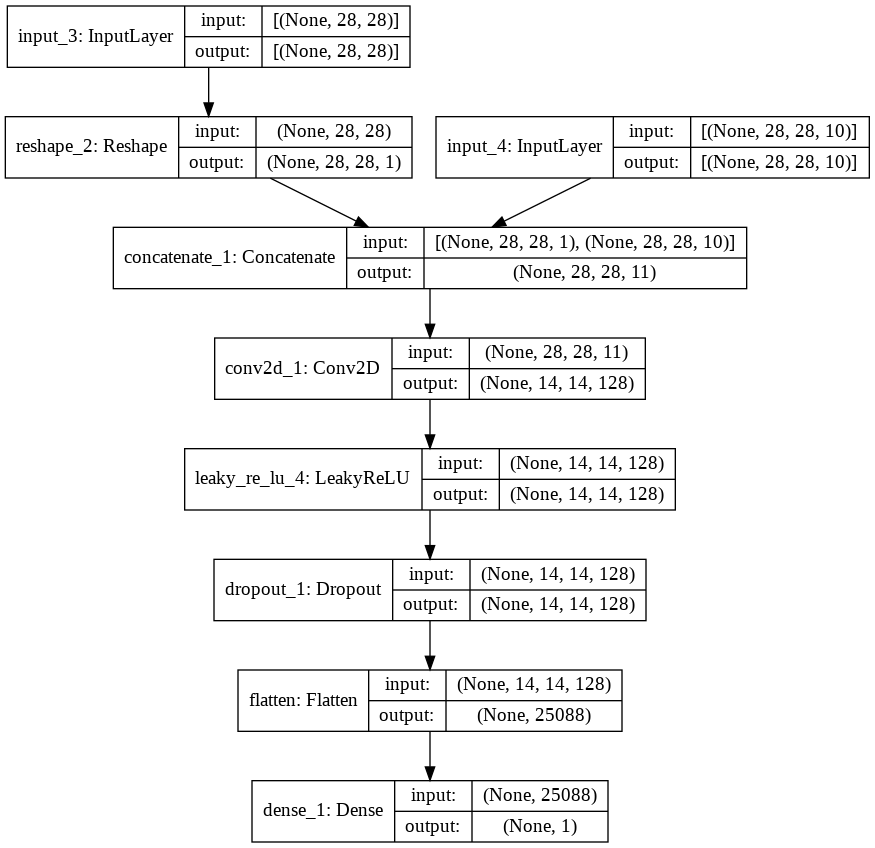

In [0]:
convD = models.Model([raw_data, c_onehot_img], dsc_result)
convD.summary()
tf.keras.utils.plot_model(convD, "convdiscriminator.png", show_shapes=True)

### Noise image Test

훈련 전 생성한 네트워들이 잘 동작하는지 확인해본다.

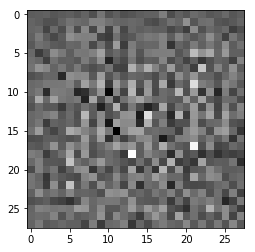

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = tf.random.normal([1, 100])
condition = 3
cond_np = np.zeros([1,10]).astype(np.float32)
cond_np[0][condition-1] = 1.0

cond_tensor = tf.convert_to_tensor(cond_np, dtype=np.float32)

fake_image_test = convG([test_noise, cond_tensor])
plt.imshow(fake_image_test[0], cmap='gray')

In [0]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
condition = 3
cond_np = np.zeros([1,10]).astype(np.float32)
cond_np[0][condition-1] = 1.0
cond_np = np.repeat(cond_np, 28*28). reshape((-1,num_classes,28,28)).transpose(0,2,3,1)
cond_tensor = tf.convert_to_tensor(cond_np, dtype=np.float32)

decision = convD([fake_image_test, cond_tensor])
print(decision)


tf.Tensor([[-0.02483153]], shape=(1, 1), dtype=float32)


### GAN 목적함수
GAN의 목적함수는 다음과 같다.

$$
\begin{align}
    \min_{G}\max_{D} V(G, D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$



In [0]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss
판별자 D 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최대화 문제를 풀고자 한다.
$$
\begin{align}
    \max_{D} V(D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(\mathbf{x}_{\textrm{fake}}))]
\end{align}
$$



In [0]:
# Discriminator loss 정의

def D_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#### Generator Loss
생성자 G 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최소화 문제를 풀고자 한다.
$$
\begin{align}
    \min_{G} V(G) = \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$

In [0]:
# Generator loss 정의

def G_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

#### 학습 파라미터 설정

Adam optimizer 를 사용하고 learning rate는 0.0001로 동일하게 설정한다.
여러번의 학습을 통해 최적의 결과를 찾기위해 300으로 설정하고 학습을 진행한다.
입력노이즈의 사이즈는 100으로 정한다.

In [0]:
# GAN 트레이닝에 쓰일 optimizer 정의

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)


In [0]:
# 학습 루프 설정

EPOCHS = 300
noise_dim = 100


### Train/Test function

실제로 연산을 진행하는 순서를 정하는 학습및 검증 함수를 작성한다.
train 함수 에서는 각 Epoch별로 조건별 생성결과를 저장하고 추후 그래프를 그리기위해서 로스값을 리스트에 저장한다.

In [0]:
# 배치단위 학습 함수 설정 (* AutoGraph 기능 쓰기!)

@tf.function
def train_step(real_images, condition, condition_img):  
  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])
  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
        fake_images = convG([noises,condition], training=True)
    
        real_output = convD([real_images, condition_img], training=True)
        fake_output = convD([fake_images, condition_img], training=True)

        gen_loss = G_loss(fake_output)
        dsc_loss = D_loss(real_output, fake_output)
    
    gen_gradients = gen_tape.gradient(gen_loss, convG.trainable_variables)
    dsc_gradients = dsc_tape.gradient(dsc_loss, convD.trainable_variables)
  
    G_optimizer.apply_gradients(zip(gen_gradients, convG.trainable_variables)) 
    D_optimizer.apply_gradients(zip(dsc_gradients, convD.trainable_variables))

    return gen_loss, dsc_loss
  

In [0]:
def test_step(real_images, condition, condition_img):  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])

    fake_images = convG([noises, condition], training=False)

    real_output = convD([real_images, condition_img], training=False)
    fake_output = convD([fake_images, condition_img], training=False)    

    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)

    print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())
    
    return gen_loss.numpy(), dsc_loss.numpy()

In [0]:
# Loss 저장 리스트
train_gen_list = []
train_dsc_list = []
test_gen_list = []
test_dsc_list = []

# 학습 함수
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        temp_train_gen = []
        temp_train_dsc = []
        for i, (image_batch, noise_cond, image_cond) in enumerate(dataset):
            train_gen_loss, train_dsc_loss = train_step(image_batch, noise_cond, image_cond)
            temp_train_gen.append(train_gen_loss.numpy())
            temp_train_dsc.append(train_dsc_loss.numpy())
            
            if i == BUFFER_SIZE//BATCH_SIZE-1:
                test_gen_loss, test_dsc_loss = test_step(image_batch, noise_cond, image_cond)
        
        train_gen_list.append(np.mean(np.asarray(temp_train_gen)))
        train_dsc_list.append(np.mean(np.asarray(temp_train_dsc)))
        test_gen_list.append(test_gen_loss)
        test_dsc_list.append(test_dsc_loss)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    
        
        
        import matplotlib.pyplot as plt

        noises = tf.random.normal([10, 100])
        test_cond = list(range(10))
        cond_np = np.zeros([10,10]).astype(np.float32)

        for i, cond in enumerate(test_cond):
            cond_np[i][cond] = 1.0
        
        cond_tensor = tf.convert_to_tensor(cond_np, dtype=np.float32)
        
        generated_image = convG([noises, cond_tensor])

        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

        for ax in axes.flat:
            ax.axis('off')

        axes[0,0].imshow(generated_image[0], cmap='gray')
        axes[0,0].title.set_text("Condition:"+str(test_cond[0]))
        axes[0,1].imshow(generated_image[1], cmap='gray')
        axes[0,1].title.set_text("Condition:"+str(test_cond[1]))
        axes[0,2].imshow(generated_image[2], cmap='gray')
        axes[0,2].title.set_text("Condition:"+str(test_cond[2]))
        axes[0,3].imshow(generated_image[3], cmap='gray')
        axes[0,3].title.set_text("Condition:"+str(test_cond[3]))
        axes[0,4].imshow(generated_image[4], cmap='gray')
        axes[0,4].title.set_text("Condition:"+str(test_cond[4]))

        axes[1,0].imshow(generated_image[5], cmap='gray')
        axes[1,0].title.set_text("Condition:"+str(test_cond[5]))
        axes[1,1].imshow(generated_image[6], cmap='gray')
        axes[1,1].title.set_text("Condition:"+str(test_cond[6]))
        axes[1,2].imshow(generated_image[7], cmap='gray')
        axes[1,2].title.set_text("Condition:"+str(test_cond[7]))
        axes[1,3].imshow(generated_image[8], cmap='gray')
        axes[1,3].title.set_text("Condition:"+str(test_cond[8]))
        axes[1,4].imshow(generated_image[9], cmap='gray')
        axes[1,4].title.set_text("Condition:"+str(test_cond[9]))

        plt.savefig('image_conv_at_epoch_{:04d}.png'.format(epoch))
        plt.close()
        
        checkpoint_name = "CCGAN_E"+str(epoch)
        convG.save_weights("G_"+checkpoint_name)
        convD.save_weights("D_"+checkpoint_name)
        
        # Google auth refresh
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)

        # Upload weights
        for f in glob.glob("*"+checkpoint_name+"*"):
            print("Upload file:",f)
            # Upload model
            model_file = drive.CreateFile({'title' : f})
            model_file.SetContentFile(f)
            model_file.Upload()
            
    return train_gen_list, train_dsc_list, test_gen_list, test_dsc_list

### Training

이미지와 loss의 변화를 확인하기위해서 모든 결과를 압축하여 구글드라이브에 업로드한다.

In [0]:
# 학습!!!
%%time
total_train_gen_list, total_train_dsc_list, total_test_gen_list, total_test_dsc_list = train(train_dataset, EPOCHS)

import pickle
total_train_gen_list, total_train_dsc_list, total_test_gen_list, total_test_dsc_list
with open('conv_train_gen_loss.pkl', 'wb') as f:
    pickle.dump(total_train_gen_list, f)
with open('conv_train_dsc_loss.pkl', 'wb') as f:
    pickle.dump(total_train_dsc_list, f)
with open('conv_test_gen_loss.pkl', 'wb') as f:
    pickle.dump(total_test_gen_list, f)
with open('conv_test_dsc_loss.pkl', 'wb') as f:
    pickle.dump(total_test_dsc_list, f)

!zip loss_data.zip *.pkl
# Google auth refresh
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print("Upload file:",'loss_data.zip')
# Upload loss data
model_file = drive.CreateFile({'title' : 'loss_data.zip'})
model_file.SetContentFile('loss_data.zip')
model_file.Upload()

Generator loss: 1.66297 Discriminator loss: 0.8637333
Time for epoch 1 is 19.0730082988739 sec


W0424 14:40:26.502585 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E0.data-00002-of-00003
Upload file: G_CCGAN_E0.index
Upload file: D_CCGAN_E0.index
Upload file: D_CCGAN_E0.data-00000-of-00003
Upload file: D_CCGAN_E0.data-00001-of-00003
Upload file: G_CCGAN_E0.data-00000-of-00003
Upload file: D_CCGAN_E0.data-00002-of-00003
Upload file: G_CCGAN_E0.data-00001-of-00003
Generator loss: 0.3987867 Discriminator loss: 1.8599359
Time for epoch 2 is 19.19017767906189 sec


W0424 14:40:55.104898 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E1.data-00000-of-00003
Upload file: D_CCGAN_E1.data-00001-of-00003
Upload file: D_CCGAN_E1.data-00002-of-00003
Upload file: G_CCGAN_E1.data-00002-of-00003
Upload file: G_CCGAN_E1.data-00000-of-00003
Upload file: G_CCGAN_E1.index
Upload file: G_CCGAN_E1.data-00001-of-00003
Upload file: D_CCGAN_E1.index
Generator loss: 0.64917135 Discriminator loss: 1.5597878
Time for epoch 3 is 21.320047855377197 sec


W0424 14:41:25.452578 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E2.data-00002-of-00003
Upload file: D_CCGAN_E2.data-00000-of-00003
Upload file: G_CCGAN_E2.data-00000-of-00003
Upload file: G_CCGAN_E2.index
Upload file: G_CCGAN_E2.data-00002-of-00003
Upload file: D_CCGAN_E2.data-00001-of-00003
Upload file: G_CCGAN_E2.data-00001-of-00003
Upload file: D_CCGAN_E2.index
Generator loss: 0.7116666 Discriminator loss: 1.4294205
Time for epoch 4 is 19.543396472930908 sec


W0424 14:41:53.233528 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E3.data-00002-of-00003
Upload file: D_CCGAN_E3.data-00000-of-00003
Upload file: G_CCGAN_E3.index
Upload file: D_CCGAN_E3.data-00001-of-00003
Upload file: D_CCGAN_E3.index
Upload file: G_CCGAN_E3.data-00000-of-00003
Upload file: G_CCGAN_E3.data-00002-of-00003
Upload file: G_CCGAN_E3.data-00001-of-00003
Generator loss: 0.58830047 Discriminator loss: 1.2682246
Time for epoch 5 is 17.685537576675415 sec


W0424 14:42:19.736730 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E4.data-00002-of-00003
Upload file: G_CCGAN_E4.data-00002-of-00003
Upload file: D_CCGAN_E4.data-00000-of-00003
Upload file: G_CCGAN_E4.data-00000-of-00003
Upload file: G_CCGAN_E4.data-00001-of-00003
Upload file: D_CCGAN_E4.data-00001-of-00003
Upload file: G_CCGAN_E4.index
Upload file: D_CCGAN_E4.index
Generator loss: 0.795844 Discriminator loss: 1.3161027
Time for epoch 6 is 20.619619131088257 sec


W0424 14:42:48.898259 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E5.data-00000-of-00003
Upload file: D_CCGAN_E5.data-00002-of-00003
Upload file: D_CCGAN_E5.data-00001-of-00003
Upload file: D_CCGAN_E5.index
Upload file: D_CCGAN_E5.data-00000-of-00003
Upload file: G_CCGAN_E5.data-00002-of-00003
Upload file: G_CCGAN_E5.index
Upload file: G_CCGAN_E5.data-00001-of-00003
Generator loss: 0.7342155 Discriminator loss: 1.3351419
Time for epoch 7 is 19.8052499294281 sec


W0424 14:43:17.672141 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E6.data-00002-of-00003
Upload file: G_CCGAN_E6.index
Upload file: D_CCGAN_E6.index
Upload file: D_CCGAN_E6.data-00000-of-00003
Upload file: D_CCGAN_E6.data-00002-of-00003
Upload file: D_CCGAN_E6.data-00001-of-00003
Upload file: G_CCGAN_E6.data-00000-of-00003
Upload file: G_CCGAN_E6.data-00001-of-00003
Generator loss: 0.600158 Discriminator loss: 1.5402588
Time for epoch 8 is 17.75937795639038 sec


W0424 14:43:44.509230 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E7.data-00002-of-00003
Upload file: D_CCGAN_E7.data-00001-of-00003
Upload file: G_CCGAN_E7.data-00001-of-00003
Upload file: G_CCGAN_E7.index
Upload file: G_CCGAN_E7.data-00000-of-00003
Upload file: D_CCGAN_E7.index
Upload file: D_CCGAN_E7.data-00000-of-00003
Upload file: D_CCGAN_E7.data-00002-of-00003
Generator loss: 0.6370457 Discriminator loss: 1.5204146
Time for epoch 9 is 18.535561561584473 sec


W0424 14:44:11.188098 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E8.data-00000-of-00003
Upload file: G_CCGAN_E8.index
Upload file: D_CCGAN_E8.data-00002-of-00003
Upload file: D_CCGAN_E8.data-00000-of-00003
Upload file: D_CCGAN_E8.data-00001-of-00003
Upload file: G_CCGAN_E8.data-00002-of-00003
Upload file: G_CCGAN_E8.data-00001-of-00003
Upload file: D_CCGAN_E8.index
Generator loss: 0.43220222 Discriminator loss: 1.9779167
Time for epoch 10 is 17.853071689605713 sec


W0424 14:44:38.256686 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E9.data-00001-of-00003
Upload file: D_CCGAN_E9.data-00001-of-00003
Upload file: G_CCGAN_E9.data-00002-of-00003
Upload file: G_CCGAN_E9.index
Upload file: D_CCGAN_E9.index
Upload file: D_CCGAN_E9.data-00000-of-00003
Upload file: G_CCGAN_E9.data-00000-of-00003
Upload file: D_CCGAN_E9.data-00002-of-00003
Generator loss: 0.8838616 Discriminator loss: 1.0840981
Time for epoch 11 is 17.842254877090454 sec


W0424 14:45:04.173439 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E10.data-00001-of-00003
Upload file: G_CCGAN_E10.index
Upload file: G_CCGAN_E10.data-00001-of-00003
Upload file: G_CCGAN_E10.data-00000-of-00003
Upload file: D_CCGAN_E10.data-00000-of-00003
Upload file: D_CCGAN_E10.data-00002-of-00003
Upload file: G_CCGAN_E10.data-00002-of-00003
Upload file: D_CCGAN_E10.index
Generator loss: 0.7237852 Discriminator loss: 1.4051588
Time for epoch 12 is 18.581565856933594 sec


W0424 14:45:31.736744 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E11.data-00001-of-00003
Upload file: G_CCGAN_E11.data-00002-of-00003
Upload file: D_CCGAN_E11.index
Upload file: D_CCGAN_E11.data-00000-of-00003
Upload file: G_CCGAN_E11.data-00001-of-00003
Upload file: D_CCGAN_E11.data-00002-of-00003
Upload file: G_CCGAN_E11.index
Upload file: G_CCGAN_E11.data-00000-of-00003
Generator loss: 0.92427015 Discriminator loss: 1.1985931
Time for epoch 13 is 18.018988132476807 sec


W0424 14:45:57.215971 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E12.data-00001-of-00003
Upload file: G_CCGAN_E12.data-00000-of-00003
Upload file: D_CCGAN_E12.data-00002-of-00003
Upload file: D_CCGAN_E12.index
Upload file: D_CCGAN_E12.data-00000-of-00003
Upload file: G_CCGAN_E12.data-00002-of-00003
Upload file: D_CCGAN_E12.data-00001-of-00003
Upload file: G_CCGAN_E12.index
Generator loss: 0.67119324 Discriminator loss: 1.7340618
Time for epoch 14 is 20.379884958267212 sec


W0424 14:46:26.125851 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E13.data-00000-of-00003
Upload file: G_CCGAN_E13.data-00000-of-00003
Upload file: G_CCGAN_E13.data-00002-of-00003
Upload file: D_CCGAN_E13.data-00002-of-00003
Upload file: G_CCGAN_E13.data-00001-of-00003
Upload file: G_CCGAN_E13.index
Upload file: D_CCGAN_E13.data-00001-of-00003
Upload file: D_CCGAN_E13.index
Generator loss: 0.8425866 Discriminator loss: 1.4078851
Time for epoch 15 is 18.64342761039734 sec


W0424 14:46:53.270694 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E14.data-00000-of-00003
Upload file: D_CCGAN_E14.data-00002-of-00003
Upload file: G_CCGAN_E14.index
Upload file: D_CCGAN_E14.data-00000-of-00003
Upload file: D_CCGAN_E14.data-00001-of-00003
Upload file: G_CCGAN_E14.data-00002-of-00003
Upload file: G_CCGAN_E14.data-00001-of-00003
Upload file: D_CCGAN_E14.index
Generator loss: 0.8786828 Discriminator loss: 1.2385552
Time for epoch 16 is 18.041298627853394 sec


W0424 14:47:19.788386 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E15.data-00000-of-00003
Upload file: D_CCGAN_E15.data-00001-of-00003
Upload file: G_CCGAN_E15.data-00001-of-00003
Upload file: D_CCGAN_E15.data-00002-of-00003
Upload file: G_CCGAN_E15.index
Upload file: D_CCGAN_E15.index
Upload file: G_CCGAN_E15.data-00002-of-00003
Upload file: D_CCGAN_E15.data-00000-of-00003
Generator loss: 1.0857179 Discriminator loss: 0.9320106
Time for epoch 17 is 18.09708070755005 sec


W0424 14:47:45.746901 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E16.data-00001-of-00003
Upload file: G_CCGAN_E16.data-00000-of-00003
Upload file: D_CCGAN_E16.data-00001-of-00003
Upload file: D_CCGAN_E16.data-00002-of-00003
Upload file: G_CCGAN_E16.data-00002-of-00003
Upload file: D_CCGAN_E16.data-00000-of-00003
Upload file: D_CCGAN_E16.index
Upload file: G_CCGAN_E16.index
Generator loss: 0.9816841 Discriminator loss: 1.1175891
Time for epoch 18 is 18.66602873802185 sec


W0424 14:48:12.681153 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E17.data-00002-of-00003
Upload file: G_CCGAN_E17.data-00000-of-00003
Upload file: D_CCGAN_E17.data-00000-of-00003
Upload file: D_CCGAN_E17.data-00001-of-00003
Upload file: D_CCGAN_E17.index
Upload file: G_CCGAN_E17.index
Upload file: G_CCGAN_E17.data-00002-of-00003
Upload file: G_CCGAN_E17.data-00001-of-00003
Generator loss: 0.74127233 Discriminator loss: 1.3250897
Time for epoch 19 is 18.116644859313965 sec


W0424 14:48:39.492924 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E18.index
Upload file: D_CCGAN_E18.data-00000-of-00003
Upload file: G_CCGAN_E18.data-00000-of-00003
Upload file: G_CCGAN_E18.index
Upload file: D_CCGAN_E18.data-00001-of-00003
Upload file: G_CCGAN_E18.data-00001-of-00003
Upload file: G_CCGAN_E18.data-00002-of-00003
Upload file: D_CCGAN_E18.data-00002-of-00003
Generator loss: 0.8080909 Discriminator loss: 1.2772444
Time for epoch 20 is 18.173369646072388 sec


W0424 14:49:05.267661 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E19.data-00002-of-00003
Upload file: D_CCGAN_E19.data-00000-of-00003
Upload file: D_CCGAN_E19.index
Upload file: G_CCGAN_E19.data-00000-of-00003
Upload file: D_CCGAN_E19.data-00001-of-00003
Upload file: G_CCGAN_E19.data-00002-of-00003
Upload file: G_CCGAN_E19.index
Upload file: G_CCGAN_E19.data-00001-of-00003
Generator loss: 0.90425223 Discriminator loss: 1.289636
Time for epoch 21 is 18.685713529586792 sec


W0424 14:49:32.187455 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E20.index
Upload file: D_CCGAN_E20.data-00000-of-00003
Upload file: G_CCGAN_E20.index
Upload file: G_CCGAN_E20.data-00000-of-00003
Upload file: D_CCGAN_E20.data-00001-of-00003
Upload file: D_CCGAN_E20.data-00002-of-00003
Upload file: G_CCGAN_E20.data-00002-of-00003
Upload file: G_CCGAN_E20.data-00001-of-00003
Generator loss: 0.89292306 Discriminator loss: 1.2192273
Time for epoch 22 is 19.701374292373657 sec


W0424 14:49:59.644269 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E21.data-00000-of-00003
Upload file: D_CCGAN_E21.data-00002-of-00003
Upload file: G_CCGAN_E21.data-00002-of-00003
Upload file: G_CCGAN_E21.index
Upload file: D_CCGAN_E21.data-00000-of-00003
Upload file: D_CCGAN_E21.data-00001-of-00003
Upload file: D_CCGAN_E21.index
Upload file: G_CCGAN_E21.data-00001-of-00003
Generator loss: 0.75146955 Discriminator loss: 1.3219956
Time for epoch 23 is 18.029345512390137 sec


W0424 14:50:25.582353 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E22.data-00001-of-00003
Upload file: G_CCGAN_E22.data-00000-of-00003
Upload file: D_CCGAN_E22.data-00000-of-00003
Upload file: G_CCGAN_E22.index
Upload file: D_CCGAN_E22.index
Upload file: G_CCGAN_E22.data-00001-of-00003
Upload file: D_CCGAN_E22.data-00002-of-00003
Upload file: G_CCGAN_E22.data-00002-of-00003
Generator loss: 0.900336 Discriminator loss: 1.1867721
Time for epoch 24 is 18.70501470565796 sec


W0424 14:50:52.162947 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E23.data-00001-of-00003
Upload file: G_CCGAN_E23.data-00002-of-00003
Upload file: D_CCGAN_E23.index
Upload file: G_CCGAN_E23.data-00000-of-00003
Upload file: G_CCGAN_E23.index
Upload file: D_CCGAN_E23.data-00000-of-00003
Upload file: G_CCGAN_E23.data-00001-of-00003
Upload file: D_CCGAN_E23.data-00002-of-00003
Generator loss: 0.69252264 Discriminator loss: 1.4265224
Time for epoch 25 is 18.1779363155365 sec


W0424 14:51:18.789936 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E24.data-00000-of-00003
Upload file: G_CCGAN_E24.data-00001-of-00003
Upload file: G_CCGAN_E24.data-00002-of-00003
Upload file: D_CCGAN_E24.data-00001-of-00003
Upload file: G_CCGAN_E24.index
Upload file: D_CCGAN_E24.index
Upload file: G_CCGAN_E24.data-00000-of-00003
Upload file: D_CCGAN_E24.data-00002-of-00003
Generator loss: 0.7314284 Discriminator loss: 1.292475
Time for epoch 26 is 18.095625400543213 sec


W0424 14:51:45.311392 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E25.data-00000-of-00003
Upload file: G_CCGAN_E25.data-00002-of-00003
Upload file: D_CCGAN_E25.index
Upload file: D_CCGAN_E25.data-00000-of-00003
Upload file: D_CCGAN_E25.data-00001-of-00003
Upload file: G_CCGAN_E25.index
Upload file: G_CCGAN_E25.data-00001-of-00003
Upload file: D_CCGAN_E25.data-00002-of-00003
Generator loss: 0.6509835 Discriminator loss: 1.4780322
Time for epoch 27 is 18.60432004928589 sec


W0424 14:52:11.823887 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E26.data-00000-of-00003
Upload file: D_CCGAN_E26.data-00001-of-00003
Upload file: D_CCGAN_E26.data-00000-of-00003
Upload file: G_CCGAN_E26.data-00001-of-00003
Upload file: G_CCGAN_E26.data-00002-of-00003
Upload file: G_CCGAN_E26.index
Upload file: D_CCGAN_E26.data-00002-of-00003
Upload file: D_CCGAN_E26.index
Generator loss: 0.88017654 Discriminator loss: 1.1308098
Time for epoch 28 is 18.040498971939087 sec


W0424 14:52:38.305400 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E27.index
Upload file: G_CCGAN_E27.data-00001-of-00003
Upload file: D_CCGAN_E27.data-00001-of-00003
Upload file: D_CCGAN_E27.data-00002-of-00003
Upload file: D_CCGAN_E27.index
Upload file: D_CCGAN_E27.data-00000-of-00003
Upload file: G_CCGAN_E27.data-00002-of-00003
Upload file: G_CCGAN_E27.data-00000-of-00003
Generator loss: 0.724184 Discriminator loss: 1.3612772
Time for epoch 29 is 18.61092972755432 sec


W0424 14:53:04.890151 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E28.data-00002-of-00003
Upload file: D_CCGAN_E28.index
Upload file: G_CCGAN_E28.data-00001-of-00003
Upload file: G_CCGAN_E28.index
Upload file: D_CCGAN_E28.data-00001-of-00003
Upload file: D_CCGAN_E28.data-00000-of-00003
Upload file: G_CCGAN_E28.data-00000-of-00003
Upload file: G_CCGAN_E28.data-00002-of-00003
Generator loss: 0.79372287 Discriminator loss: 1.2656784
Time for epoch 30 is 18.493228912353516 sec


W0424 14:53:31.700156 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E29.index
Upload file: D_CCGAN_E29.data-00000-of-00003
Upload file: D_CCGAN_E29.data-00001-of-00003
Upload file: G_CCGAN_E29.data-00001-of-00003
Upload file: G_CCGAN_E29.data-00002-of-00003
Upload file: G_CCGAN_E29.index
Upload file: D_CCGAN_E29.data-00002-of-00003
Upload file: G_CCGAN_E29.data-00000-of-00003
Generator loss: 0.86096764 Discriminator loss: 1.1633925
Time for epoch 31 is 18.088809728622437 sec


W0424 14:53:57.109150 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E30.index
Upload file: G_CCGAN_E30.data-00001-of-00003
Upload file: G_CCGAN_E30.data-00000-of-00003
Upload file: D_CCGAN_E30.data-00001-of-00003
Upload file: D_CCGAN_E30.data-00002-of-00003
Upload file: D_CCGAN_E30.index
Upload file: D_CCGAN_E30.data-00000-of-00003
Upload file: G_CCGAN_E30.data-00002-of-00003
Generator loss: 0.7723808 Discriminator loss: 1.26046
Time for epoch 32 is 17.976963996887207 sec


W0424 14:54:22.423994 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E31.data-00000-of-00003
Upload file: D_CCGAN_E31.data-00000-of-00003
Upload file: G_CCGAN_E31.index
Upload file: G_CCGAN_E31.data-00002-of-00003
Upload file: D_CCGAN_E31.data-00001-of-00003
Upload file: G_CCGAN_E31.data-00001-of-00003
Upload file: D_CCGAN_E31.index
Upload file: D_CCGAN_E31.data-00002-of-00003
Generator loss: 0.792283 Discriminator loss: 1.299041
Time for epoch 33 is 18.314990997314453 sec


W0424 14:54:48.936595 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E32.index
Upload file: G_CCGAN_E32.data-00000-of-00003
Upload file: D_CCGAN_E32.data-00001-of-00003
Upload file: G_CCGAN_E32.data-00001-of-00003
Upload file: D_CCGAN_E32.data-00002-of-00003
Upload file: D_CCGAN_E32.data-00000-of-00003
Upload file: D_CCGAN_E32.index
Upload file: G_CCGAN_E32.data-00002-of-00003
Generator loss: 0.76668096 Discriminator loss: 1.2585819
Time for epoch 34 is 18.086552619934082 sec


W0424 14:55:14.758762 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E33.data-00001-of-00003
Upload file: G_CCGAN_E33.index
Upload file: D_CCGAN_E33.data-00002-of-00003
Upload file: D_CCGAN_E33.index
Upload file: D_CCGAN_E33.data-00000-of-00003
Upload file: G_CCGAN_E33.data-00001-of-00003
Upload file: G_CCGAN_E33.data-00000-of-00003
Upload file: G_CCGAN_E33.data-00002-of-00003
Generator loss: 0.7569874 Discriminator loss: 1.3505441
Time for epoch 35 is 19.51284146308899 sec


W0424 14:55:41.967661 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E34.data-00002-of-00003
Upload file: D_CCGAN_E34.index
Upload file: D_CCGAN_E34.data-00001-of-00003
Upload file: G_CCGAN_E34.index
Upload file: G_CCGAN_E34.data-00000-of-00003
Upload file: D_CCGAN_E34.data-00002-of-00003
Upload file: G_CCGAN_E34.data-00001-of-00003
Upload file: D_CCGAN_E34.data-00000-of-00003
Generator loss: 0.7465862 Discriminator loss: 1.285988
Time for epoch 36 is 18.21810793876648 sec


W0424 14:56:08.090314 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E35.data-00000-of-00003
Upload file: G_CCGAN_E35.index
Upload file: D_CCGAN_E35.data-00001-of-00003
Upload file: G_CCGAN_E35.data-00001-of-00003
Upload file: G_CCGAN_E35.data-00002-of-00003
Upload file: D_CCGAN_E35.data-00002-of-00003
Upload file: D_CCGAN_E35.index
Upload file: G_CCGAN_E35.data-00000-of-00003
Generator loss: 0.8794678 Discriminator loss: 1.1805468
Time for epoch 37 is 18.32478904724121 sec


W0424 14:56:34.188948 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E36.data-00001-of-00003
Upload file: G_CCGAN_E36.data-00001-of-00003
Upload file: G_CCGAN_E36.data-00000-of-00003
Upload file: G_CCGAN_E36.data-00002-of-00003
Upload file: G_CCGAN_E36.index
Upload file: D_CCGAN_E36.index
Upload file: D_CCGAN_E36.data-00002-of-00003
Upload file: D_CCGAN_E36.data-00000-of-00003
Generator loss: 0.98125434 Discriminator loss: 1.0870031
Time for epoch 38 is 18.199617624282837 sec


W0424 14:56:59.902188 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E37.index
Upload file: D_CCGAN_E37.data-00000-of-00003
Upload file: D_CCGAN_E37.data-00001-of-00003
Upload file: G_CCGAN_E37.data-00000-of-00003
Upload file: G_CCGAN_E37.data-00002-of-00003
Upload file: D_CCGAN_E37.index
Upload file: G_CCGAN_E37.data-00001-of-00003
Upload file: D_CCGAN_E37.data-00002-of-00003
Generator loss: 0.80979073 Discriminator loss: 1.248225
Time for epoch 39 is 18.449159145355225 sec


W0424 14:57:26.268914 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E38.data-00001-of-00003
Upload file: G_CCGAN_E38.data-00002-of-00003
Upload file: D_CCGAN_E38.data-00000-of-00003
Upload file: G_CCGAN_E38.index
Upload file: D_CCGAN_E38.data-00002-of-00003
Upload file: D_CCGAN_E38.data-00001-of-00003
Upload file: G_CCGAN_E38.data-00000-of-00003
Upload file: D_CCGAN_E38.index
Generator loss: 0.7060914 Discriminator loss: 1.3631542
Time for epoch 40 is 18.398813247680664 sec


W0424 14:57:52.243253 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E39.data-00002-of-00003
Upload file: G_CCGAN_E39.data-00001-of-00003
Upload file: D_CCGAN_E39.data-00001-of-00003
Upload file: G_CCGAN_E39.index
Upload file: G_CCGAN_E39.data-00002-of-00003
Upload file: D_CCGAN_E39.data-00000-of-00003
Upload file: G_CCGAN_E39.data-00000-of-00003
Upload file: D_CCGAN_E39.index
Generator loss: 0.829171 Discriminator loss: 1.2473413
Time for epoch 41 is 18.357030391693115 sec


W0424 14:58:19.132738 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E40.index
Upload file: D_CCGAN_E40.index
Upload file: D_CCGAN_E40.data-00001-of-00003
Upload file: G_CCGAN_E40.data-00000-of-00003
Upload file: D_CCGAN_E40.data-00002-of-00003
Upload file: D_CCGAN_E40.data-00000-of-00003
Upload file: G_CCGAN_E40.data-00001-of-00003
Upload file: G_CCGAN_E40.data-00002-of-00003
Generator loss: 0.87346894 Discriminator loss: 1.175504
Time for epoch 42 is 18.448795318603516 sec


W0424 14:58:45.988010 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E41.data-00002-of-00003
Upload file: D_CCGAN_E41.data-00002-of-00003
Upload file: G_CCGAN_E41.data-00001-of-00003
Upload file: G_CCGAN_E41.index
Upload file: D_CCGAN_E41.data-00000-of-00003
Upload file: G_CCGAN_E41.data-00000-of-00003
Upload file: D_CCGAN_E41.data-00001-of-00003
Upload file: D_CCGAN_E41.index
Generator loss: 0.84413165 Discriminator loss: 1.213748
Time for epoch 43 is 18.393959999084473 sec


W0424 14:59:12.206031 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E42.index
Upload file: D_CCGAN_E42.data-00000-of-00003
Upload file: G_CCGAN_E42.data-00002-of-00003
Upload file: G_CCGAN_E42.data-00000-of-00003
Upload file: D_CCGAN_E42.data-00002-of-00003
Upload file: D_CCGAN_E42.index
Upload file: D_CCGAN_E42.data-00001-of-00003
Upload file: G_CCGAN_E42.data-00001-of-00003
Generator loss: 0.90085375 Discriminator loss: 1.161281
Time for epoch 44 is 18.405670642852783 sec


W0424 14:59:37.996259 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E43.data-00002-of-00003
Upload file: D_CCGAN_E43.index
Upload file: G_CCGAN_E43.index
Upload file: D_CCGAN_E43.data-00000-of-00003
Upload file: G_CCGAN_E43.data-00000-of-00003
Upload file: D_CCGAN_E43.data-00001-of-00003
Upload file: G_CCGAN_E43.data-00001-of-00003
Upload file: G_CCGAN_E43.data-00002-of-00003
Generator loss: 0.7745561 Discriminator loss: 1.3315896
Time for epoch 45 is 18.592896461486816 sec


W0424 15:00:04.680148 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E44.data-00002-of-00003
Upload file: G_CCGAN_E44.data-00002-of-00003
Upload file: D_CCGAN_E44.data-00001-of-00003
Upload file: G_CCGAN_E44.data-00001-of-00003
Upload file: G_CCGAN_E44.data-00000-of-00003
Upload file: D_CCGAN_E44.data-00000-of-00003
Upload file: G_CCGAN_E44.index
Upload file: D_CCGAN_E44.index
Generator loss: 0.9178567 Discriminator loss: 1.1223109
Time for epoch 46 is 19.80263590812683 sec


W0424 15:00:32.479438 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E45.index
Upload file: D_CCGAN_E45.index
Upload file: D_CCGAN_E45.data-00002-of-00003
Upload file: G_CCGAN_E45.data-00002-of-00003
Upload file: G_CCGAN_E45.data-00000-of-00003
Upload file: D_CCGAN_E45.data-00000-of-00003
Upload file: G_CCGAN_E45.data-00001-of-00003
Upload file: D_CCGAN_E45.data-00001-of-00003
Generator loss: 0.9150919 Discriminator loss: 1.1060948
Time for epoch 47 is 18.418079614639282 sec


W0424 15:00:58.655276 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E46.data-00002-of-00003
Upload file: G_CCGAN_E46.data-00001-of-00003
Upload file: D_CCGAN_E46.data-00000-of-00003
Upload file: D_CCGAN_E46.index
Upload file: D_CCGAN_E46.data-00001-of-00003
Upload file: G_CCGAN_E46.index
Upload file: D_CCGAN_E46.data-00002-of-00003
Upload file: G_CCGAN_E46.data-00000-of-00003
Generator loss: 0.9250925 Discriminator loss: 1.1342452
Time for epoch 48 is 18.43670129776001 sec


W0424 15:01:24.734370 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E47.index
Upload file: G_CCGAN_E47.data-00001-of-00003
Upload file: G_CCGAN_E47.data-00000-of-00003
Upload file: D_CCGAN_E47.data-00001-of-00003
Upload file: D_CCGAN_E47.data-00002-of-00003
Upload file: G_CCGAN_E47.data-00002-of-00003
Upload file: D_CCGAN_E47.data-00000-of-00003
Upload file: D_CCGAN_E47.index
Generator loss: 0.71402204 Discriminator loss: 1.3285162
Time for epoch 49 is 19.01389980316162 sec


W0424 15:01:51.957670 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E48.data-00001-of-00003
Upload file: D_CCGAN_E48.data-00000-of-00003
Upload file: G_CCGAN_E48.data-00002-of-00003
Upload file: G_CCGAN_E48.data-00000-of-00003
Upload file: G_CCGAN_E48.index
Upload file: D_CCGAN_E48.index
Upload file: D_CCGAN_E48.data-00002-of-00003
Upload file: G_CCGAN_E48.data-00001-of-00003
Generator loss: 0.7787612 Discriminator loss: 1.3761911
Time for epoch 50 is 18.364310026168823 sec


W0424 15:02:18.967255 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E49.data-00001-of-00003
Upload file: G_CCGAN_E49.data-00002-of-00003
Upload file: D_CCGAN_E49.data-00001-of-00003
Upload file: D_CCGAN_E49.index
Upload file: D_CCGAN_E49.data-00002-of-00003
Upload file: G_CCGAN_E49.data-00000-of-00003
Upload file: G_CCGAN_E49.index
Upload file: D_CCGAN_E49.data-00000-of-00003
Generator loss: 0.8097431 Discriminator loss: 1.3208945
Time for epoch 51 is 18.512940406799316 sec


W0424 15:02:45.700915 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E50.index
Upload file: G_CCGAN_E50.data-00000-of-00003
Upload file: G_CCGAN_E50.data-00001-of-00003
Upload file: D_CCGAN_E50.data-00002-of-00003
Upload file: D_CCGAN_E50.data-00001-of-00003
Upload file: G_CCGAN_E50.data-00002-of-00003
Upload file: G_CCGAN_E50.index
Upload file: D_CCGAN_E50.data-00000-of-00003
Generator loss: 0.79380345 Discriminator loss: 1.2365477
Time for epoch 52 is 18.441833972930908 sec


W0424 15:03:11.910198 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E51.data-00000-of-00003
Upload file: D_CCGAN_E51.data-00002-of-00003
Upload file: D_CCGAN_E51.data-00000-of-00003
Upload file: D_CCGAN_E51.index
Upload file: G_CCGAN_E51.data-00002-of-00003
Upload file: G_CCGAN_E51.index
Upload file: G_CCGAN_E51.data-00001-of-00003
Upload file: D_CCGAN_E51.data-00001-of-00003
Generator loss: 0.7426728 Discriminator loss: 1.3853102
Time for epoch 53 is 18.45582103729248 sec


W0424 15:03:38.957803 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E52.data-00002-of-00003
Upload file: D_CCGAN_E52.data-00001-of-00003
Upload file: G_CCGAN_E52.index
Upload file: D_CCGAN_E52.index
Upload file: G_CCGAN_E52.data-00002-of-00003
Upload file: G_CCGAN_E52.data-00000-of-00003
Upload file: D_CCGAN_E52.data-00000-of-00003
Upload file: G_CCGAN_E52.data-00001-of-00003
Generator loss: 0.72351927 Discriminator loss: 1.3890154
Time for epoch 54 is 18.618805646896362 sec


W0424 15:04:05.505858 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E53.index
Upload file: D_CCGAN_E53.data-00000-of-00003
Upload file: G_CCGAN_E53.data-00000-of-00003
Upload file: G_CCGAN_E53.data-00001-of-00003
Upload file: D_CCGAN_E53.data-00002-of-00003
Upload file: G_CCGAN_E53.data-00002-of-00003
Upload file: D_CCGAN_E53.data-00001-of-00003
Upload file: G_CCGAN_E53.index
Generator loss: 0.7850096 Discriminator loss: 1.2375716
Time for epoch 55 is 19.831491947174072 sec


W0424 15:04:33.324838 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E54.data-00001-of-00003
Upload file: G_CCGAN_E54.data-00002-of-00003
Upload file: D_CCGAN_E54.index
Upload file: D_CCGAN_E54.data-00002-of-00003
Upload file: D_CCGAN_E54.data-00000-of-00003
Upload file: G_CCGAN_E54.index
Upload file: G_CCGAN_E54.data-00000-of-00003
Upload file: G_CCGAN_E54.data-00001-of-00003
Generator loss: 0.7020237 Discriminator loss: 1.3914688
Time for epoch 56 is 18.3978431224823 sec


W0424 15:04:59.945653 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E55.data-00002-of-00003
Upload file: G_CCGAN_E55.data-00002-of-00003
Upload file: G_CCGAN_E55.data-00001-of-00003
Upload file: G_CCGAN_E55.index
Upload file: D_CCGAN_E55.data-00001-of-00003
Upload file: G_CCGAN_E55.data-00000-of-00003
Upload file: D_CCGAN_E55.index
Upload file: D_CCGAN_E55.data-00000-of-00003
Generator loss: 0.7058654 Discriminator loss: 1.4281526
Time for epoch 57 is 18.47888469696045 sec


W0424 15:05:25.970108 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E56.data-00000-of-00003
Upload file: G_CCGAN_E56.data-00001-of-00003
Upload file: G_CCGAN_E56.index
Upload file: G_CCGAN_E56.data-00000-of-00003
Upload file: D_CCGAN_E56.index
Upload file: D_CCGAN_E56.data-00001-of-00003
Upload file: G_CCGAN_E56.data-00002-of-00003
Upload file: D_CCGAN_E56.data-00002-of-00003
Generator loss: 0.8995521 Discriminator loss: 1.2172856
Time for epoch 58 is 18.379068613052368 sec


W0424 15:05:52.866188 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E57.data-00002-of-00003
Upload file: D_CCGAN_E57.index
Upload file: D_CCGAN_E57.data-00001-of-00003
Upload file: G_CCGAN_E57.index
Upload file: G_CCGAN_E57.data-00002-of-00003
Upload file: D_CCGAN_E57.data-00000-of-00003
Upload file: G_CCGAN_E57.data-00000-of-00003
Upload file: G_CCGAN_E57.data-00001-of-00003
Generator loss: 0.8188318 Discriminator loss: 1.3174601
Time for epoch 59 is 18.34683394432068 sec


W0424 15:06:19.338206 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E58.data-00000-of-00003
Upload file: D_CCGAN_E58.data-00001-of-00003
Upload file: G_CCGAN_E58.index
Upload file: G_CCGAN_E58.data-00001-of-00003
Upload file: G_CCGAN_E58.data-00002-of-00003
Upload file: D_CCGAN_E58.data-00002-of-00003
Upload file: D_CCGAN_E58.index
Upload file: G_CCGAN_E58.data-00000-of-00003
Generator loss: 0.85313547 Discriminator loss: 1.2903962
Time for epoch 60 is 18.8398118019104 sec


W0424 15:06:46.141632 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E59.index
Upload file: G_CCGAN_E59.data-00000-of-00003
Upload file: D_CCGAN_E59.data-00000-of-00003
Upload file: D_CCGAN_E59.data-00002-of-00003
Upload file: G_CCGAN_E59.data-00002-of-00003
Upload file: G_CCGAN_E59.data-00001-of-00003
Upload file: D_CCGAN_E59.data-00001-of-00003
Upload file: G_CCGAN_E59.index
Generator loss: 0.70941025 Discriminator loss: 1.3407865
Time for epoch 61 is 19.7805917263031 sec


W0424 15:07:13.948008 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E60.data-00002-of-00003
Upload file: G_CCGAN_E60.data-00001-of-00003
Upload file: G_CCGAN_E60.index
Upload file: D_CCGAN_E60.index
Upload file: D_CCGAN_E60.data-00001-of-00003
Upload file: G_CCGAN_E60.data-00000-of-00003
Upload file: D_CCGAN_E60.data-00002-of-00003
Upload file: D_CCGAN_E60.data-00000-of-00003
Generator loss: 0.69849825 Discriminator loss: 1.3739312
Time for epoch 62 is 18.402101755142212 sec


W0424 15:07:41.069736 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E61.data-00001-of-00003
Upload file: D_CCGAN_E61.index
Upload file: G_CCGAN_E61.data-00001-of-00003
Upload file: D_CCGAN_E61.data-00000-of-00003
Upload file: D_CCGAN_E61.data-00002-of-00003
Upload file: G_CCGAN_E61.data-00002-of-00003
Upload file: G_CCGAN_E61.index
Upload file: G_CCGAN_E61.data-00000-of-00003
Generator loss: 0.6887323 Discriminator loss: 1.4468896
Time for epoch 63 is 18.662630558013916 sec


W0424 15:08:07.553850 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E62.data-00000-of-00003
Upload file: G_CCGAN_E62.data-00002-of-00003
Upload file: D_CCGAN_E62.data-00002-of-00003
Upload file: G_CCGAN_E62.data-00001-of-00003
Upload file: G_CCGAN_E62.index
Upload file: D_CCGAN_E62.index
Upload file: D_CCGAN_E62.data-00001-of-00003
Upload file: D_CCGAN_E62.data-00000-of-00003
Generator loss: 0.7867281 Discriminator loss: 1.2600355
Time for epoch 64 is 18.43277144432068 sec


W0424 15:08:34.522899 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E63.data-00000-of-00003
Upload file: G_CCGAN_E63.data-00002-of-00003
Upload file: D_CCGAN_E63.index
Upload file: G_CCGAN_E63.index
Upload file: D_CCGAN_E63.data-00002-of-00003
Upload file: G_CCGAN_E63.data-00001-of-00003
Upload file: D_CCGAN_E63.data-00000-of-00003
Upload file: D_CCGAN_E63.data-00001-of-00003
Generator loss: 0.8191923 Discriminator loss: 1.2767112
Time for epoch 65 is 19.88717746734619 sec


W0424 15:09:03.183129 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E64.data-00002-of-00003
Upload file: G_CCGAN_E64.data-00001-of-00003
Upload file: D_CCGAN_E64.data-00001-of-00003
Upload file: D_CCGAN_E64.data-00002-of-00003
Upload file: D_CCGAN_E64.index
Upload file: G_CCGAN_E64.data-00000-of-00003
Upload file: D_CCGAN_E64.data-00000-of-00003
Upload file: G_CCGAN_E64.index
Generator loss: 0.78416985 Discriminator loss: 1.3338188
Time for epoch 66 is 18.402491807937622 sec


W0424 15:09:29.795634 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E65.data-00001-of-00003
Upload file: D_CCGAN_E65.data-00002-of-00003
Upload file: G_CCGAN_E65.index
Upload file: G_CCGAN_E65.data-00002-of-00003
Upload file: D_CCGAN_E65.data-00000-of-00003
Upload file: D_CCGAN_E65.index
Upload file: G_CCGAN_E65.data-00000-of-00003
Upload file: D_CCGAN_E65.data-00001-of-00003
Generator loss: 0.8506029 Discriminator loss: 1.2090098
Time for epoch 67 is 18.665849685668945 sec


W0424 15:09:56.996938 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E66.data-00000-of-00003
Upload file: D_CCGAN_E66.data-00001-of-00003
Upload file: G_CCGAN_E66.index
Upload file: D_CCGAN_E66.index
Upload file: G_CCGAN_E66.data-00001-of-00003
Upload file: G_CCGAN_E66.data-00002-of-00003
Upload file: D_CCGAN_E66.data-00002-of-00003
Upload file: D_CCGAN_E66.data-00000-of-00003
Generator loss: 0.76776934 Discriminator loss: 1.2742207
Time for epoch 68 is 19.877077102661133 sec


W0424 15:10:25.932607 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E67.data-00000-of-00003
Upload file: D_CCGAN_E67.index
Upload file: G_CCGAN_E67.index
Upload file: D_CCGAN_E67.data-00002-of-00003
Upload file: D_CCGAN_E67.data-00000-of-00003
Upload file: G_CCGAN_E67.data-00002-of-00003
Upload file: G_CCGAN_E67.data-00001-of-00003
Upload file: D_CCGAN_E67.data-00001-of-00003
Generator loss: 0.6804159 Discriminator loss: 1.3549042
Time for epoch 69 is 18.49696636199951 sec


W0424 15:10:52.715404 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E68.data-00000-of-00003
Upload file: G_CCGAN_E68.data-00002-of-00003
Upload file: G_CCGAN_E68.index
Upload file: D_CCGAN_E68.data-00001-of-00003
Upload file: D_CCGAN_E68.index
Upload file: G_CCGAN_E68.data-00001-of-00003
Upload file: G_CCGAN_E68.data-00000-of-00003
Upload file: D_CCGAN_E68.data-00002-of-00003
Generator loss: 0.76621604 Discriminator loss: 1.2528441
Time for epoch 70 is 20.1678147315979 sec


W0424 15:11:20.804923 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E69.index
Upload file: D_CCGAN_E69.index
Upload file: G_CCGAN_E69.data-00002-of-00003
Upload file: D_CCGAN_E69.data-00002-of-00003
Upload file: G_CCGAN_E69.data-00000-of-00003
Upload file: G_CCGAN_E69.data-00001-of-00003
Upload file: D_CCGAN_E69.data-00001-of-00003
Upload file: D_CCGAN_E69.data-00000-of-00003
Generator loss: 0.79119325 Discriminator loss: 1.3449676
Time for epoch 71 is 18.42152428627014 sec


W0424 15:11:47.336821 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E70.data-00002-of-00003
Upload file: D_CCGAN_E70.data-00000-of-00003
Upload file: G_CCGAN_E70.data-00000-of-00003
Upload file: G_CCGAN_E70.data-00001-of-00003
Upload file: D_CCGAN_E70.data-00002-of-00003
Upload file: D_CCGAN_E70.data-00001-of-00003
Upload file: D_CCGAN_E70.index
Upload file: G_CCGAN_E70.index
Generator loss: 0.7704261 Discriminator loss: 1.3752699
Time for epoch 72 is 19.0325927734375 sec


W0424 15:12:14.578315 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E71.index
Upload file: G_CCGAN_E71.data-00001-of-00003
Upload file: G_CCGAN_E71.data-00002-of-00003
Upload file: D_CCGAN_E71.data-00002-of-00003
Upload file: D_CCGAN_E71.index
Upload file: D_CCGAN_E71.data-00001-of-00003
Upload file: G_CCGAN_E71.data-00000-of-00003
Upload file: D_CCGAN_E71.data-00000-of-00003
Generator loss: 0.78724855 Discriminator loss: 1.2263607
Time for epoch 73 is 18.366373538970947 sec


W0424 15:12:41.256751 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E72.index
Upload file: D_CCGAN_E72.data-00001-of-00003
Upload file: D_CCGAN_E72.data-00002-of-00003
Upload file: G_CCGAN_E72.index
Upload file: G_CCGAN_E72.data-00000-of-00003
Upload file: G_CCGAN_E72.data-00001-of-00003
Upload file: D_CCGAN_E72.data-00000-of-00003
Upload file: G_CCGAN_E72.data-00002-of-00003
Generator loss: 0.7515907 Discriminator loss: 1.3255239
Time for epoch 74 is 18.376535177230835 sec


W0424 15:13:07.647188 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E73.index
Upload file: G_CCGAN_E73.index
Upload file: G_CCGAN_E73.data-00000-of-00003
Upload file: D_CCGAN_E73.data-00001-of-00003
Upload file: G_CCGAN_E73.data-00001-of-00003
Upload file: D_CCGAN_E73.data-00000-of-00003
Upload file: G_CCGAN_E73.data-00002-of-00003
Upload file: D_CCGAN_E73.data-00002-of-00003
Generator loss: 0.72921693 Discriminator loss: 1.3480582
Time for epoch 75 is 18.444907188415527 sec


W0424 15:13:34.240089 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E74.data-00001-of-00003
Upload file: D_CCGAN_E74.data-00002-of-00003
Upload file: G_CCGAN_E74.data-00000-of-00003
Upload file: D_CCGAN_E74.index
Upload file: D_CCGAN_E74.data-00000-of-00003
Upload file: G_CCGAN_E74.data-00001-of-00003
Upload file: G_CCGAN_E74.data-00002-of-00003
Upload file: G_CCGAN_E74.index
Generator loss: 0.7498507 Discriminator loss: 1.3191229
Time for epoch 76 is 18.325940370559692 sec


W0424 15:14:00.606450 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E75.index
Upload file: D_CCGAN_E75.data-00001-of-00003
Upload file: D_CCGAN_E75.data-00000-of-00003
Upload file: D_CCGAN_E75.data-00002-of-00003
Upload file: G_CCGAN_E75.data-00000-of-00003
Upload file: G_CCGAN_E75.data-00002-of-00003
Upload file: D_CCGAN_E75.index
Upload file: G_CCGAN_E75.data-00001-of-00003
Generator loss: 0.7585043 Discriminator loss: 1.2973437
Time for epoch 77 is 18.365295886993408 sec


W0424 15:14:26.329333 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E76.data-00001-of-00003
Upload file: D_CCGAN_E76.data-00001-of-00003
Upload file: D_CCGAN_E76.index
Upload file: G_CCGAN_E76.data-00002-of-00003
Upload file: G_CCGAN_E76.index
Upload file: D_CCGAN_E76.data-00002-of-00003
Upload file: G_CCGAN_E76.data-00000-of-00003
Upload file: D_CCGAN_E76.data-00000-of-00003
Generator loss: 0.7544424 Discriminator loss: 1.39921
Time for epoch 78 is 18.41952347755432 sec


W0424 15:14:52.818081 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E77.index
Upload file: G_CCGAN_E77.data-00001-of-00003
Upload file: G_CCGAN_E77.data-00002-of-00003
Upload file: D_CCGAN_E77.data-00001-of-00003
Upload file: D_CCGAN_E77.data-00002-of-00003
Upload file: G_CCGAN_E77.data-00000-of-00003
Upload file: G_CCGAN_E77.index
Upload file: D_CCGAN_E77.data-00000-of-00003
Generator loss: 0.68594193 Discriminator loss: 1.3439932
Time for epoch 79 is 18.437742710113525 sec


W0424 15:15:20.040279 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E78.data-00000-of-00003
Upload file: G_CCGAN_E78.data-00001-of-00003
Upload file: D_CCGAN_E78.data-00002-of-00003
Upload file: G_CCGAN_E78.index
Upload file: D_CCGAN_E78.index
Upload file: G_CCGAN_E78.data-00002-of-00003
Upload file: D_CCGAN_E78.data-00001-of-00003
Upload file: G_CCGAN_E78.data-00000-of-00003
Generator loss: 0.68341094 Discriminator loss: 1.3759944
Time for epoch 80 is 19.72457790374756 sec


W0424 15:15:47.201378 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E79.index
Upload file: D_CCGAN_E79.data-00000-of-00003
Upload file: D_CCGAN_E79.data-00002-of-00003
Upload file: G_CCGAN_E79.data-00002-of-00003
Upload file: D_CCGAN_E79.index
Upload file: D_CCGAN_E79.data-00001-of-00003
Upload file: G_CCGAN_E79.data-00001-of-00003
Upload file: G_CCGAN_E79.data-00000-of-00003
Generator loss: 0.7913627 Discriminator loss: 1.2380784
Time for epoch 81 is 18.40339183807373 sec


W0424 15:16:13.736939 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E80.data-00002-of-00003
Upload file: D_CCGAN_E80.data-00000-of-00003
Upload file: D_CCGAN_E80.index
Upload file: G_CCGAN_E80.index
Upload file: G_CCGAN_E80.data-00002-of-00003
Upload file: D_CCGAN_E80.data-00001-of-00003
Upload file: G_CCGAN_E80.data-00000-of-00003
Upload file: G_CCGAN_E80.data-00001-of-00003
Generator loss: 0.7908533 Discriminator loss: 1.2625624
Time for epoch 82 is 18.4399573802948 sec


W0424 15:16:39.518952 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E81.data-00001-of-00003
Upload file: G_CCGAN_E81.index
Upload file: G_CCGAN_E81.data-00002-of-00003
Upload file: D_CCGAN_E81.data-00001-of-00003
Upload file: D_CCGAN_E81.data-00000-of-00003
Upload file: D_CCGAN_E81.index
Upload file: G_CCGAN_E81.data-00000-of-00003
Upload file: D_CCGAN_E81.data-00002-of-00003
Generator loss: 0.7831795 Discriminator loss: 1.3273815
Time for epoch 83 is 18.41532278060913 sec


W0424 15:17:05.800785 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E82.index
Upload file: D_CCGAN_E82.data-00001-of-00003
Upload file: G_CCGAN_E82.data-00000-of-00003
Upload file: D_CCGAN_E82.data-00000-of-00003
Upload file: D_CCGAN_E82.data-00002-of-00003
Upload file: D_CCGAN_E82.index
Upload file: G_CCGAN_E82.data-00002-of-00003
Upload file: G_CCGAN_E82.data-00001-of-00003
Generator loss: 0.7639856 Discriminator loss: 1.2961185
Time for epoch 84 is 18.391159057617188 sec


W0424 15:17:32.617291 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E83.data-00002-of-00003
Upload file: D_CCGAN_E83.index
Upload file: G_CCGAN_E83.data-00002-of-00003
Upload file: G_CCGAN_E83.data-00000-of-00003
Upload file: G_CCGAN_E83.index
Upload file: G_CCGAN_E83.data-00001-of-00003
Upload file: D_CCGAN_E83.data-00001-of-00003
Upload file: D_CCGAN_E83.data-00000-of-00003
Generator loss: 0.76143944 Discriminator loss: 1.3249749
Time for epoch 85 is 20.006942987442017 sec


W0424 15:18:00.748064 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E84.index
Upload file: G_CCGAN_E84.data-00002-of-00003
Upload file: D_CCGAN_E84.data-00002-of-00003
Upload file: G_CCGAN_E84.data-00000-of-00003
Upload file: D_CCGAN_E84.data-00001-of-00003
Upload file: G_CCGAN_E84.index
Upload file: G_CCGAN_E84.data-00001-of-00003
Upload file: D_CCGAN_E84.data-00000-of-00003
Generator loss: 0.75745606 Discriminator loss: 1.3378732
Time for epoch 86 is 18.422807931900024 sec


W0424 15:18:27.142635 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E85.data-00000-of-00003
Upload file: G_CCGAN_E85.data-00002-of-00003
Upload file: D_CCGAN_E85.data-00001-of-00003
Upload file: G_CCGAN_E85.index
Upload file: D_CCGAN_E85.index
Upload file: D_CCGAN_E85.data-00000-of-00003
Upload file: G_CCGAN_E85.data-00001-of-00003
Upload file: D_CCGAN_E85.data-00002-of-00003
Generator loss: 0.7172697 Discriminator loss: 1.3171993
Time for epoch 87 is 18.504220247268677 sec


W0424 15:18:53.865910 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E86.data-00001-of-00003
Upload file: G_CCGAN_E86.index
Upload file: D_CCGAN_E86.index
Upload file: D_CCGAN_E86.data-00000-of-00003
Upload file: D_CCGAN_E86.data-00001-of-00003
Upload file: G_CCGAN_E86.data-00000-of-00003
Upload file: G_CCGAN_E86.data-00002-of-00003
Upload file: D_CCGAN_E86.data-00002-of-00003
Generator loss: 0.80403936 Discriminator loss: 1.264041
Time for epoch 88 is 18.369800567626953 sec


W0424 15:19:21.254868 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E87.data-00002-of-00003
Upload file: D_CCGAN_E87.data-00001-of-00003
Upload file: G_CCGAN_E87.index
Upload file: G_CCGAN_E87.data-00000-of-00003
Upload file: G_CCGAN_E87.data-00001-of-00003
Upload file: D_CCGAN_E87.data-00002-of-00003
Upload file: D_CCGAN_E87.index
Upload file: D_CCGAN_E87.data-00000-of-00003
Generator loss: 0.7444447 Discriminator loss: 1.3414211
Time for epoch 89 is 20.050302982330322 sec


W0424 15:19:49.881263 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E88.data-00002-of-00003
Upload file: G_CCGAN_E88.data-00001-of-00003
Upload file: G_CCGAN_E88.data-00000-of-00003
Upload file: D_CCGAN_E88.index
Upload file: D_CCGAN_E88.data-00001-of-00003
Upload file: D_CCGAN_E88.data-00000-of-00003
Upload file: G_CCGAN_E88.data-00002-of-00003
Upload file: G_CCGAN_E88.index
Generator loss: 0.7662487 Discriminator loss: 1.2576339
Time for epoch 90 is 18.465829849243164 sec


W0424 15:20:16.377645 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E89.data-00002-of-00003
Upload file: G_CCGAN_E89.data-00002-of-00003
Upload file: D_CCGAN_E89.data-00001-of-00003
Upload file: G_CCGAN_E89.data-00001-of-00003
Upload file: G_CCGAN_E89.data-00000-of-00003
Upload file: D_CCGAN_E89.data-00000-of-00003
Upload file: D_CCGAN_E89.index
Upload file: G_CCGAN_E89.index
Generator loss: 0.76314527 Discriminator loss: 1.3128753
Time for epoch 91 is 18.479130506515503 sec


W0424 15:20:42.580032 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E90.data-00002-of-00003
Upload file: G_CCGAN_E90.index
Upload file: D_CCGAN_E90.data-00001-of-00003
Upload file: G_CCGAN_E90.data-00002-of-00003
Upload file: D_CCGAN_E90.index
Upload file: G_CCGAN_E90.data-00000-of-00003
Upload file: D_CCGAN_E90.data-00000-of-00003
Upload file: G_CCGAN_E90.data-00001-of-00003
Generator loss: 0.73917115 Discriminator loss: 1.4084036
Time for epoch 92 is 18.463963747024536 sec


W0424 15:21:09.293998 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E91.data-00001-of-00003
Upload file: G_CCGAN_E91.data-00000-of-00003
Upload file: D_CCGAN_E91.data-00000-of-00003
Upload file: D_CCGAN_E91.data-00001-of-00003
Upload file: D_CCGAN_E91.index
Upload file: G_CCGAN_E91.data-00002-of-00003
Upload file: G_CCGAN_E91.index
Upload file: D_CCGAN_E91.data-00002-of-00003
Generator loss: 0.73072815 Discriminator loss: 1.3267515
Time for epoch 93 is 20.06008267402649 sec


W0424 15:21:37.262807 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E92.index
Upload file: G_CCGAN_E92.data-00002-of-00003
Upload file: D_CCGAN_E92.data-00000-of-00003
Upload file: G_CCGAN_E92.index
Upload file: G_CCGAN_E92.data-00000-of-00003
Upload file: D_CCGAN_E92.data-00002-of-00003
Upload file: G_CCGAN_E92.data-00001-of-00003
Upload file: D_CCGAN_E92.data-00001-of-00003
Generator loss: 0.745996 Discriminator loss: 1.3282416
Time for epoch 94 is 18.406059741973877 sec


W0424 15:22:03.489101 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E93.index
Upload file: G_CCGAN_E93.data-00002-of-00003
Upload file: G_CCGAN_E93.data-00000-of-00003
Upload file: G_CCGAN_E93.index
Upload file: D_CCGAN_E93.data-00000-of-00003
Upload file: G_CCGAN_E93.data-00001-of-00003
Upload file: D_CCGAN_E93.data-00002-of-00003
Upload file: D_CCGAN_E93.data-00001-of-00003
Generator loss: 0.82224345 Discriminator loss: 1.3615648
Time for epoch 95 is 18.998948335647583 sec


W0424 15:22:32.038429 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E94.data-00001-of-00003
Upload file: D_CCGAN_E94.data-00002-of-00003
Upload file: G_CCGAN_E94.data-00000-of-00003
Upload file: D_CCGAN_E94.data-00001-of-00003
Upload file: G_CCGAN_E94.data-00002-of-00003
Upload file: G_CCGAN_E94.index
Upload file: D_CCGAN_E94.data-00000-of-00003
Upload file: D_CCGAN_E94.index
Generator loss: 0.6602894 Discriminator loss: 1.3981225
Time for epoch 96 is 18.521533966064453 sec


W0424 15:22:58.491652 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E95.data-00002-of-00003
Upload file: D_CCGAN_E95.data-00001-of-00003
Upload file: G_CCGAN_E95.data-00002-of-00003
Upload file: G_CCGAN_E95.index
Upload file: G_CCGAN_E95.data-00000-of-00003
Upload file: D_CCGAN_E95.data-00000-of-00003
Upload file: G_CCGAN_E95.data-00001-of-00003
Upload file: D_CCGAN_E95.index
Generator loss: 0.74137056 Discriminator loss: 1.2692134
Time for epoch 97 is 20.141446828842163 sec


W0424 15:23:27.624408 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E96.data-00000-of-00003
Upload file: D_CCGAN_E96.index
Upload file: G_CCGAN_E96.index
Upload file: D_CCGAN_E96.data-00000-of-00003
Upload file: D_CCGAN_E96.data-00002-of-00003
Upload file: G_CCGAN_E96.data-00001-of-00003
Upload file: D_CCGAN_E96.data-00001-of-00003
Upload file: G_CCGAN_E96.data-00002-of-00003
Generator loss: 0.76952606 Discriminator loss: 1.3293545
Time for epoch 98 is 18.617422342300415 sec


W0424 15:23:55.554134 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E97.index
Upload file: G_CCGAN_E97.data-00000-of-00003
Upload file: G_CCGAN_E97.data-00002-of-00003
Upload file: D_CCGAN_E97.index
Upload file: D_CCGAN_E97.data-00000-of-00003
Upload file: G_CCGAN_E97.data-00001-of-00003
Upload file: D_CCGAN_E97.data-00002-of-00003
Upload file: D_CCGAN_E97.data-00001-of-00003
Generator loss: 0.69707274 Discriminator loss: 1.409899
Time for epoch 99 is 20.618443965911865 sec


W0424 15:24:25.246394 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E98.index
Upload file: D_CCGAN_E98.data-00002-of-00003
Upload file: D_CCGAN_E98.data-00001-of-00003
Upload file: G_CCGAN_E98.data-00002-of-00003
Upload file: D_CCGAN_E98.data-00000-of-00003
Upload file: G_CCGAN_E98.index
Upload file: G_CCGAN_E98.data-00001-of-00003
Upload file: G_CCGAN_E98.data-00000-of-00003
Generator loss: 0.78733736 Discriminator loss: 1.2675724
Time for epoch 100 is 18.654030084609985 sec


W0424 15:24:51.953410 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E99.data-00002-of-00003
Upload file: D_CCGAN_E99.index
Upload file: D_CCGAN_E99.data-00002-of-00003
Upload file: D_CCGAN_E99.data-00000-of-00003
Upload file: G_CCGAN_E99.data-00000-of-00003
Upload file: G_CCGAN_E99.index
Upload file: G_CCGAN_E99.data-00001-of-00003
Upload file: D_CCGAN_E99.data-00001-of-00003
Generator loss: 0.69964236 Discriminator loss: 1.4057732
Time for epoch 101 is 20.271145582199097 sec


W0424 15:25:20.747615 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E100.data-00000-of-00003
Upload file: G_CCGAN_E100.index
Upload file: G_CCGAN_E100.data-00002-of-00003
Upload file: D_CCGAN_E100.index
Upload file: G_CCGAN_E100.data-00001-of-00003
Upload file: D_CCGAN_E100.data-00001-of-00003
Upload file: D_CCGAN_E100.data-00002-of-00003
Upload file: D_CCGAN_E100.data-00000-of-00003
Generator loss: 0.7808051 Discriminator loss: 1.3926816
Time for epoch 102 is 19.226492404937744 sec


W0424 15:25:51.081440 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E101.data-00001-of-00003
Upload file: G_CCGAN_E101.data-00002-of-00003
Upload file: G_CCGAN_E101.index
Upload file: G_CCGAN_E101.data-00001-of-00003
Upload file: D_CCGAN_E101.index
Upload file: G_CCGAN_E101.data-00000-of-00003
Upload file: D_CCGAN_E101.data-00000-of-00003
Upload file: D_CCGAN_E101.data-00002-of-00003
Generator loss: 0.7589023 Discriminator loss: 1.3321378
Time for epoch 103 is 20.251584768295288 sec


W0424 15:26:19.656334 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E102.data-00000-of-00003
Upload file: G_CCGAN_E102.data-00002-of-00003
Upload file: D_CCGAN_E102.index
Upload file: D_CCGAN_E102.data-00001-of-00003
Upload file: D_CCGAN_E102.data-00002-of-00003
Upload file: G_CCGAN_E102.index
Upload file: G_CCGAN_E102.data-00001-of-00003
Upload file: D_CCGAN_E102.data-00000-of-00003
Generator loss: 0.7658013 Discriminator loss: 1.3927886
Time for epoch 104 is 20.47180962562561 sec


W0424 15:26:50.338652 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E103.data-00002-of-00003
Upload file: D_CCGAN_E103.index
Upload file: G_CCGAN_E103.data-00000-of-00003
Upload file: D_CCGAN_E103.data-00001-of-00003
Upload file: G_CCGAN_E103.data-00001-of-00003
Upload file: G_CCGAN_E103.data-00002-of-00003
Upload file: G_CCGAN_E103.index
Upload file: D_CCGAN_E103.data-00000-of-00003
Generator loss: 0.7507804 Discriminator loss: 1.3351445
Time for epoch 105 is 20.409380435943604 sec


W0424 15:27:20.044608 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E104.data-00002-of-00003
Upload file: D_CCGAN_E104.data-00000-of-00003
Upload file: G_CCGAN_E104.data-00001-of-00003
Upload file: G_CCGAN_E104.data-00000-of-00003
Upload file: G_CCGAN_E104.index
Upload file: D_CCGAN_E104.data-00001-of-00003
Upload file: G_CCGAN_E104.data-00002-of-00003
Upload file: D_CCGAN_E104.index
Generator loss: 0.81404936 Discriminator loss: 1.34147
Time for epoch 106 is 21.20817804336548 sec


W0424 15:27:49.636202 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E105.data-00001-of-00003
Upload file: G_CCGAN_E105.data-00002-of-00003
Upload file: D_CCGAN_E105.data-00000-of-00003
Upload file: D_CCGAN_E105.index
Upload file: D_CCGAN_E105.data-00002-of-00003
Upload file: G_CCGAN_E105.data-00000-of-00003
Upload file: G_CCGAN_E105.index
Upload file: G_CCGAN_E105.data-00001-of-00003
Generator loss: 0.74756706 Discriminator loss: 1.2907586
Time for epoch 107 is 20.464022397994995 sec


W0424 15:28:19.328397 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E106.index
Upload file: D_CCGAN_E106.index
Upload file: D_CCGAN_E106.data-00000-of-00003
Upload file: D_CCGAN_E106.data-00001-of-00003
Upload file: G_CCGAN_E106.data-00002-of-00003
Upload file: G_CCGAN_E106.data-00000-of-00003
Upload file: D_CCGAN_E106.data-00002-of-00003
Upload file: G_CCGAN_E106.data-00001-of-00003
Generator loss: 0.7708583 Discriminator loss: 1.2983472
Time for epoch 108 is 20.538313627243042 sec


W0424 15:28:50.805194 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E107.data-00000-of-00003
Upload file: D_CCGAN_E107.data-00002-of-00003
Upload file: G_CCGAN_E107.index
Upload file: D_CCGAN_E107.index
Upload file: G_CCGAN_E107.data-00002-of-00003
Upload file: G_CCGAN_E107.data-00001-of-00003
Upload file: D_CCGAN_E107.data-00001-of-00003
Upload file: D_CCGAN_E107.data-00000-of-00003
Generator loss: 0.81290126 Discriminator loss: 1.278409
Time for epoch 109 is 20.5000901222229 sec


W0424 15:29:19.793815 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E108.index
Upload file: G_CCGAN_E108.data-00002-of-00003
Upload file: G_CCGAN_E108.data-00001-of-00003
Upload file: D_CCGAN_E108.data-00001-of-00003
Upload file: D_CCGAN_E108.data-00002-of-00003
Upload file: G_CCGAN_E108.index
Upload file: G_CCGAN_E108.data-00000-of-00003
Upload file: D_CCGAN_E108.data-00000-of-00003
Generator loss: 0.7654143 Discriminator loss: 1.3108233
Time for epoch 110 is 21.265774726867676 sec


W0424 15:29:49.243993 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E109.index
Upload file: D_CCGAN_E109.index
Upload file: D_CCGAN_E109.data-00000-of-00003
Upload file: G_CCGAN_E109.data-00000-of-00003
Upload file: D_CCGAN_E109.data-00001-of-00003
Upload file: G_CCGAN_E109.data-00001-of-00003
Upload file: G_CCGAN_E109.data-00002-of-00003
Upload file: D_CCGAN_E109.data-00002-of-00003
Generator loss: 0.8316179 Discriminator loss: 1.30389
Time for epoch 111 is 20.67884135246277 sec


W0424 15:30:17.348361 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E110.data-00001-of-00003
Upload file: D_CCGAN_E110.index
Upload file: D_CCGAN_E110.data-00000-of-00003
Upload file: D_CCGAN_E110.data-00001-of-00003
Upload file: G_CCGAN_E110.data-00000-of-00003
Upload file: D_CCGAN_E110.data-00002-of-00003
Upload file: G_CCGAN_E110.index
Upload file: G_CCGAN_E110.data-00002-of-00003
Generator loss: 0.7480398 Discriminator loss: 1.323719
Time for epoch 112 is 20.774665594100952 sec


W0424 15:30:46.426237 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E111.data-00000-of-00003
Upload file: G_CCGAN_E111.index
Upload file: G_CCGAN_E111.data-00001-of-00003
Upload file: D_CCGAN_E111.index
Upload file: D_CCGAN_E111.data-00002-of-00003
Upload file: G_CCGAN_E111.data-00002-of-00003
Upload file: G_CCGAN_E111.data-00000-of-00003
Upload file: D_CCGAN_E111.data-00001-of-00003
Generator loss: 0.7615074 Discriminator loss: 1.3362813
Time for epoch 113 is 18.909579515457153 sec


W0424 15:31:14.958745 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E112.data-00002-of-00003
Upload file: D_CCGAN_E112.data-00000-of-00003
Upload file: G_CCGAN_E112.data-00000-of-00003
Upload file: D_CCGAN_E112.data-00001-of-00003
Upload file: G_CCGAN_E112.index
Upload file: D_CCGAN_E112.data-00002-of-00003
Upload file: D_CCGAN_E112.index
Upload file: G_CCGAN_E112.data-00001-of-00003
Generator loss: 0.68984115 Discriminator loss: 1.3402493
Time for epoch 114 is 20.722129583358765 sec


W0424 15:31:44.041856 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E113.data-00000-of-00003
Upload file: D_CCGAN_E113.data-00001-of-00003
Upload file: D_CCGAN_E113.data-00002-of-00003
Upload file: G_CCGAN_E113.data-00001-of-00003
Upload file: D_CCGAN_E113.data-00000-of-00003
Upload file: G_CCGAN_E113.index
Upload file: D_CCGAN_E113.index
Upload file: G_CCGAN_E113.data-00002-of-00003
Generator loss: 0.76524234 Discriminator loss: 1.3201689
Time for epoch 115 is 20.741923809051514 sec


W0424 15:32:12.101899 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E114.data-00001-of-00003
Upload file: G_CCGAN_E114.data-00000-of-00003
Upload file: G_CCGAN_E114.data-00001-of-00003
Upload file: G_CCGAN_E114.data-00002-of-00003
Upload file: D_CCGAN_E114.data-00000-of-00003
Upload file: G_CCGAN_E114.index
Upload file: D_CCGAN_E114.index
Upload file: D_CCGAN_E114.data-00002-of-00003
Generator loss: 0.75856245 Discriminator loss: 1.302426
Time for epoch 116 is 20.776455879211426 sec


W0424 15:32:42.211317 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E115.data-00001-of-00003
Upload file: G_CCGAN_E115.data-00001-of-00003
Upload file: D_CCGAN_E115.data-00000-of-00003
Upload file: D_CCGAN_E115.index
Upload file: G_CCGAN_E115.data-00000-of-00003
Upload file: D_CCGAN_E115.data-00002-of-00003
Upload file: G_CCGAN_E115.data-00002-of-00003
Upload file: G_CCGAN_E115.index
Generator loss: 0.7484533 Discriminator loss: 1.2572284
Time for epoch 117 is 20.93893575668335 sec


W0424 15:33:11.797729 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E116.data-00000-of-00003
Upload file: D_CCGAN_E116.index
Upload file: G_CCGAN_E116.data-00001-of-00003
Upload file: G_CCGAN_E116.index
Upload file: G_CCGAN_E116.data-00002-of-00003
Upload file: D_CCGAN_E116.data-00000-of-00003
Upload file: D_CCGAN_E116.data-00001-of-00003
Upload file: D_CCGAN_E116.data-00002-of-00003
Generator loss: 0.73006296 Discriminator loss: 1.3934004
Time for epoch 118 is 20.921806812286377 sec


W0424 15:33:40.006412 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E117.data-00000-of-00003
Upload file: D_CCGAN_E117.data-00002-of-00003
Upload file: D_CCGAN_E117.data-00000-of-00003
Upload file: D_CCGAN_E117.data-00001-of-00003
Upload file: G_CCGAN_E117.index
Upload file: D_CCGAN_E117.index
Upload file: G_CCGAN_E117.data-00001-of-00003
Upload file: G_CCGAN_E117.data-00002-of-00003
Generator loss: 0.7443687 Discriminator loss: 1.3414733
Time for epoch 119 is 20.76214051246643 sec


W0424 15:34:08.577707 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E118.data-00000-of-00003
Upload file: D_CCGAN_E118.data-00002-of-00003
Upload file: G_CCGAN_E118.index
Upload file: G_CCGAN_E118.data-00002-of-00003
Upload file: D_CCGAN_E118.data-00000-of-00003
Upload file: G_CCGAN_E118.data-00001-of-00003
Upload file: D_CCGAN_E118.index
Upload file: D_CCGAN_E118.data-00001-of-00003
Generator loss: 0.71595454 Discriminator loss: 1.3969941
Time for epoch 120 is 20.775227546691895 sec


W0424 15:34:36.511986 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E119.data-00001-of-00003
Upload file: D_CCGAN_E119.data-00001-of-00003
Upload file: G_CCGAN_E119.data-00000-of-00003
Upload file: D_CCGAN_E119.data-00002-of-00003
Upload file: D_CCGAN_E119.data-00000-of-00003
Upload file: D_CCGAN_E119.index
Upload file: G_CCGAN_E119.data-00002-of-00003
Upload file: G_CCGAN_E119.index
Generator loss: 0.7258883 Discriminator loss: 1.3239167
Time for epoch 121 is 20.792677402496338 sec


W0424 15:35:04.260819 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E120.data-00001-of-00003
Upload file: G_CCGAN_E120.index
Upload file: G_CCGAN_E120.data-00002-of-00003
Upload file: D_CCGAN_E120.index
Upload file: D_CCGAN_E120.data-00002-of-00003
Upload file: D_CCGAN_E120.data-00001-of-00003
Upload file: G_CCGAN_E120.data-00000-of-00003
Upload file: D_CCGAN_E120.data-00000-of-00003
Generator loss: 0.7896402 Discriminator loss: 1.2968767
Time for epoch 122 is 20.71132469177246 sec


W0424 15:35:33.644632 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E121.index
Upload file: G_CCGAN_E121.data-00001-of-00003
Upload file: G_CCGAN_E121.data-00002-of-00003
Upload file: D_CCGAN_E121.data-00001-of-00003
Upload file: G_CCGAN_E121.index
Upload file: D_CCGAN_E121.data-00002-of-00003
Upload file: D_CCGAN_E121.data-00000-of-00003
Upload file: G_CCGAN_E121.data-00000-of-00003
Generator loss: 0.76792943 Discriminator loss: 1.3185389
Time for epoch 123 is 20.755587816238403 sec


W0424 15:36:01.827558 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E122.data-00001-of-00003
Upload file: G_CCGAN_E122.data-00002-of-00003
Upload file: D_CCGAN_E122.data-00000-of-00003
Upload file: D_CCGAN_E122.index
Upload file: G_CCGAN_E122.data-00000-of-00003
Upload file: G_CCGAN_E122.index
Upload file: D_CCGAN_E122.data-00002-of-00003
Upload file: G_CCGAN_E122.data-00001-of-00003
Generator loss: 0.7294575 Discriminator loss: 1.3365264
Time for epoch 124 is 21.31265950202942 sec


W0424 15:36:30.085047 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E123.data-00002-of-00003
Upload file: G_CCGAN_E123.data-00001-of-00003
Upload file: D_CCGAN_E123.data-00001-of-00003
Upload file: G_CCGAN_E123.index
Upload file: D_CCGAN_E123.data-00000-of-00003
Upload file: D_CCGAN_E123.data-00002-of-00003
Upload file: D_CCGAN_E123.index
Upload file: G_CCGAN_E123.data-00000-of-00003
Generator loss: 0.74999344 Discriminator loss: 1.3173072
Time for epoch 125 is 20.79007601737976 sec


W0424 15:36:58.355951 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E124.data-00000-of-00003
Upload file: G_CCGAN_E124.index
Upload file: D_CCGAN_E124.data-00002-of-00003
Upload file: G_CCGAN_E124.data-00001-of-00003
Upload file: G_CCGAN_E124.data-00000-of-00003
Upload file: G_CCGAN_E124.data-00002-of-00003
Upload file: D_CCGAN_E124.index
Upload file: D_CCGAN_E124.data-00001-of-00003
Generator loss: 0.7684364 Discriminator loss: 1.3242116
Time for epoch 126 is 20.765569925308228 sec


W0424 15:37:26.104181 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E125.data-00002-of-00003
Upload file: G_CCGAN_E125.index
Upload file: D_CCGAN_E125.index
Upload file: G_CCGAN_E125.data-00001-of-00003
Upload file: G_CCGAN_E125.data-00000-of-00003
Upload file: D_CCGAN_E125.data-00001-of-00003
Upload file: D_CCGAN_E125.data-00002-of-00003
Upload file: D_CCGAN_E125.data-00000-of-00003
Generator loss: 0.7236682 Discriminator loss: 1.3186904
Time for epoch 127 is 21.49044370651245 sec


W0424 15:37:54.902475 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E126.data-00001-of-00003
Upload file: G_CCGAN_E126.data-00000-of-00003
Upload file: D_CCGAN_E126.index
Upload file: G_CCGAN_E126.data-00002-of-00003
Upload file: D_CCGAN_E126.data-00002-of-00003
Upload file: D_CCGAN_E126.data-00000-of-00003
Upload file: G_CCGAN_E126.index
Upload file: D_CCGAN_E126.data-00001-of-00003
Generator loss: 0.7678648 Discriminator loss: 1.2753384
Time for epoch 128 is 20.815070390701294 sec


W0424 15:38:22.868244 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E127.data-00002-of-00003
Upload file: D_CCGAN_E127.data-00001-of-00003
Upload file: D_CCGAN_E127.index
Upload file: G_CCGAN_E127.data-00000-of-00003
Upload file: D_CCGAN_E127.data-00002-of-00003
Upload file: G_CCGAN_E127.index
Upload file: D_CCGAN_E127.data-00000-of-00003
Upload file: G_CCGAN_E127.data-00001-of-00003
Generator loss: 0.8107277 Discriminator loss: 1.307003
Time for epoch 129 is 21.106526136398315 sec


W0424 15:38:50.981509 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E128.data-00000-of-00003
Upload file: G_CCGAN_E128.index
Upload file: G_CCGAN_E128.data-00002-of-00003
Upload file: G_CCGAN_E128.data-00000-of-00003
Upload file: D_CCGAN_E128.index
Upload file: D_CCGAN_E128.data-00001-of-00003
Upload file: G_CCGAN_E128.data-00001-of-00003
Upload file: D_CCGAN_E128.data-00002-of-00003
Generator loss: 0.7192728 Discriminator loss: 1.3980876
Time for epoch 130 is 21.050044059753418 sec


W0424 15:39:20.486925 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E129.data-00001-of-00003
Upload file: G_CCGAN_E129.data-00002-of-00003
Upload file: D_CCGAN_E129.index
Upload file: D_CCGAN_E129.data-00000-of-00003
Upload file: G_CCGAN_E129.data-00000-of-00003
Upload file: D_CCGAN_E129.data-00002-of-00003
Upload file: G_CCGAN_E129.index
Upload file: G_CCGAN_E129.data-00001-of-00003
Generator loss: 0.73863447 Discriminator loss: 1.3934524
Time for epoch 131 is 20.83054518699646 sec


W0424 15:39:48.594329 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E130.data-00001-of-00003
Upload file: G_CCGAN_E130.data-00000-of-00003
Upload file: G_CCGAN_E130.index
Upload file: D_CCGAN_E130.data-00000-of-00003
Upload file: D_CCGAN_E130.index
Upload file: G_CCGAN_E130.data-00002-of-00003
Upload file: G_CCGAN_E130.data-00001-of-00003
Upload file: D_CCGAN_E130.data-00002-of-00003
Generator loss: 0.7280507 Discriminator loss: 1.3586597
Time for epoch 132 is 20.91164779663086 sec


W0424 15:40:16.961953 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E131.data-00000-of-00003
Upload file: D_CCGAN_E131.data-00000-of-00003
Upload file: G_CCGAN_E131.data-00001-of-00003
Upload file: D_CCGAN_E131.data-00002-of-00003
Upload file: D_CCGAN_E131.index
Upload file: D_CCGAN_E131.data-00001-of-00003
Upload file: G_CCGAN_E131.index
Upload file: G_CCGAN_E131.data-00002-of-00003
Generator loss: 0.7572732 Discriminator loss: 1.3168347
Time for epoch 133 is 20.906502723693848 sec


W0424 15:40:45.198246 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E132.data-00000-of-00003
Upload file: D_CCGAN_E132.data-00002-of-00003
Upload file: G_CCGAN_E132.data-00001-of-00003
Upload file: D_CCGAN_E132.data-00001-of-00003
Upload file: D_CCGAN_E132.index
Upload file: G_CCGAN_E132.index
Upload file: D_CCGAN_E132.data-00000-of-00003
Upload file: G_CCGAN_E132.data-00002-of-00003
Generator loss: 0.77618796 Discriminator loss: 1.3028173
Time for epoch 134 is 20.838919162750244 sec


W0424 15:41:14.339774 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E133.index
Upload file: G_CCGAN_E133.data-00000-of-00003
Upload file: G_CCGAN_E133.data-00001-of-00003
Upload file: G_CCGAN_E133.index
Upload file: D_CCGAN_E133.data-00000-of-00003
Upload file: D_CCGAN_E133.data-00002-of-00003
Upload file: G_CCGAN_E133.data-00002-of-00003
Upload file: D_CCGAN_E133.data-00001-of-00003
Generator loss: 0.7540109 Discriminator loss: 1.3504479
Time for epoch 135 is 20.914968013763428 sec


W0424 15:41:42.881544 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E134.data-00001-of-00003
Upload file: D_CCGAN_E134.index
Upload file: D_CCGAN_E134.data-00002-of-00003
Upload file: G_CCGAN_E134.index
Upload file: G_CCGAN_E134.data-00001-of-00003
Upload file: D_CCGAN_E134.data-00000-of-00003
Upload file: G_CCGAN_E134.data-00000-of-00003
Upload file: G_CCGAN_E134.data-00002-of-00003
Generator loss: 0.72951734 Discriminator loss: 1.3305757
Time for epoch 136 is 20.89015531539917 sec


W0424 15:42:10.916644 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E135.data-00000-of-00003
Upload file: D_CCGAN_E135.data-00002-of-00003
Upload file: G_CCGAN_E135.data-00001-of-00003
Upload file: G_CCGAN_E135.index
Upload file: G_CCGAN_E135.data-00002-of-00003
Upload file: G_CCGAN_E135.data-00000-of-00003
Upload file: D_CCGAN_E135.index
Upload file: D_CCGAN_E135.data-00001-of-00003
Generator loss: 0.7586029 Discriminator loss: 1.2734842
Time for epoch 137 is 20.964289665222168 sec


W0424 15:42:39.205088 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E136.data-00001-of-00003
Upload file: G_CCGAN_E136.data-00002-of-00003
Upload file: G_CCGAN_E136.data-00000-of-00003
Upload file: G_CCGAN_E136.data-00001-of-00003
Upload file: G_CCGAN_E136.index
Upload file: D_CCGAN_E136.data-00002-of-00003
Upload file: D_CCGAN_E136.data-00000-of-00003
Upload file: D_CCGAN_E136.index
Generator loss: 0.76462954 Discriminator loss: 1.2873974
Time for epoch 138 is 20.96435308456421 sec


W0424 15:43:08.133043 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E137.data-00001-of-00003
Upload file: D_CCGAN_E137.index
Upload file: D_CCGAN_E137.data-00002-of-00003
Upload file: G_CCGAN_E137.index
Upload file: D_CCGAN_E137.data-00000-of-00003
Upload file: G_CCGAN_E137.data-00001-of-00003
Upload file: G_CCGAN_E137.data-00002-of-00003
Upload file: G_CCGAN_E137.data-00000-of-00003
Generator loss: 0.7325556 Discriminator loss: 1.330816
Time for epoch 139 is 20.957713842391968 sec


W0424 15:43:36.423239 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E138.index
Upload file: G_CCGAN_E138.data-00000-of-00003
Upload file: G_CCGAN_E138.data-00002-of-00003
Upload file: G_CCGAN_E138.data-00001-of-00003
Upload file: D_CCGAN_E138.data-00001-of-00003
Upload file: D_CCGAN_E138.index
Upload file: D_CCGAN_E138.data-00000-of-00003
Upload file: D_CCGAN_E138.data-00002-of-00003
Generator loss: 0.74196815 Discriminator loss: 1.3225114
Time for epoch 140 is 20.948228120803833 sec


W0424 15:44:04.782191 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E139.data-00002-of-00003
Upload file: D_CCGAN_E139.data-00002-of-00003
Upload file: G_CCGAN_E139.data-00000-of-00003
Upload file: G_CCGAN_E139.data-00001-of-00003
Upload file: G_CCGAN_E139.index
Upload file: D_CCGAN_E139.index
Upload file: D_CCGAN_E139.data-00000-of-00003
Upload file: D_CCGAN_E139.data-00001-of-00003
Generator loss: 0.7233424 Discriminator loss: 1.3941898
Time for epoch 141 is 21.66955256462097 sec


W0424 15:44:35.314839 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E140.data-00002-of-00003
Upload file: G_CCGAN_E140.data-00000-of-00003
Upload file: G_CCGAN_E140.data-00001-of-00003
Upload file: D_CCGAN_E140.index
Upload file: G_CCGAN_E140.index
Upload file: D_CCGAN_E140.data-00000-of-00003
Upload file: D_CCGAN_E140.data-00001-of-00003
Upload file: D_CCGAN_E140.data-00002-of-00003
Generator loss: 0.70428205 Discriminator loss: 1.3917935
Time for epoch 142 is 20.963052988052368 sec


W0424 15:45:03.473052 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E141.data-00001-of-00003
Upload file: D_CCGAN_E141.index
Upload file: D_CCGAN_E141.data-00001-of-00003
Upload file: G_CCGAN_E141.data-00002-of-00003
Upload file: D_CCGAN_E141.data-00000-of-00003
Upload file: G_CCGAN_E141.index
Upload file: D_CCGAN_E141.data-00002-of-00003
Upload file: G_CCGAN_E141.data-00000-of-00003
Generator loss: 0.6826496 Discriminator loss: 1.3703854
Time for epoch 143 is 20.914203643798828 sec


W0424 15:45:32.723501 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E142.data-00002-of-00003
Upload file: D_CCGAN_E142.data-00002-of-00003
Upload file: D_CCGAN_E142.data-00001-of-00003
Upload file: G_CCGAN_E142.data-00000-of-00003
Upload file: D_CCGAN_E142.index
Upload file: G_CCGAN_E142.data-00001-of-00003
Upload file: D_CCGAN_E142.data-00000-of-00003
Upload file: G_CCGAN_E142.index
Generator loss: 0.68641615 Discriminator loss: 1.342978
Time for epoch 144 is 21.301865577697754 sec


W0424 15:46:01.628306 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E143.data-00001-of-00003
Upload file: G_CCGAN_E143.index
Upload file: G_CCGAN_E143.data-00000-of-00003
Upload file: D_CCGAN_E143.data-00002-of-00003
Upload file: D_CCGAN_E143.index
Upload file: G_CCGAN_E143.data-00002-of-00003
Upload file: G_CCGAN_E143.data-00001-of-00003
Upload file: D_CCGAN_E143.data-00000-of-00003
Generator loss: 0.7189573 Discriminator loss: 1.3479409
Time for epoch 145 is 20.982693910598755 sec


W0424 15:46:29.483324 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E144.data-00000-of-00003
Upload file: D_CCGAN_E144.index
Upload file: G_CCGAN_E144.data-00002-of-00003
Upload file: G_CCGAN_E144.data-00000-of-00003
Upload file: D_CCGAN_E144.data-00001-of-00003
Upload file: G_CCGAN_E144.index
Upload file: D_CCGAN_E144.data-00002-of-00003
Upload file: G_CCGAN_E144.data-00001-of-00003
Generator loss: 0.760849 Discriminator loss: 1.2373418
Time for epoch 146 is 21.08035182952881 sec


W0424 15:46:58.163322 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E145.index
Upload file: D_CCGAN_E145.data-00002-of-00003
Upload file: D_CCGAN_E145.index
Upload file: G_CCGAN_E145.data-00000-of-00003
Upload file: D_CCGAN_E145.data-00000-of-00003
Upload file: G_CCGAN_E145.data-00001-of-00003
Upload file: G_CCGAN_E145.data-00002-of-00003
Upload file: D_CCGAN_E145.data-00001-of-00003
Generator loss: 0.7453719 Discriminator loss: 1.3122153
Time for epoch 147 is 20.998165130615234 sec


W0424 15:47:27.294393 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E146.data-00000-of-00003
Upload file: D_CCGAN_E146.data-00001-of-00003
Upload file: D_CCGAN_E146.data-00000-of-00003
Upload file: D_CCGAN_E146.data-00002-of-00003
Upload file: G_CCGAN_E146.data-00001-of-00003
Upload file: G_CCGAN_E146.index
Upload file: G_CCGAN_E146.data-00002-of-00003
Upload file: D_CCGAN_E146.index
Generator loss: 0.7141344 Discriminator loss: 1.3287508
Time for epoch 148 is 20.936686754226685 sec


W0424 15:47:56.731400 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E147.index
Upload file: G_CCGAN_E147.data-00001-of-00003
Upload file: D_CCGAN_E147.data-00002-of-00003
Upload file: G_CCGAN_E147.index
Upload file: D_CCGAN_E147.data-00000-of-00003
Upload file: G_CCGAN_E147.data-00002-of-00003
Upload file: D_CCGAN_E147.data-00001-of-00003
Upload file: G_CCGAN_E147.data-00000-of-00003
Generator loss: 0.7215794 Discriminator loss: 1.3267591
Time for epoch 149 is 21.62640118598938 sec


W0424 15:48:25.949087 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E148.data-00002-of-00003
Upload file: D_CCGAN_E148.index
Upload file: D_CCGAN_E148.data-00000-of-00003
Upload file: G_CCGAN_E148.index
Upload file: G_CCGAN_E148.data-00000-of-00003
Upload file: G_CCGAN_E148.data-00001-of-00003
Upload file: G_CCGAN_E148.data-00002-of-00003
Upload file: D_CCGAN_E148.data-00001-of-00003
Generator loss: 0.7373532 Discriminator loss: 1.3269264
Time for epoch 150 is 21.091705083847046 sec


W0424 15:48:54.823097 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E149.index
Upload file: D_CCGAN_E149.index
Upload file: G_CCGAN_E149.data-00000-of-00003
Upload file: D_CCGAN_E149.data-00001-of-00003
Upload file: D_CCGAN_E149.data-00002-of-00003
Upload file: G_CCGAN_E149.data-00002-of-00003
Upload file: D_CCGAN_E149.data-00000-of-00003
Upload file: G_CCGAN_E149.data-00001-of-00003
Generator loss: 0.73315 Discriminator loss: 1.3037128
Time for epoch 151 is 21.02804446220398 sec


W0424 15:49:24.069230 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E150.index
Upload file: G_CCGAN_E150.data-00000-of-00003
Upload file: G_CCGAN_E150.data-00001-of-00003
Upload file: D_CCGAN_E150.data-00001-of-00003
Upload file: D_CCGAN_E150.index
Upload file: D_CCGAN_E150.data-00002-of-00003
Upload file: D_CCGAN_E150.data-00000-of-00003
Upload file: G_CCGAN_E150.data-00002-of-00003
Generator loss: 0.76084536 Discriminator loss: 1.3129903
Time for epoch 152 is 21.32473635673523 sec


W0424 15:49:54.608258 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E151.data-00002-of-00003
Upload file: D_CCGAN_E151.data-00000-of-00003
Upload file: G_CCGAN_E151.data-00000-of-00003
Upload file: D_CCGAN_E151.index
Upload file: D_CCGAN_E151.data-00001-of-00003
Upload file: G_CCGAN_E151.index
Upload file: G_CCGAN_E151.data-00001-of-00003
Upload file: D_CCGAN_E151.data-00002-of-00003
Generator loss: 0.7001641 Discriminator loss: 1.3141074
Time for epoch 153 is 20.962038278579712 sec


W0424 15:50:23.213949 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E152.data-00001-of-00003
Upload file: G_CCGAN_E152.data-00001-of-00003
Upload file: G_CCGAN_E152.data-00002-of-00003
Upload file: D_CCGAN_E152.data-00000-of-00003
Upload file: D_CCGAN_E152.data-00002-of-00003
Upload file: D_CCGAN_E152.index
Upload file: G_CCGAN_E152.data-00000-of-00003
Upload file: G_CCGAN_E152.index
Generator loss: 0.74325746 Discriminator loss: 1.3288062
Time for epoch 154 is 20.971628427505493 sec


W0424 15:50:51.928902 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E153.data-00001-of-00003
Upload file: D_CCGAN_E153.index
Upload file: G_CCGAN_E153.data-00002-of-00003
Upload file: G_CCGAN_E153.data-00001-of-00003
Upload file: D_CCGAN_E153.data-00000-of-00003
Upload file: D_CCGAN_E153.data-00002-of-00003
Upload file: G_CCGAN_E153.index
Upload file: G_CCGAN_E153.data-00000-of-00003
Generator loss: 0.72261953 Discriminator loss: 1.32489
Time for epoch 155 is 21.424020290374756 sec


W0424 15:51:22.435900 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E154.data-00001-of-00003
Upload file: G_CCGAN_E154.data-00001-of-00003
Upload file: G_CCGAN_E154.data-00000-of-00003
Upload file: D_CCGAN_E154.data-00002-of-00003
Upload file: D_CCGAN_E154.data-00000-of-00003
Upload file: G_CCGAN_E154.index
Upload file: D_CCGAN_E154.index
Upload file: G_CCGAN_E154.data-00002-of-00003
Generator loss: 0.7810339 Discriminator loss: 1.2969294
Time for epoch 156 is 21.0682053565979 sec


W0424 15:51:50.895977 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E155.data-00002-of-00003
Upload file: G_CCGAN_E155.data-00001-of-00003
Upload file: D_CCGAN_E155.data-00002-of-00003
Upload file: D_CCGAN_E155.index
Upload file: G_CCGAN_E155.index
Upload file: G_CCGAN_E155.data-00000-of-00003
Upload file: D_CCGAN_E155.data-00000-of-00003
Upload file: D_CCGAN_E155.data-00001-of-00003
Generator loss: 0.7240937 Discriminator loss: 1.2885296
Time for epoch 157 is 21.103821516036987 sec


W0424 15:52:19.647300 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E156.data-00001-of-00003
Upload file: D_CCGAN_E156.data-00000-of-00003
Upload file: G_CCGAN_E156.data-00001-of-00003
Upload file: G_CCGAN_E156.data-00002-of-00003
Upload file: D_CCGAN_E156.data-00002-of-00003
Upload file: D_CCGAN_E156.index
Upload file: G_CCGAN_E156.data-00000-of-00003
Upload file: G_CCGAN_E156.index
Generator loss: 0.7994248 Discriminator loss: 1.298662
Time for epoch 158 is 21.282511234283447 sec


W0424 15:52:48.509582 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E157.data-00000-of-00003
Upload file: G_CCGAN_E157.index
Upload file: D_CCGAN_E157.data-00001-of-00003
Upload file: G_CCGAN_E157.data-00002-of-00003
Upload file: D_CCGAN_E157.data-00002-of-00003
Upload file: G_CCGAN_E157.data-00001-of-00003
Upload file: D_CCGAN_E157.index
Upload file: D_CCGAN_E157.data-00000-of-00003
Generator loss: 0.74046105 Discriminator loss: 1.3242555
Time for epoch 159 is 21.299418687820435 sec


W0424 15:53:19.893940 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E158.data-00000-of-00003
Upload file: G_CCGAN_E158.index
Upload file: D_CCGAN_E158.data-00000-of-00003
Upload file: D_CCGAN_E158.data-00001-of-00003
Upload file: G_CCGAN_E158.data-00001-of-00003
Upload file: D_CCGAN_E158.index
Upload file: G_CCGAN_E158.data-00002-of-00003
Upload file: D_CCGAN_E158.data-00002-of-00003
Generator loss: 0.728772 Discriminator loss: 1.3575712
Time for epoch 160 is 21.350903749465942 sec


W0424 15:53:48.985481 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E159.data-00001-of-00003
Upload file: G_CCGAN_E159.data-00000-of-00003
Upload file: D_CCGAN_E159.data-00001-of-00003
Upload file: G_CCGAN_E159.data-00002-of-00003
Upload file: D_CCGAN_E159.index
Upload file: G_CCGAN_E159.index
Upload file: D_CCGAN_E159.data-00002-of-00003
Upload file: D_CCGAN_E159.data-00000-of-00003
Generator loss: 0.72130567 Discriminator loss: 1.3425268
Time for epoch 161 is 21.081866025924683 sec


W0424 15:54:18.100981 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E160.data-00000-of-00003
Upload file: D_CCGAN_E160.data-00001-of-00003
Upload file: D_CCGAN_E160.index
Upload file: G_CCGAN_E160.data-00002-of-00003
Upload file: D_CCGAN_E160.data-00002-of-00003
Upload file: D_CCGAN_E160.data-00000-of-00003
Upload file: G_CCGAN_E160.index
Upload file: G_CCGAN_E160.data-00001-of-00003
Generator loss: 0.7331753 Discriminator loss: 1.4143902
Time for epoch 162 is 21.18155288696289 sec


W0424 15:54:46.437929 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E161.data-00002-of-00003
Upload file: G_CCGAN_E161.data-00000-of-00003
Upload file: G_CCGAN_E161.data-00002-of-00003
Upload file: G_CCGAN_E161.data-00001-of-00003
Upload file: D_CCGAN_E161.data-00001-of-00003
Upload file: D_CCGAN_E161.data-00000-of-00003
Upload file: D_CCGAN_E161.index
Upload file: G_CCGAN_E161.index
Generator loss: 0.70529264 Discriminator loss: 1.3182535
Time for epoch 163 is 21.42574954032898 sec


W0424 15:55:15.152878 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E162.data-00002-of-00003
Upload file: D_CCGAN_E162.data-00001-of-00003
Upload file: G_CCGAN_E162.index
Upload file: G_CCGAN_E162.data-00002-of-00003
Upload file: G_CCGAN_E162.data-00001-of-00003
Upload file: D_CCGAN_E162.index
Upload file: G_CCGAN_E162.data-00000-of-00003
Upload file: D_CCGAN_E162.data-00000-of-00003
Generator loss: 0.71616435 Discriminator loss: 1.3417724
Time for epoch 164 is 21.187644481658936 sec


W0424 15:55:44.509710 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E163.data-00002-of-00003
Upload file: D_CCGAN_E163.index
Upload file: G_CCGAN_E163.data-00002-of-00003
Upload file: G_CCGAN_E163.index
Upload file: D_CCGAN_E163.data-00001-of-00003
Upload file: D_CCGAN_E163.data-00000-of-00003
Upload file: G_CCGAN_E163.data-00000-of-00003
Upload file: G_CCGAN_E163.data-00001-of-00003
Generator loss: 0.75647485 Discriminator loss: 1.2988119
Time for epoch 165 is 21.149160623550415 sec


W0424 15:56:13.376505 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E164.data-00001-of-00003
Upload file: G_CCGAN_E164.data-00000-of-00003
Upload file: G_CCGAN_E164.data-00002-of-00003
Upload file: G_CCGAN_E164.index
Upload file: D_CCGAN_E164.index
Upload file: D_CCGAN_E164.data-00000-of-00003
Upload file: D_CCGAN_E164.data-00002-of-00003
Upload file: D_CCGAN_E164.data-00001-of-00003
Generator loss: 0.7554183 Discriminator loss: 1.3890069
Time for epoch 166 is 21.85328960418701 sec


W0424 15:56:42.597116 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E165.data-00000-of-00003
Upload file: D_CCGAN_E165.data-00002-of-00003
Upload file: G_CCGAN_E165.data-00002-of-00003
Upload file: D_CCGAN_E165.index
Upload file: D_CCGAN_E165.data-00001-of-00003
Upload file: G_CCGAN_E165.index
Upload file: G_CCGAN_E165.data-00001-of-00003
Upload file: G_CCGAN_E165.data-00000-of-00003
Generator loss: 0.75456405 Discriminator loss: 1.3257096
Time for epoch 167 is 21.19871211051941 sec


W0424 15:57:11.350766 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E166.index
Upload file: G_CCGAN_E166.data-00000-of-00003
Upload file: D_CCGAN_E166.data-00001-of-00003
Upload file: D_CCGAN_E166.data-00000-of-00003
Upload file: G_CCGAN_E166.data-00001-of-00003
Upload file: D_CCGAN_E166.data-00002-of-00003
Upload file: D_CCGAN_E166.index
Upload file: G_CCGAN_E166.data-00002-of-00003
Generator loss: 0.676279 Discriminator loss: 1.3965857
Time for epoch 168 is 21.229283571243286 sec


W0424 15:57:40.469683 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E167.index
Upload file: D_CCGAN_E167.index
Upload file: D_CCGAN_E167.data-00000-of-00003
Upload file: G_CCGAN_E167.data-00002-of-00003
Upload file: G_CCGAN_E167.data-00000-of-00003
Upload file: D_CCGAN_E167.data-00002-of-00003
Upload file: G_CCGAN_E167.data-00001-of-00003
Upload file: D_CCGAN_E167.data-00001-of-00003
Generator loss: 0.7280988 Discriminator loss: 1.3890967
Time for epoch 169 is 21.28610062599182 sec


W0424 15:58:08.732344 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E168.data-00000-of-00003
Upload file: D_CCGAN_E168.data-00001-of-00003
Upload file: G_CCGAN_E168.data-00002-of-00003
Upload file: D_CCGAN_E168.data-00002-of-00003
Upload file: D_CCGAN_E168.index
Upload file: G_CCGAN_E168.data-00001-of-00003
Upload file: G_CCGAN_E168.data-00000-of-00003
Upload file: G_CCGAN_E168.index
Generator loss: 0.8019164 Discriminator loss: 1.3268664
Time for epoch 170 is 21.331401586532593 sec


W0424 15:58:37.392466 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E169.index
Upload file: D_CCGAN_E169.data-00001-of-00003
Upload file: G_CCGAN_E169.data-00001-of-00003
Upload file: G_CCGAN_E169.index
Upload file: D_CCGAN_E169.data-00000-of-00003
Upload file: G_CCGAN_E169.data-00002-of-00003
Upload file: G_CCGAN_E169.data-00000-of-00003
Upload file: D_CCGAN_E169.data-00002-of-00003
Generator loss: 0.75364393 Discriminator loss: 1.3808105
Time for epoch 171 is 21.21337056159973 sec


W0424 15:59:05.736001 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E170.data-00001-of-00003
Upload file: D_CCGAN_E170.index
Upload file: G_CCGAN_E170.data-00002-of-00003
Upload file: D_CCGAN_E170.data-00000-of-00003
Upload file: G_CCGAN_E170.index
Upload file: D_CCGAN_E170.data-00002-of-00003
Upload file: G_CCGAN_E170.data-00000-of-00003
Upload file: D_CCGAN_E170.data-00001-of-00003
Generator loss: 0.72368956 Discriminator loss: 1.3281989
Time for epoch 172 is 21.27414631843567 sec


W0424 15:59:33.626201 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E171.data-00000-of-00003
Upload file: D_CCGAN_E171.index
Upload file: G_CCGAN_E171.data-00002-of-00003
Upload file: D_CCGAN_E171.data-00000-of-00003
Upload file: G_CCGAN_E171.index
Upload file: G_CCGAN_E171.data-00001-of-00003
Upload file: D_CCGAN_E171.data-00002-of-00003
Upload file: D_CCGAN_E171.data-00001-of-00003
Generator loss: 0.77537096 Discriminator loss: 1.3442366
Time for epoch 173 is 21.226752519607544 sec


W0424 16:00:02.038732 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E172.data-00001-of-00003
Upload file: D_CCGAN_E172.data-00000-of-00003
Upload file: G_CCGAN_E172.data-00000-of-00003
Upload file: D_CCGAN_E172.data-00002-of-00003
Upload file: D_CCGAN_E172.data-00001-of-00003
Upload file: D_CCGAN_E172.index
Upload file: G_CCGAN_E172.index
Upload file: G_CCGAN_E172.data-00002-of-00003
Generator loss: 0.7456011 Discriminator loss: 1.3450242
Time for epoch 174 is 21.256227016448975 sec


W0424 16:00:30.617084 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E173.data-00002-of-00003
Upload file: G_CCGAN_E173.data-00001-of-00003
Upload file: D_CCGAN_E173.data-00001-of-00003
Upload file: G_CCGAN_E173.data-00000-of-00003
Upload file: D_CCGAN_E173.index
Upload file: D_CCGAN_E173.data-00000-of-00003
Upload file: G_CCGAN_E173.data-00002-of-00003
Upload file: G_CCGAN_E173.index
Generator loss: 0.70773864 Discriminator loss: 1.3571911
Time for epoch 175 is 21.284696578979492 sec


W0424 16:00:59.270271 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E174.index
Upload file: D_CCGAN_E174.data-00000-of-00003
Upload file: G_CCGAN_E174.data-00002-of-00003
Upload file: D_CCGAN_E174.data-00001-of-00003
Upload file: D_CCGAN_E174.data-00002-of-00003
Upload file: G_CCGAN_E174.data-00001-of-00003
Upload file: G_CCGAN_E174.data-00000-of-00003
Upload file: G_CCGAN_E174.index
Generator loss: 0.78794706 Discriminator loss: 1.3345654
Time for epoch 176 is 21.228540420532227 sec


W0424 16:01:27.639870 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E175.data-00002-of-00003
Upload file: G_CCGAN_E175.data-00002-of-00003
Upload file: G_CCGAN_E175.data-00001-of-00003
Upload file: D_CCGAN_E175.data-00000-of-00003
Upload file: G_CCGAN_E175.index
Upload file: G_CCGAN_E175.data-00000-of-00003
Upload file: D_CCGAN_E175.index
Upload file: D_CCGAN_E175.data-00001-of-00003
Generator loss: 0.7758821 Discriminator loss: 1.3069656
Time for epoch 177 is 21.432488203048706 sec


W0424 16:01:56.396258 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E176.data-00002-of-00003
Upload file: G_CCGAN_E176.index
Upload file: G_CCGAN_E176.data-00002-of-00003
Upload file: D_CCGAN_E176.index
Upload file: D_CCGAN_E176.data-00001-of-00003
Upload file: G_CCGAN_E176.data-00001-of-00003
Upload file: D_CCGAN_E176.data-00000-of-00003
Upload file: G_CCGAN_E176.data-00000-of-00003
Generator loss: 0.7197658 Discriminator loss: 1.3414271
Time for epoch 178 is 21.254312992095947 sec


W0424 16:02:24.989949 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E177.data-00001-of-00003
Upload file: D_CCGAN_E177.data-00001-of-00003
Upload file: G_CCGAN_E177.data-00002-of-00003
Upload file: G_CCGAN_E177.index
Upload file: D_CCGAN_E177.data-00000-of-00003
Upload file: G_CCGAN_E177.data-00000-of-00003
Upload file: D_CCGAN_E177.data-00002-of-00003
Upload file: D_CCGAN_E177.index
Generator loss: 0.7257811 Discriminator loss: 1.3198719
Time for epoch 179 is 21.39478826522827 sec


W0424 16:02:53.665050 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E178.data-00000-of-00003
Upload file: G_CCGAN_E178.index
Upload file: G_CCGAN_E178.data-00002-of-00003
Upload file: G_CCGAN_E178.data-00001-of-00003
Upload file: D_CCGAN_E178.data-00001-of-00003
Upload file: D_CCGAN_E178.data-00002-of-00003
Upload file: G_CCGAN_E178.data-00000-of-00003
Upload file: D_CCGAN_E178.index
Generator loss: 0.72128403 Discriminator loss: 1.3447344
Time for epoch 180 is 21.9915509223938 sec


W0424 16:03:23.769875 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E179.data-00000-of-00003
Upload file: D_CCGAN_E179.index
Upload file: D_CCGAN_E179.data-00002-of-00003
Upload file: D_CCGAN_E179.data-00001-of-00003
Upload file: G_CCGAN_E179.data-00001-of-00003
Upload file: G_CCGAN_E179.index
Upload file: G_CCGAN_E179.data-00002-of-00003
Upload file: G_CCGAN_E179.data-00000-of-00003
Generator loss: 0.7533838 Discriminator loss: 1.3423184
Time for epoch 181 is 21.330081939697266 sec


W0424 16:03:52.435641 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E180.index
Upload file: D_CCGAN_E180.data-00000-of-00003
Upload file: D_CCGAN_E180.data-00001-of-00003
Upload file: G_CCGAN_E180.data-00000-of-00003
Upload file: G_CCGAN_E180.data-00001-of-00003
Upload file: D_CCGAN_E180.index
Upload file: G_CCGAN_E180.data-00002-of-00003
Upload file: D_CCGAN_E180.data-00002-of-00003
Generator loss: 0.75948364 Discriminator loss: 1.3124228
Time for epoch 182 is 21.821863174438477 sec


W0424 16:04:21.273775 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E181.data-00002-of-00003
Upload file: G_CCGAN_E181.data-00001-of-00003
Upload file: G_CCGAN_E181.data-00000-of-00003
Upload file: D_CCGAN_E181.data-00000-of-00003
Upload file: G_CCGAN_E181.data-00002-of-00003
Upload file: G_CCGAN_E181.index
Upload file: D_CCGAN_E181.data-00001-of-00003
Upload file: D_CCGAN_E181.index
Generator loss: 0.6970489 Discriminator loss: 1.4110701
Time for epoch 183 is 21.534919500350952 sec


W0424 16:04:50.217925 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E182.data-00000-of-00003
Upload file: D_CCGAN_E182.data-00000-of-00003
Upload file: D_CCGAN_E182.data-00002-of-00003
Upload file: D_CCGAN_E182.data-00001-of-00003
Upload file: D_CCGAN_E182.index
Upload file: G_CCGAN_E182.data-00002-of-00003
Upload file: G_CCGAN_E182.data-00001-of-00003
Upload file: G_CCGAN_E182.index
Generator loss: 0.7551011 Discriminator loss: 1.3340671
Time for epoch 184 is 21.321114540100098 sec


W0424 16:05:18.942818 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E183.data-00001-of-00003
Upload file: G_CCGAN_E183.index
Upload file: D_CCGAN_E183.data-00002-of-00003
Upload file: D_CCGAN_E183.index
Upload file: G_CCGAN_E183.data-00000-of-00003
Upload file: D_CCGAN_E183.data-00000-of-00003
Upload file: G_CCGAN_E183.data-00002-of-00003
Upload file: G_CCGAN_E183.data-00001-of-00003
Generator loss: 0.78877485 Discriminator loss: 1.3557844
Time for epoch 185 is 21.302537441253662 sec


W0424 16:05:46.829034 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E184.data-00002-of-00003
Upload file: G_CCGAN_E184.data-00000-of-00003
Upload file: D_CCGAN_E184.data-00001-of-00003
Upload file: D_CCGAN_E184.data-00000-of-00003
Upload file: G_CCGAN_E184.data-00001-of-00003
Upload file: G_CCGAN_E184.data-00002-of-00003
Upload file: D_CCGAN_E184.index
Upload file: G_CCGAN_E184.index
Generator loss: 0.7239767 Discriminator loss: 1.3809166
Time for epoch 186 is 21.315089464187622 sec


W0424 16:06:14.935906 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E185.index
Upload file: G_CCGAN_E185.data-00002-of-00003
Upload file: G_CCGAN_E185.data-00001-of-00003
Upload file: D_CCGAN_E185.index
Upload file: G_CCGAN_E185.data-00000-of-00003
Upload file: D_CCGAN_E185.data-00002-of-00003
Upload file: D_CCGAN_E185.data-00000-of-00003
Upload file: D_CCGAN_E185.data-00001-of-00003
Generator loss: 0.76213527 Discriminator loss: 1.2955284
Time for epoch 187 is 21.396500825881958 sec


W0424 16:06:44.883566 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E186.data-00001-of-00003
Upload file: D_CCGAN_E186.data-00000-of-00003
Upload file: G_CCGAN_E186.data-00002-of-00003
Upload file: D_CCGAN_E186.data-00002-of-00003
Upload file: G_CCGAN_E186.data-00001-of-00003
Upload file: D_CCGAN_E186.index
Upload file: G_CCGAN_E186.index
Upload file: G_CCGAN_E186.data-00000-of-00003
Generator loss: 0.72432107 Discriminator loss: 1.3524647
Time for epoch 188 is 21.39184284210205 sec


W0424 16:07:13.047415 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E187.data-00002-of-00003
Upload file: D_CCGAN_E187.data-00001-of-00003
Upload file: D_CCGAN_E187.data-00000-of-00003
Upload file: G_CCGAN_E187.data-00000-of-00003
Upload file: G_CCGAN_E187.data-00001-of-00003
Upload file: D_CCGAN_E187.index
Upload file: G_CCGAN_E187.data-00002-of-00003
Upload file: G_CCGAN_E187.index
Generator loss: 0.7584248 Discriminator loss: 1.3200085
Time for epoch 189 is 21.329909086227417 sec


W0424 16:07:45.192487 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E188.data-00002-of-00003
Upload file: G_CCGAN_E188.data-00000-of-00003
Upload file: D_CCGAN_E188.data-00002-of-00003
Upload file: D_CCGAN_E188.data-00001-of-00003
Upload file: G_CCGAN_E188.data-00001-of-00003
Upload file: D_CCGAN_E188.index
Upload file: D_CCGAN_E188.data-00000-of-00003
Upload file: G_CCGAN_E188.index
Generator loss: 0.7612675 Discriminator loss: 1.2964292
Time for epoch 190 is 21.36481022834778 sec


W0424 16:08:13.308176 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E189.data-00002-of-00003
Upload file: G_CCGAN_E189.index
Upload file: D_CCGAN_E189.data-00000-of-00003
Upload file: G_CCGAN_E189.data-00000-of-00003
Upload file: D_CCGAN_E189.data-00001-of-00003
Upload file: D_CCGAN_E189.data-00002-of-00003
Upload file: G_CCGAN_E189.data-00001-of-00003
Upload file: D_CCGAN_E189.index
Generator loss: 0.76386726 Discriminator loss: 1.2976981
Time for epoch 191 is 21.9121196269989 sec


W0424 16:09:26.947914 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E190.index
Upload file: D_CCGAN_E190.data-00000-of-00003
Upload file: D_CCGAN_E190.data-00001-of-00003
Upload file: G_CCGAN_E190.data-00002-of-00003
Upload file: G_CCGAN_E190.data-00000-of-00003
Upload file: D_CCGAN_E190.index
Upload file: D_CCGAN_E190.data-00002-of-00003
Upload file: G_CCGAN_E190.data-00001-of-00003
Generator loss: 0.7561488 Discriminator loss: 1.3042715
Time for epoch 192 is 21.3367338180542 sec


W0424 16:09:56.715510 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E191.data-00000-of-00003
Upload file: D_CCGAN_E191.data-00002-of-00003
Upload file: G_CCGAN_E191.data-00002-of-00003
Upload file: G_CCGAN_E191.index
Upload file: D_CCGAN_E191.data-00000-of-00003
Upload file: D_CCGAN_E191.index
Upload file: D_CCGAN_E191.data-00001-of-00003
Upload file: G_CCGAN_E191.data-00001-of-00003
Generator loss: 0.7282255 Discriminator loss: 1.2979115
Time for epoch 193 is 21.315670490264893 sec


W0424 16:10:25.532885 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E192.data-00001-of-00003
Upload file: G_CCGAN_E192.data-00001-of-00003
Upload file: G_CCGAN_E192.data-00000-of-00003
Upload file: D_CCGAN_E192.index
Upload file: G_CCGAN_E192.data-00002-of-00003
Upload file: G_CCGAN_E192.index
Upload file: D_CCGAN_E192.data-00000-of-00003
Upload file: D_CCGAN_E192.data-00002-of-00003
Generator loss: 0.7199157 Discriminator loss: 1.3425165
Time for epoch 194 is 21.441946744918823 sec


W0424 16:10:54.263054 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E193.data-00002-of-00003
Upload file: G_CCGAN_E193.data-00001-of-00003
Upload file: D_CCGAN_E193.index
Upload file: G_CCGAN_E193.index
Upload file: D_CCGAN_E193.data-00000-of-00003
Upload file: G_CCGAN_E193.data-00002-of-00003
Upload file: D_CCGAN_E193.data-00001-of-00003
Upload file: G_CCGAN_E193.data-00000-of-00003
Generator loss: 0.7408987 Discriminator loss: 1.3235106
Time for epoch 195 is 21.945725679397583 sec


W0424 16:11:25.285189 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E194.data-00002-of-00003
Upload file: G_CCGAN_E194.data-00002-of-00003
Upload file: D_CCGAN_E194.index
Upload file: G_CCGAN_E194.data-00001-of-00003
Upload file: D_CCGAN_E194.data-00000-of-00003
Upload file: G_CCGAN_E194.index
Upload file: D_CCGAN_E194.data-00001-of-00003
Upload file: G_CCGAN_E194.data-00000-of-00003
Generator loss: 0.7207322 Discriminator loss: 1.3569696
Time for epoch 196 is 21.346365690231323 sec


W0424 16:11:54.135344 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E195.data-00002-of-00003
Upload file: G_CCGAN_E195.index
Upload file: G_CCGAN_E195.data-00002-of-00003
Upload file: D_CCGAN_E195.index
Upload file: D_CCGAN_E195.data-00000-of-00003
Upload file: D_CCGAN_E195.data-00001-of-00003
Upload file: G_CCGAN_E195.data-00000-of-00003
Upload file: G_CCGAN_E195.data-00001-of-00003
Generator loss: 0.70930654 Discriminator loss: 1.3867434
Time for epoch 197 is 21.276620149612427 sec


W0424 16:12:22.678990 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E196.index
Upload file: D_CCGAN_E196.data-00000-of-00003
Upload file: D_CCGAN_E196.data-00001-of-00003
Upload file: G_CCGAN_E196.data-00000-of-00003
Upload file: G_CCGAN_E196.index
Upload file: G_CCGAN_E196.data-00001-of-00003
Upload file: G_CCGAN_E196.data-00002-of-00003
Upload file: D_CCGAN_E196.data-00002-of-00003
Generator loss: 0.759101 Discriminator loss: 1.3204875
Time for epoch 198 is 21.616246700286865 sec


W0424 16:12:52.010820 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E197.data-00000-of-00003
Upload file: D_CCGAN_E197.index
Upload file: D_CCGAN_E197.data-00001-of-00003
Upload file: G_CCGAN_E197.data-00001-of-00003
Upload file: G_CCGAN_E197.data-00000-of-00003
Upload file: G_CCGAN_E197.data-00002-of-00003
Upload file: D_CCGAN_E197.data-00002-of-00003
Upload file: G_CCGAN_E197.index
Generator loss: 0.7185874 Discriminator loss: 1.3533635
Time for epoch 199 is 21.19803023338318 sec


W0424 16:13:21.779737 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E198.data-00002-of-00003
Upload file: G_CCGAN_E198.data-00002-of-00003
Upload file: G_CCGAN_E198.index
Upload file: G_CCGAN_E198.data-00000-of-00003
Upload file: G_CCGAN_E198.data-00001-of-00003
Upload file: D_CCGAN_E198.index
Upload file: D_CCGAN_E198.data-00001-of-00003
Upload file: D_CCGAN_E198.data-00000-of-00003
Generator loss: 0.72917527 Discriminator loss: 1.3391452
Time for epoch 200 is 21.282076358795166 sec


W0424 16:13:51.209555 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E199.data-00000-of-00003
Upload file: G_CCGAN_E199.data-00002-of-00003
Upload file: G_CCGAN_E199.data-00000-of-00003
Upload file: G_CCGAN_E199.index
Upload file: G_CCGAN_E199.data-00001-of-00003
Upload file: D_CCGAN_E199.data-00002-of-00003
Upload file: D_CCGAN_E199.index
Upload file: D_CCGAN_E199.data-00001-of-00003
Generator loss: 0.7522506 Discriminator loss: 1.319648
Time for epoch 201 is 22.13273310661316 sec


W0424 16:14:21.551660 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E200.data-00002-of-00003
Upload file: D_CCGAN_E200.index
Upload file: G_CCGAN_E200.index
Upload file: D_CCGAN_E200.data-00001-of-00003
Upload file: G_CCGAN_E200.data-00002-of-00003
Upload file: G_CCGAN_E200.data-00000-of-00003
Upload file: D_CCGAN_E200.data-00000-of-00003
Upload file: G_CCGAN_E200.data-00001-of-00003
Generator loss: 0.76229876 Discriminator loss: 1.2938154
Time for epoch 202 is 21.303390502929688 sec


W0424 16:14:50.395043 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E201.data-00002-of-00003
Upload file: G_CCGAN_E201.index
Upload file: G_CCGAN_E201.data-00000-of-00003
Upload file: D_CCGAN_E201.data-00000-of-00003
Upload file: G_CCGAN_E201.data-00002-of-00003
Upload file: D_CCGAN_E201.data-00001-of-00003
Upload file: G_CCGAN_E201.data-00001-of-00003
Upload file: D_CCGAN_E201.index
Generator loss: 0.78509367 Discriminator loss: 1.2854347
Time for epoch 203 is 21.514430046081543 sec


W0424 16:15:20.163364 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E202.data-00002-of-00003
Upload file: D_CCGAN_E202.data-00002-of-00003
Upload file: G_CCGAN_E202.data-00000-of-00003
Upload file: D_CCGAN_E202.index
Upload file: G_CCGAN_E202.data-00001-of-00003
Upload file: D_CCGAN_E202.data-00000-of-00003
Upload file: D_CCGAN_E202.data-00001-of-00003
Upload file: G_CCGAN_E202.index
Generator loss: 0.72136843 Discriminator loss: 1.3412282
Time for epoch 204 is 21.356600999832153 sec


W0424 16:15:49.290671 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E203.data-00000-of-00003
Upload file: D_CCGAN_E203.data-00002-of-00003
Upload file: G_CCGAN_E203.data-00002-of-00003
Upload file: G_CCGAN_E203.data-00000-of-00003
Upload file: D_CCGAN_E203.index
Upload file: D_CCGAN_E203.data-00001-of-00003
Upload file: G_CCGAN_E203.index
Upload file: G_CCGAN_E203.data-00001-of-00003
Generator loss: 0.725572 Discriminator loss: 1.3573973
Time for epoch 205 is 21.451040267944336 sec


W0424 16:16:18.437602 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E204.index
Upload file: D_CCGAN_E204.data-00000-of-00003
Upload file: G_CCGAN_E204.data-00002-of-00003
Upload file: G_CCGAN_E204.data-00000-of-00003
Upload file: D_CCGAN_E204.data-00001-of-00003
Upload file: G_CCGAN_E204.data-00001-of-00003
Upload file: G_CCGAN_E204.index
Upload file: D_CCGAN_E204.data-00002-of-00003
Generator loss: 0.74425197 Discriminator loss: 1.3018452
Time for epoch 206 is 22.234542846679688 sec


W0424 16:16:48.714325 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E205.index
Upload file: G_CCGAN_E205.data-00001-of-00003
Upload file: G_CCGAN_E205.index
Upload file: G_CCGAN_E205.data-00002-of-00003
Upload file: D_CCGAN_E205.data-00000-of-00003
Upload file: D_CCGAN_E205.data-00002-of-00003
Upload file: G_CCGAN_E205.data-00000-of-00003
Upload file: D_CCGAN_E205.data-00001-of-00003
Generator loss: 0.7574971 Discriminator loss: 1.2850773
Time for epoch 207 is 21.39804220199585 sec


W0424 16:17:17.892044 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E206.data-00001-of-00003
Upload file: G_CCGAN_E206.index
Upload file: D_CCGAN_E206.data-00000-of-00003
Upload file: G_CCGAN_E206.data-00002-of-00003
Upload file: D_CCGAN_E206.data-00001-of-00003
Upload file: D_CCGAN_E206.data-00002-of-00003
Upload file: G_CCGAN_E206.data-00000-of-00003
Upload file: D_CCGAN_E206.index
Generator loss: 0.77555573 Discriminator loss: 1.3020811
Time for epoch 208 is 21.41940975189209 sec


W0424 16:17:47.846006 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E207.index
Upload file: D_CCGAN_E207.data-00000-of-00003
Upload file: G_CCGAN_E207.index
Upload file: D_CCGAN_E207.data-00001-of-00003
Upload file: G_CCGAN_E207.data-00002-of-00003
Upload file: G_CCGAN_E207.data-00000-of-00003
Upload file: G_CCGAN_E207.data-00001-of-00003
Upload file: D_CCGAN_E207.data-00002-of-00003
Generator loss: 0.7372436 Discriminator loss: 1.3299179
Time for epoch 209 is 21.50433921813965 sec


W0424 16:18:16.364746 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E208.index
Upload file: D_CCGAN_E208.data-00002-of-00003
Upload file: G_CCGAN_E208.data-00000-of-00003
Upload file: G_CCGAN_E208.index
Upload file: G_CCGAN_E208.data-00001-of-00003
Upload file: G_CCGAN_E208.data-00002-of-00003
Upload file: D_CCGAN_E208.data-00000-of-00003
Upload file: D_CCGAN_E208.data-00001-of-00003
Generator loss: 0.72964674 Discriminator loss: 1.3354547
Time for epoch 210 is 21.628287315368652 sec


W0424 16:18:45.013854 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E209.data-00002-of-00003
Upload file: D_CCGAN_E209.index
Upload file: G_CCGAN_E209.data-00001-of-00003
Upload file: G_CCGAN_E209.data-00000-of-00003
Upload file: D_CCGAN_E209.data-00001-of-00003
Upload file: G_CCGAN_E209.index
Upload file: D_CCGAN_E209.data-00000-of-00003
Upload file: G_CCGAN_E209.data-00002-of-00003
Generator loss: 0.71053886 Discriminator loss: 1.3858286
Time for epoch 211 is 21.496764421463013 sec


W0424 16:19:14.481158 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E210.data-00001-of-00003
Upload file: D_CCGAN_E210.data-00002-of-00003
Upload file: G_CCGAN_E210.data-00002-of-00003
Upload file: D_CCGAN_E210.index
Upload file: D_CCGAN_E210.data-00000-of-00003
Upload file: D_CCGAN_E210.data-00001-of-00003
Upload file: G_CCGAN_E210.data-00000-of-00003
Upload file: G_CCGAN_E210.index
Generator loss: 0.6933574 Discriminator loss: 1.3756895
Time for epoch 212 is 21.51929020881653 sec


W0424 16:19:44.571184 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E211.index
Upload file: G_CCGAN_E211.data-00002-of-00003
Upload file: G_CCGAN_E211.data-00001-of-00003
Upload file: G_CCGAN_E211.index
Upload file: D_CCGAN_E211.data-00000-of-00003
Upload file: D_CCGAN_E211.data-00001-of-00003
Upload file: D_CCGAN_E211.data-00002-of-00003
Upload file: G_CCGAN_E211.data-00000-of-00003
Generator loss: 0.8017834 Discriminator loss: 1.309253
Time for epoch 213 is 21.501370429992676 sec


W0424 16:20:13.593810 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E212.data-00002-of-00003
Upload file: D_CCGAN_E212.data-00001-of-00003
Upload file: G_CCGAN_E212.data-00001-of-00003
Upload file: G_CCGAN_E212.index
Upload file: G_CCGAN_E212.data-00002-of-00003
Upload file: D_CCGAN_E212.index
Upload file: D_CCGAN_E212.data-00000-of-00003
Upload file: G_CCGAN_E212.data-00000-of-00003
Generator loss: 0.7638852 Discriminator loss: 1.3692851
Time for epoch 214 is 21.853291511535645 sec


W0424 16:20:43.559033 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E213.data-00002-of-00003
Upload file: G_CCGAN_E213.data-00001-of-00003
Upload file: D_CCGAN_E213.data-00001-of-00003
Upload file: D_CCGAN_E213.data-00000-of-00003
Upload file: G_CCGAN_E213.index
Upload file: G_CCGAN_E213.data-00000-of-00003
Upload file: D_CCGAN_E213.index
Upload file: G_CCGAN_E213.data-00002-of-00003
Generator loss: 0.7074523 Discriminator loss: 1.3537221
Time for epoch 215 is 21.538893938064575 sec


W0424 16:21:12.739645 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E214.data-00001-of-00003
Upload file: G_CCGAN_E214.data-00000-of-00003
Upload file: G_CCGAN_E214.data-00002-of-00003
Upload file: G_CCGAN_E214.index
Upload file: D_CCGAN_E214.data-00001-of-00003
Upload file: D_CCGAN_E214.data-00002-of-00003
Upload file: D_CCGAN_E214.data-00000-of-00003
Upload file: D_CCGAN_E214.index
Generator loss: 0.7071594 Discriminator loss: 1.3226814
Time for epoch 216 is 21.482146501541138 sec


W0424 16:21:42.324080 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E215.data-00000-of-00003
Upload file: G_CCGAN_E215.data-00001-of-00003
Upload file: D_CCGAN_E215.data-00000-of-00003
Upload file: G_CCGAN_E215.data-00002-of-00003
Upload file: D_CCGAN_E215.data-00001-of-00003
Upload file: G_CCGAN_E215.index
Upload file: D_CCGAN_E215.data-00002-of-00003
Upload file: D_CCGAN_E215.index
Generator loss: 0.75448936 Discriminator loss: 1.3430288
Time for epoch 217 is 22.137446641921997 sec


W0424 16:22:11.868676 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E216.data-00000-of-00003
Upload file: G_CCGAN_E216.data-00000-of-00003
Upload file: G_CCGAN_E216.data-00002-of-00003
Upload file: G_CCGAN_E216.index
Upload file: D_CCGAN_E216.index
Upload file: D_CCGAN_E216.data-00001-of-00003
Upload file: G_CCGAN_E216.data-00001-of-00003
Upload file: D_CCGAN_E216.data-00002-of-00003
Generator loss: 0.8096567 Discriminator loss: 1.3084548
Time for epoch 218 is 21.626537561416626 sec


W0424 16:22:40.568537 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E217.data-00002-of-00003
Upload file: G_CCGAN_E217.data-00001-of-00003
Upload file: G_CCGAN_E217.index
Upload file: D_CCGAN_E217.data-00000-of-00003
Upload file: D_CCGAN_E217.index
Upload file: G_CCGAN_E217.data-00000-of-00003
Upload file: D_CCGAN_E217.data-00001-of-00003
Upload file: D_CCGAN_E217.data-00002-of-00003
Generator loss: 0.67772746 Discriminator loss: 1.3834763
Time for epoch 219 is 21.59653401374817 sec


W0424 16:23:09.740115 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E218.data-00000-of-00003
Upload file: G_CCGAN_E218.data-00001-of-00003
Upload file: G_CCGAN_E218.data-00002-of-00003
Upload file: D_CCGAN_E218.data-00002-of-00003
Upload file: D_CCGAN_E218.data-00000-of-00003
Upload file: D_CCGAN_E218.index
Upload file: G_CCGAN_E218.index
Upload file: D_CCGAN_E218.data-00001-of-00003
Generator loss: 0.81017494 Discriminator loss: 1.2888045
Time for epoch 220 is 21.7377450466156 sec


W0424 16:23:38.488260 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E219.index
Upload file: G_CCGAN_E219.index
Upload file: G_CCGAN_E219.data-00001-of-00003
Upload file: D_CCGAN_E219.data-00002-of-00003
Upload file: G_CCGAN_E219.data-00002-of-00003
Upload file: G_CCGAN_E219.data-00000-of-00003
Upload file: D_CCGAN_E219.data-00001-of-00003
Upload file: D_CCGAN_E219.data-00000-of-00003
Generator loss: 0.7176762 Discriminator loss: 1.4181004
Time for epoch 221 is 21.461709022521973 sec


W0424 16:24:07.861769 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E220.data-00001-of-00003
Upload file: G_CCGAN_E220.index
Upload file: D_CCGAN_E220.data-00000-of-00003
Upload file: D_CCGAN_E220.data-00001-of-00003
Upload file: D_CCGAN_E220.data-00002-of-00003
Upload file: G_CCGAN_E220.data-00000-of-00003
Upload file: G_CCGAN_E220.data-00002-of-00003
Upload file: D_CCGAN_E220.index
Generator loss: 0.7382541 Discriminator loss: 1.3147191
Time for epoch 222 is 21.915613412857056 sec


W0424 16:24:37.608722 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E221.data-00000-of-00003
Upload file: G_CCGAN_E221.data-00000-of-00003
Upload file: D_CCGAN_E221.data-00002-of-00003
Upload file: D_CCGAN_E221.index
Upload file: G_CCGAN_E221.data-00001-of-00003
Upload file: G_CCGAN_E221.index
Upload file: D_CCGAN_E221.data-00001-of-00003
Upload file: G_CCGAN_E221.data-00002-of-00003
Generator loss: 0.71014345 Discriminator loss: 1.356873
Time for epoch 223 is 21.51551103591919 sec


W0424 16:25:06.783403 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E222.index
Upload file: G_CCGAN_E222.data-00002-of-00003
Upload file: G_CCGAN_E222.data-00000-of-00003
Upload file: D_CCGAN_E222.data-00002-of-00003
Upload file: D_CCGAN_E222.data-00001-of-00003
Upload file: D_CCGAN_E222.data-00000-of-00003
Upload file: G_CCGAN_E222.index
Upload file: G_CCGAN_E222.data-00001-of-00003
Generator loss: 0.751791 Discriminator loss: 1.2537572
Time for epoch 224 is 21.524054765701294 sec


W0424 16:25:34.999038 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E223.data-00002-of-00003
Upload file: G_CCGAN_E223.index
Upload file: D_CCGAN_E223.index
Upload file: G_CCGAN_E223.data-00000-of-00003
Upload file: G_CCGAN_E223.data-00001-of-00003
Upload file: D_CCGAN_E223.data-00001-of-00003
Upload file: D_CCGAN_E223.data-00002-of-00003
Upload file: D_CCGAN_E223.data-00000-of-00003
Generator loss: 0.67792517 Discriminator loss: 1.4000568
Time for epoch 225 is 21.646086931228638 sec


W0424 16:26:04.608846 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E224.data-00000-of-00003
Upload file: D_CCGAN_E224.index
Upload file: D_CCGAN_E224.data-00001-of-00003
Upload file: D_CCGAN_E224.data-00002-of-00003
Upload file: G_CCGAN_E224.data-00001-of-00003
Upload file: G_CCGAN_E224.data-00000-of-00003
Upload file: G_CCGAN_E224.data-00002-of-00003
Upload file: G_CCGAN_E224.index
Generator loss: 0.7772672 Discriminator loss: 1.3065146
Time for epoch 226 is 21.491492748260498 sec


W0424 16:26:33.757228 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E225.data-00001-of-00003
Upload file: G_CCGAN_E225.index
Upload file: G_CCGAN_E225.data-00000-of-00003
Upload file: D_CCGAN_E225.data-00000-of-00003
Upload file: D_CCGAN_E225.data-00002-of-00003
Upload file: D_CCGAN_E225.data-00001-of-00003
Upload file: G_CCGAN_E225.data-00002-of-00003
Upload file: D_CCGAN_E225.index
Generator loss: 0.7961875 Discriminator loss: 1.3072214
Time for epoch 227 is 21.43645691871643 sec


W0424 16:27:02.395219 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E226.data-00000-of-00003
Upload file: D_CCGAN_E226.data-00001-of-00003
Upload file: G_CCGAN_E226.index
Upload file: D_CCGAN_E226.data-00002-of-00003
Upload file: D_CCGAN_E226.index
Upload file: G_CCGAN_E226.data-00002-of-00003
Upload file: G_CCGAN_E226.data-00001-of-00003
Upload file: G_CCGAN_E226.data-00000-of-00003
Generator loss: 0.7074968 Discriminator loss: 1.3698875
Time for epoch 228 is 22.190654516220093 sec


W0424 16:27:32.023305 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E227.data-00002-of-00003
Upload file: G_CCGAN_E227.data-00002-of-00003
Upload file: D_CCGAN_E227.data-00000-of-00003
Upload file: D_CCGAN_E227.data-00001-of-00003
Upload file: G_CCGAN_E227.index
Upload file: G_CCGAN_E227.data-00001-of-00003
Upload file: D_CCGAN_E227.index
Upload file: G_CCGAN_E227.data-00000-of-00003
Generator loss: 0.7095563 Discriminator loss: 1.3687174
Time for epoch 229 is 21.4693706035614 sec


W0424 16:28:00.660672 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E228.data-00000-of-00003
Upload file: D_CCGAN_E228.data-00001-of-00003
Upload file: G_CCGAN_E228.index
Upload file: D_CCGAN_E228.data-00002-of-00003
Upload file: D_CCGAN_E228.data-00000-of-00003
Upload file: G_CCGAN_E228.data-00001-of-00003
Upload file: G_CCGAN_E228.data-00002-of-00003
Upload file: D_CCGAN_E228.index
Generator loss: 0.7496278 Discriminator loss: 1.3320599
Time for epoch 230 is 21.549112796783447 sec


W0424 16:28:28.927770 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E229.data-00001-of-00003
Upload file: D_CCGAN_E229.index
Upload file: G_CCGAN_E229.data-00000-of-00003
Upload file: D_CCGAN_E229.data-00000-of-00003
Upload file: D_CCGAN_E229.data-00002-of-00003
Upload file: G_CCGAN_E229.index
Upload file: G_CCGAN_E229.data-00002-of-00003
Upload file: G_CCGAN_E229.data-00001-of-00003
Generator loss: 0.8710788 Discriminator loss: 1.2705089
Time for epoch 231 is 21.85828447341919 sec


W0424 16:28:57.942063 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E230.data-00001-of-00003
Upload file: G_CCGAN_E230.index
Upload file: G_CCGAN_E230.data-00002-of-00003
Upload file: G_CCGAN_E230.data-00000-of-00003
Upload file: D_CCGAN_E230.data-00000-of-00003
Upload file: G_CCGAN_E230.data-00001-of-00003
Upload file: D_CCGAN_E230.data-00002-of-00003
Upload file: D_CCGAN_E230.index
Generator loss: 0.72555465 Discriminator loss: 1.4157028
Time for epoch 232 is 21.57660174369812 sec


W0424 16:29:26.651551 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E231.index
Upload file: D_CCGAN_E231.data-00002-of-00003
Upload file: G_CCGAN_E231.index
Upload file: D_CCGAN_E231.data-00000-of-00003
Upload file: G_CCGAN_E231.data-00000-of-00003
Upload file: G_CCGAN_E231.data-00002-of-00003
Upload file: G_CCGAN_E231.data-00001-of-00003
Upload file: D_CCGAN_E231.data-00001-of-00003
Generator loss: 0.796847 Discriminator loss: 1.344203
Time for epoch 233 is 22.125160455703735 sec


W0424 16:29:56.141111 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E232.data-00001-of-00003
Upload file: D_CCGAN_E232.data-00000-of-00003
Upload file: G_CCGAN_E232.index
Upload file: D_CCGAN_E232.index
Upload file: G_CCGAN_E232.data-00002-of-00003
Upload file: D_CCGAN_E232.data-00002-of-00003
Upload file: G_CCGAN_E232.data-00000-of-00003
Upload file: D_CCGAN_E232.data-00001-of-00003
Generator loss: 0.7212904 Discriminator loss: 1.2912884
Time for epoch 234 is 21.59090280532837 sec


W0424 16:30:24.680842 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E233.data-00001-of-00003
Upload file: G_CCGAN_E233.data-00002-of-00003
Upload file: D_CCGAN_E233.data-00000-of-00003
Upload file: D_CCGAN_E233.data-00002-of-00003
Upload file: G_CCGAN_E233.index
Upload file: G_CCGAN_E233.data-00001-of-00003
Upload file: G_CCGAN_E233.data-00000-of-00003
Upload file: D_CCGAN_E233.index
Generator loss: 0.74933386 Discriminator loss: 1.2946305
Time for epoch 235 is 21.548758506774902 sec


W0424 16:30:53.491140 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E234.data-00000-of-00003
Upload file: G_CCGAN_E234.data-00002-of-00003
Upload file: D_CCGAN_E234.data-00002-of-00003
Upload file: D_CCGAN_E234.data-00000-of-00003
Upload file: D_CCGAN_E234.index
Upload file: G_CCGAN_E234.data-00001-of-00003
Upload file: D_CCGAN_E234.data-00001-of-00003
Upload file: G_CCGAN_E234.index
Generator loss: 0.71251833 Discriminator loss: 1.35106
Time for epoch 236 is 21.5233211517334 sec


W0424 16:31:22.914924 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E235.data-00001-of-00003
Upload file: D_CCGAN_E235.index
Upload file: D_CCGAN_E235.data-00002-of-00003
Upload file: G_CCGAN_E235.index
Upload file: D_CCGAN_E235.data-00000-of-00003
Upload file: D_CCGAN_E235.data-00001-of-00003
Upload file: G_CCGAN_E235.data-00002-of-00003
Upload file: G_CCGAN_E235.data-00000-of-00003
Generator loss: 0.756316 Discriminator loss: 1.273771
Time for epoch 237 is 21.502517461776733 sec


W0424 16:31:51.287816 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E236.data-00000-of-00003
Upload file: D_CCGAN_E236.data-00001-of-00003
Upload file: G_CCGAN_E236.data-00001-of-00003
Upload file: G_CCGAN_E236.data-00000-of-00003
Upload file: G_CCGAN_E236.data-00002-of-00003
Upload file: D_CCGAN_E236.index
Upload file: G_CCGAN_E236.index
Upload file: D_CCGAN_E236.data-00002-of-00003
Generator loss: 0.7650467 Discriminator loss: 1.296669
Time for epoch 238 is 21.542303323745728 sec


W0424 16:32:19.999484 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E237.data-00000-of-00003
Upload file: G_CCGAN_E237.data-00001-of-00003
Upload file: D_CCGAN_E237.data-00002-of-00003
Upload file: G_CCGAN_E237.data-00000-of-00003
Upload file: D_CCGAN_E237.data-00001-of-00003
Upload file: G_CCGAN_E237.data-00002-of-00003
Upload file: G_CCGAN_E237.index
Upload file: D_CCGAN_E237.index
Generator loss: 0.726829 Discriminator loss: 1.3213444
Time for epoch 239 is 21.995540380477905 sec


W0424 16:32:48.974440 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E238.data-00000-of-00003
Upload file: D_CCGAN_E238.data-00000-of-00003
Upload file: D_CCGAN_E238.data-00001-of-00003
Upload file: G_CCGAN_E238.index
Upload file: G_CCGAN_E238.data-00002-of-00003
Upload file: D_CCGAN_E238.data-00002-of-00003
Upload file: D_CCGAN_E238.index
Upload file: G_CCGAN_E238.data-00001-of-00003
Generator loss: 0.78232336 Discriminator loss: 1.3246983
Time for epoch 240 is 21.5440731048584 sec


W0424 16:33:18.037916 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E239.index
Upload file: D_CCGAN_E239.data-00000-of-00003
Upload file: G_CCGAN_E239.data-00002-of-00003
Upload file: D_CCGAN_E239.data-00002-of-00003
Upload file: G_CCGAN_E239.index
Upload file: G_CCGAN_E239.data-00000-of-00003
Upload file: D_CCGAN_E239.data-00001-of-00003
Upload file: G_CCGAN_E239.data-00001-of-00003
Generator loss: 0.7988143 Discriminator loss: 1.3001871
Time for epoch 241 is 21.632384061813354 sec


W0424 16:33:46.769868 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E240.data-00001-of-00003
Upload file: D_CCGAN_E240.data-00000-of-00003
Upload file: D_CCGAN_E240.data-00001-of-00003
Upload file: D_CCGAN_E240.data-00002-of-00003
Upload file: G_CCGAN_E240.data-00002-of-00003
Upload file: D_CCGAN_E240.index
Upload file: G_CCGAN_E240.data-00000-of-00003
Upload file: G_CCGAN_E240.index
Generator loss: 0.7490951 Discriminator loss: 1.2491486
Time for epoch 242 is 22.231060028076172 sec


W0424 16:34:15.906403 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E241.index
Upload file: D_CCGAN_E241.data-00001-of-00003
Upload file: D_CCGAN_E241.data-00002-of-00003
Upload file: G_CCGAN_E241.data-00002-of-00003
Upload file: G_CCGAN_E241.data-00001-of-00003
Upload file: D_CCGAN_E241.data-00000-of-00003
Upload file: G_CCGAN_E241.index
Upload file: G_CCGAN_E241.data-00000-of-00003
Generator loss: 0.7647822 Discriminator loss: 1.2798597
Time for epoch 243 is 21.649242401123047 sec


W0424 16:34:45.043107 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E242.data-00002-of-00003
Upload file: G_CCGAN_E242.data-00000-of-00003
Upload file: G_CCGAN_E242.index
Upload file: D_CCGAN_E242.index
Upload file: G_CCGAN_E242.data-00002-of-00003
Upload file: D_CCGAN_E242.data-00000-of-00003
Upload file: G_CCGAN_E242.data-00001-of-00003
Upload file: D_CCGAN_E242.data-00001-of-00003
Generator loss: 0.77893066 Discriminator loss: 1.2997786
Time for epoch 244 is 21.57157015800476 sec


W0424 16:35:14.050863 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E243.index
Upload file: D_CCGAN_E243.index
Upload file: G_CCGAN_E243.data-00000-of-00003
Upload file: G_CCGAN_E243.data-00002-of-00003
Upload file: D_CCGAN_E243.data-00002-of-00003
Upload file: D_CCGAN_E243.data-00000-of-00003
Upload file: D_CCGAN_E243.data-00001-of-00003
Upload file: G_CCGAN_E243.data-00001-of-00003
Generator loss: 0.7791241 Discriminator loss: 1.2968104
Time for epoch 245 is 21.6479172706604 sec


W0424 16:35:43.173730 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E244.index
Upload file: D_CCGAN_E244.data-00002-of-00003
Upload file: G_CCGAN_E244.data-00001-of-00003
Upload file: G_CCGAN_E244.index
Upload file: D_CCGAN_E244.data-00001-of-00003
Upload file: G_CCGAN_E244.data-00002-of-00003
Upload file: D_CCGAN_E244.data-00000-of-00003
Upload file: G_CCGAN_E244.data-00000-of-00003
Generator loss: 0.7697808 Discriminator loss: 1.3129761
Time for epoch 246 is 21.57534670829773 sec


W0424 16:36:12.447222 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E245.data-00000-of-00003
Upload file: G_CCGAN_E245.data-00001-of-00003
Upload file: D_CCGAN_E245.data-00001-of-00003
Upload file: D_CCGAN_E245.index
Upload file: D_CCGAN_E245.data-00002-of-00003
Upload file: D_CCGAN_E245.data-00000-of-00003
Upload file: G_CCGAN_E245.data-00002-of-00003
Upload file: G_CCGAN_E245.index
Generator loss: 0.76596236 Discriminator loss: 1.3605628
Time for epoch 247 is 21.691736221313477 sec


W0424 16:36:41.744360 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E246.data-00000-of-00003
Upload file: D_CCGAN_E246.data-00001-of-00003
Upload file: G_CCGAN_E246.data-00002-of-00003
Upload file: D_CCGAN_E246.data-00002-of-00003
Upload file: D_CCGAN_E246.index
Upload file: G_CCGAN_E246.data-00000-of-00003
Upload file: G_CCGAN_E246.data-00001-of-00003
Upload file: G_CCGAN_E246.index
Generator loss: 0.76130515 Discriminator loss: 1.2521122
Time for epoch 248 is 21.61170482635498 sec


W0424 16:37:10.561641 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E247.index
Upload file: G_CCGAN_E247.index
Upload file: G_CCGAN_E247.data-00000-of-00003
Upload file: G_CCGAN_E247.data-00001-of-00003
Upload file: D_CCGAN_E247.data-00001-of-00003
Upload file: D_CCGAN_E247.data-00002-of-00003
Upload file: D_CCGAN_E247.data-00000-of-00003
Upload file: G_CCGAN_E247.data-00002-of-00003
Generator loss: 0.72726685 Discriminator loss: 1.3370674
Time for epoch 249 is 21.60356593132019 sec


W0424 16:37:41.804104 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E248.data-00001-of-00003
Upload file: D_CCGAN_E248.data-00000-of-00003
Upload file: G_CCGAN_E248.data-00001-of-00003
Upload file: G_CCGAN_E248.data-00002-of-00003
Upload file: D_CCGAN_E248.data-00002-of-00003
Upload file: G_CCGAN_E248.data-00000-of-00003
Upload file: G_CCGAN_E248.index
Upload file: D_CCGAN_E248.index
Generator loss: 0.8300804 Discriminator loss: 1.2738261
Time for epoch 250 is 22.04991626739502 sec


W0424 16:38:11.665879 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E249.index
Upload file: G_CCGAN_E249.data-00001-of-00003
Upload file: G_CCGAN_E249.data-00002-of-00003
Upload file: G_CCGAN_E249.data-00000-of-00003
Upload file: D_CCGAN_E249.data-00002-of-00003
Upload file: D_CCGAN_E249.index
Upload file: D_CCGAN_E249.data-00000-of-00003
Upload file: D_CCGAN_E249.data-00001-of-00003
Generator loss: 0.74183726 Discriminator loss: 1.32005
Time for epoch 251 is 21.75640034675598 sec


W0424 16:38:40.680671 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E250.data-00000-of-00003
Upload file: D_CCGAN_E250.data-00002-of-00003
Upload file: D_CCGAN_E250.data-00000-of-00003
Upload file: D_CCGAN_E250.index
Upload file: G_CCGAN_E250.data-00002-of-00003
Upload file: G_CCGAN_E250.data-00001-of-00003
Upload file: D_CCGAN_E250.data-00001-of-00003
Upload file: G_CCGAN_E250.index
Generator loss: 0.792778 Discriminator loss: 1.283447
Time for epoch 252 is 21.565927982330322 sec


W0424 16:39:09.820355 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E251.data-00001-of-00003
Upload file: G_CCGAN_E251.index
Upload file: D_CCGAN_E251.data-00002-of-00003
Upload file: D_CCGAN_E251.data-00000-of-00003
Upload file: D_CCGAN_E251.data-00001-of-00003
Upload file: G_CCGAN_E251.data-00002-of-00003
Upload file: D_CCGAN_E251.index
Upload file: G_CCGAN_E251.data-00000-of-00003
Generator loss: 0.7234435 Discriminator loss: 1.3161988
Time for epoch 253 is 22.09958505630493 sec


W0424 16:39:39.452190 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E252.data-00000-of-00003
Upload file: G_CCGAN_E252.data-00002-of-00003
Upload file: G_CCGAN_E252.index
Upload file: D_CCGAN_E252.index
Upload file: G_CCGAN_E252.data-00000-of-00003
Upload file: D_CCGAN_E252.data-00002-of-00003
Upload file: G_CCGAN_E252.data-00001-of-00003
Upload file: D_CCGAN_E252.data-00001-of-00003
Generator loss: 0.7911255 Discriminator loss: 1.2757626
Time for epoch 254 is 22.091902017593384 sec


W0424 16:40:10.125091 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E253.data-00001-of-00003
Upload file: G_CCGAN_E253.data-00000-of-00003
Upload file: D_CCGAN_E253.index
Upload file: G_CCGAN_E253.index
Upload file: G_CCGAN_E253.data-00002-of-00003
Upload file: G_CCGAN_E253.data-00001-of-00003
Upload file: D_CCGAN_E253.data-00002-of-00003
Upload file: D_CCGAN_E253.data-00000-of-00003
Generator loss: 0.753985 Discriminator loss: 1.3944979
Time for epoch 255 is 21.56126356124878 sec


W0424 16:40:39.066051 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E254.data-00002-of-00003
Upload file: G_CCGAN_E254.data-00002-of-00003
Upload file: G_CCGAN_E254.data-00000-of-00003
Upload file: D_CCGAN_E254.index
Upload file: G_CCGAN_E254.data-00001-of-00003
Upload file: G_CCGAN_E254.index
Upload file: D_CCGAN_E254.data-00000-of-00003
Upload file: D_CCGAN_E254.data-00001-of-00003
Generator loss: 0.67475873 Discriminator loss: 1.3912945
Time for epoch 256 is 21.561481952667236 sec


W0424 16:41:08.328786 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E255.data-00002-of-00003
Upload file: D_CCGAN_E255.index
Upload file: D_CCGAN_E255.data-00002-of-00003
Upload file: D_CCGAN_E255.data-00000-of-00003
Upload file: D_CCGAN_E255.data-00001-of-00003
Upload file: G_CCGAN_E255.index
Upload file: G_CCGAN_E255.data-00001-of-00003
Upload file: G_CCGAN_E255.data-00000-of-00003
Generator loss: 0.7654907 Discriminator loss: 1.3024366
Time for epoch 257 is 21.44290804862976 sec


W0424 16:41:37.664022 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E256.data-00001-of-00003
Upload file: G_CCGAN_E256.data-00000-of-00003
Upload file: D_CCGAN_E256.data-00002-of-00003
Upload file: G_CCGAN_E256.data-00001-of-00003
Upload file: G_CCGAN_E256.index
Upload file: G_CCGAN_E256.data-00002-of-00003
Upload file: D_CCGAN_E256.index
Upload file: D_CCGAN_E256.data-00000-of-00003
Generator loss: 0.7704978 Discriminator loss: 1.3143442
Time for epoch 258 is 21.636656522750854 sec


W0424 16:42:07.261205 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E257.data-00001-of-00003
Upload file: G_CCGAN_E257.data-00002-of-00003
Upload file: D_CCGAN_E257.data-00000-of-00003
Upload file: G_CCGAN_E257.data-00000-of-00003
Upload file: D_CCGAN_E257.index
Upload file: G_CCGAN_E257.index
Upload file: D_CCGAN_E257.data-00001-of-00003
Upload file: D_CCGAN_E257.data-00002-of-00003
Generator loss: 0.71661943 Discriminator loss: 1.358871
Time for epoch 259 is 21.445161819458008 sec


W0424 16:42:36.943511 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E258.data-00001-of-00003
Upload file: G_CCGAN_E258.data-00001-of-00003
Upload file: G_CCGAN_E258.data-00002-of-00003
Upload file: D_CCGAN_E258.index
Upload file: G_CCGAN_E258.index
Upload file: G_CCGAN_E258.data-00000-of-00003
Upload file: D_CCGAN_E258.data-00002-of-00003
Upload file: D_CCGAN_E258.data-00000-of-00003
Generator loss: 0.7281914 Discriminator loss: 1.3269045
Time for epoch 260 is 21.45907711982727 sec


W0424 16:43:06.504895 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E259.index
Upload file: D_CCGAN_E259.index
Upload file: D_CCGAN_E259.data-00001-of-00003
Upload file: G_CCGAN_E259.data-00002-of-00003
Upload file: G_CCGAN_E259.data-00000-of-00003
Upload file: D_CCGAN_E259.data-00000-of-00003
Upload file: G_CCGAN_E259.data-00001-of-00003
Upload file: D_CCGAN_E259.data-00002-of-00003
Generator loss: 0.7186413 Discriminator loss: 1.3536743
Time for epoch 261 is 22.399041175842285 sec


W0424 16:43:36.478377 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E260.data-00002-of-00003
Upload file: D_CCGAN_E260.index
Upload file: G_CCGAN_E260.data-00001-of-00003
Upload file: G_CCGAN_E260.index
Upload file: D_CCGAN_E260.data-00001-of-00003
Upload file: D_CCGAN_E260.data-00002-of-00003
Upload file: D_CCGAN_E260.data-00000-of-00003
Upload file: G_CCGAN_E260.data-00000-of-00003
Generator loss: 0.76025933 Discriminator loss: 1.3373806
Time for epoch 262 is 21.57125759124756 sec


W0424 16:44:07.370027 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E261.data-00001-of-00003
Upload file: G_CCGAN_E261.index
Upload file: G_CCGAN_E261.data-00000-of-00003
Upload file: D_CCGAN_E261.data-00002-of-00003
Upload file: D_CCGAN_E261.data-00001-of-00003
Upload file: D_CCGAN_E261.data-00000-of-00003
Upload file: G_CCGAN_E261.data-00002-of-00003
Upload file: D_CCGAN_E261.index
Generator loss: 0.802654 Discriminator loss: 1.2938515
Time for epoch 263 is 21.643264055252075 sec


W0424 16:44:37.213054 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E262.index
Upload file: G_CCGAN_E262.index
Upload file: D_CCGAN_E262.data-00002-of-00003
Upload file: D_CCGAN_E262.data-00001-of-00003
Upload file: G_CCGAN_E262.data-00001-of-00003
Upload file: G_CCGAN_E262.data-00002-of-00003
Upload file: G_CCGAN_E262.data-00000-of-00003
Upload file: D_CCGAN_E262.data-00000-of-00003
Generator loss: 0.72022384 Discriminator loss: 1.3335657
Time for epoch 264 is 21.91614842414856 sec


W0424 16:45:07.312847 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E263.data-00002-of-00003
Upload file: D_CCGAN_E263.index
Upload file: D_CCGAN_E263.data-00001-of-00003
Upload file: D_CCGAN_E263.data-00000-of-00003
Upload file: G_CCGAN_E263.index
Upload file: G_CCGAN_E263.data-00001-of-00003
Upload file: G_CCGAN_E263.data-00002-of-00003
Upload file: G_CCGAN_E263.data-00000-of-00003
Generator loss: 0.72374624 Discriminator loss: 1.3342876
Time for epoch 265 is 21.64178204536438 sec


W0424 16:45:36.378597 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E264.data-00000-of-00003
Upload file: G_CCGAN_E264.data-00000-of-00003
Upload file: G_CCGAN_E264.data-00002-of-00003
Upload file: D_CCGAN_E264.data-00002-of-00003
Upload file: G_CCGAN_E264.data-00001-of-00003
Upload file: G_CCGAN_E264.index
Upload file: D_CCGAN_E264.index
Upload file: D_CCGAN_E264.data-00001-of-00003
Generator loss: 0.74187636 Discriminator loss: 1.3338051
Time for epoch 266 is 21.621805429458618 sec


W0424 16:46:05.267111 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E265.data-00002-of-00003
Upload file: D_CCGAN_E265.data-00001-of-00003
Upload file: G_CCGAN_E265.data-00001-of-00003
Upload file: D_CCGAN_E265.data-00000-of-00003
Upload file: D_CCGAN_E265.data-00002-of-00003
Upload file: G_CCGAN_E265.index
Upload file: G_CCGAN_E265.data-00000-of-00003
Upload file: D_CCGAN_E265.index
Generator loss: 0.76396424 Discriminator loss: 1.2993529
Time for epoch 267 is 21.632351636886597 sec


W0424 16:46:35.355885 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E266.data-00001-of-00003
Upload file: D_CCGAN_E266.data-00002-of-00003
Upload file: G_CCGAN_E266.data-00001-of-00003
Upload file: D_CCGAN_E266.data-00000-of-00003
Upload file: G_CCGAN_E266.data-00002-of-00003
Upload file: D_CCGAN_E266.index
Upload file: G_CCGAN_E266.data-00000-of-00003
Upload file: G_CCGAN_E266.index
Generator loss: 0.8311645 Discriminator loss: 1.252454
Time for epoch 268 is 21.628966569900513 sec


W0424 16:47:04.606015 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E267.index
Upload file: G_CCGAN_E267.data-00001-of-00003
Upload file: D_CCGAN_E267.data-00001-of-00003
Upload file: G_CCGAN_E267.data-00000-of-00003
Upload file: D_CCGAN_E267.data-00002-of-00003
Upload file: G_CCGAN_E267.data-00002-of-00003
Upload file: D_CCGAN_E267.index
Upload file: D_CCGAN_E267.data-00000-of-00003
Generator loss: 0.7474984 Discriminator loss: 1.2722802
Time for epoch 269 is 22.04262137413025 sec


W0424 16:47:34.481610 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E268.data-00001-of-00003
Upload file: D_CCGAN_E268.data-00001-of-00003
Upload file: G_CCGAN_E268.index
Upload file: D_CCGAN_E268.index
Upload file: D_CCGAN_E268.data-00000-of-00003
Upload file: D_CCGAN_E268.data-00002-of-00003
Upload file: G_CCGAN_E268.data-00002-of-00003
Upload file: G_CCGAN_E268.data-00000-of-00003
Generator loss: 0.7325027 Discriminator loss: 1.2968274
Time for epoch 270 is 21.66815972328186 sec


W0424 16:48:03.830048 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E269.data-00000-of-00003
Upload file: G_CCGAN_E269.index
Upload file: G_CCGAN_E269.data-00002-of-00003
Upload file: D_CCGAN_E269.data-00001-of-00003
Upload file: G_CCGAN_E269.data-00001-of-00003
Upload file: D_CCGAN_E269.index
Upload file: D_CCGAN_E269.data-00002-of-00003
Upload file: G_CCGAN_E269.data-00000-of-00003
Generator loss: 0.7821884 Discriminator loss: 1.2769493
Time for epoch 271 is 21.671617031097412 sec


W0424 16:48:34.082847 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E270.index
Upload file: D_CCGAN_E270.data-00001-of-00003
Upload file: G_CCGAN_E270.data-00000-of-00003
Upload file: G_CCGAN_E270.data-00002-of-00003
Upload file: D_CCGAN_E270.data-00000-of-00003
Upload file: D_CCGAN_E270.data-00002-of-00003
Upload file: D_CCGAN_E270.index
Upload file: G_CCGAN_E270.data-00001-of-00003
Generator loss: 0.79371977 Discriminator loss: 1.2644563
Time for epoch 272 is 22.157405614852905 sec


W0424 16:49:04.423244 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E271.data-00000-of-00003
Upload file: G_CCGAN_E271.index
Upload file: D_CCGAN_E271.data-00001-of-00003
Upload file: G_CCGAN_E271.data-00001-of-00003
Upload file: G_CCGAN_E271.data-00002-of-00003
Upload file: D_CCGAN_E271.data-00002-of-00003
Upload file: D_CCGAN_E271.index
Upload file: G_CCGAN_E271.data-00000-of-00003
Generator loss: 0.8199078 Discriminator loss: 1.2981653
Time for epoch 273 is 21.62710189819336 sec


W0424 16:49:34.356553 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E272.data-00000-of-00003
Upload file: D_CCGAN_E272.data-00000-of-00003
Upload file: D_CCGAN_E272.data-00002-of-00003
Upload file: D_CCGAN_E272.data-00001-of-00003
Upload file: G_CCGAN_E272.data-00001-of-00003
Upload file: G_CCGAN_E272.data-00002-of-00003
Upload file: G_CCGAN_E272.index
Upload file: D_CCGAN_E272.index
Generator loss: 0.8115265 Discriminator loss: 1.2634845
Time for epoch 274 is 21.967305898666382 sec


W0424 16:50:03.633801 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E273.index
Upload file: D_CCGAN_E273.data-00002-of-00003
Upload file: D_CCGAN_E273.data-00000-of-00003
Upload file: D_CCGAN_E273.data-00001-of-00003
Upload file: G_CCGAN_E273.data-00001-of-00003
Upload file: D_CCGAN_E273.index
Upload file: G_CCGAN_E273.data-00000-of-00003
Upload file: G_CCGAN_E273.data-00002-of-00003
Generator loss: 0.8018808 Discriminator loss: 1.2811153
Time for epoch 275 is 22.60041618347168 sec


W0424 16:50:34.783733 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E274.index
Upload file: G_CCGAN_E274.index
Upload file: D_CCGAN_E274.data-00002-of-00003
Upload file: G_CCGAN_E274.data-00001-of-00003
Upload file: D_CCGAN_E274.data-00001-of-00003
Upload file: G_CCGAN_E274.data-00000-of-00003
Upload file: G_CCGAN_E274.data-00002-of-00003
Upload file: D_CCGAN_E274.data-00000-of-00003
Generator loss: 0.7589349 Discriminator loss: 1.3238382
Time for epoch 276 is 21.96861433982849 sec


W0424 16:51:04.001080 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E275.index
Upload file: D_CCGAN_E275.data-00000-of-00003
Upload file: G_CCGAN_E275.data-00002-of-00003
Upload file: D_CCGAN_E275.index
Upload file: D_CCGAN_E275.data-00002-of-00003
Upload file: G_CCGAN_E275.data-00001-of-00003
Upload file: G_CCGAN_E275.data-00000-of-00003
Upload file: D_CCGAN_E275.data-00001-of-00003
Generator loss: 0.79630506 Discriminator loss: 1.3277466
Time for epoch 277 is 22.204249382019043 sec


W0424 16:51:35.825193 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E276.index
Upload file: G_CCGAN_E276.data-00001-of-00003
Upload file: D_CCGAN_E276.data-00002-of-00003
Upload file: G_CCGAN_E276.data-00002-of-00003
Upload file: G_CCGAN_E276.index
Upload file: D_CCGAN_E276.data-00000-of-00003
Upload file: D_CCGAN_E276.data-00001-of-00003
Upload file: G_CCGAN_E276.data-00000-of-00003
Generator loss: 0.7781723 Discriminator loss: 1.3142383
Time for epoch 278 is 21.81046152114868 sec


W0424 16:52:04.878974 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E277.data-00001-of-00003
Upload file: G_CCGAN_E277.data-00002-of-00003
Upload file: D_CCGAN_E277.index
Upload file: G_CCGAN_E277.index
Upload file: D_CCGAN_E277.data-00002-of-00003
Upload file: D_CCGAN_E277.data-00000-of-00003
Upload file: D_CCGAN_E277.data-00001-of-00003
Upload file: G_CCGAN_E277.data-00000-of-00003
Generator loss: 0.72776866 Discriminator loss: 1.3338561
Time for epoch 279 is 21.886568307876587 sec


W0424 16:52:33.779646 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E278.data-00002-of-00003
Upload file: D_CCGAN_E278.data-00002-of-00003
Upload file: D_CCGAN_E278.data-00001-of-00003
Upload file: G_CCGAN_E278.data-00000-of-00003
Upload file: G_CCGAN_E278.index
Upload file: D_CCGAN_E278.data-00000-of-00003
Upload file: D_CCGAN_E278.index
Upload file: G_CCGAN_E278.data-00001-of-00003
Generator loss: 0.80781263 Discriminator loss: 1.3278791
Time for epoch 280 is 22.458892107009888 sec


W0424 16:53:03.276046 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E279.data-00000-of-00003
Upload file: G_CCGAN_E279.data-00001-of-00003
Upload file: G_CCGAN_E279.data-00002-of-00003
Upload file: G_CCGAN_E279.data-00000-of-00003
Upload file: D_CCGAN_E279.data-00001-of-00003
Upload file: D_CCGAN_E279.data-00002-of-00003
Upload file: G_CCGAN_E279.index
Upload file: D_CCGAN_E279.index
Generator loss: 0.713863 Discriminator loss: 1.3512237
Time for epoch 281 is 21.848931789398193 sec


W0424 16:53:32.056778 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E280.data-00000-of-00003
Upload file: G_CCGAN_E280.index
Upload file: D_CCGAN_E280.data-00001-of-00003
Upload file: G_CCGAN_E280.data-00002-of-00003
Upload file: D_CCGAN_E280.index
Upload file: D_CCGAN_E280.data-00002-of-00003
Upload file: G_CCGAN_E280.data-00001-of-00003
Upload file: G_CCGAN_E280.data-00000-of-00003
Generator loss: 0.76760817 Discriminator loss: 1.3390162
Time for epoch 282 is 21.78209376335144 sec


W0424 16:54:01.714031 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E281.data-00002-of-00003
Upload file: D_CCGAN_E281.data-00001-of-00003
Upload file: D_CCGAN_E281.data-00002-of-00003
Upload file: G_CCGAN_E281.data-00000-of-00003
Upload file: D_CCGAN_E281.data-00000-of-00003
Upload file: D_CCGAN_E281.index
Upload file: G_CCGAN_E281.data-00001-of-00003
Upload file: G_CCGAN_E281.index
Generator loss: 0.78172463 Discriminator loss: 1.320277
Time for epoch 283 is 21.854620456695557 sec


W0424 16:54:30.685693 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E282.data-00000-of-00003
Upload file: G_CCGAN_E282.data-00000-of-00003
Upload file: G_CCGAN_E282.data-00002-of-00003
Upload file: D_CCGAN_E282.data-00002-of-00003
Upload file: G_CCGAN_E282.index
Upload file: D_CCGAN_E282.data-00001-of-00003
Upload file: G_CCGAN_E282.data-00001-of-00003
Upload file: D_CCGAN_E282.index
Generator loss: 0.79972947 Discriminator loss: 1.3166273
Time for epoch 284 is 21.83192276954651 sec


W0424 16:54:59.631036 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E283.data-00002-of-00003
Upload file: D_CCGAN_E283.index
Upload file: G_CCGAN_E283.data-00000-of-00003
Upload file: G_CCGAN_E283.data-00001-of-00003
Upload file: D_CCGAN_E283.data-00001-of-00003
Upload file: G_CCGAN_E283.index
Upload file: G_CCGAN_E283.data-00002-of-00003
Upload file: D_CCGAN_E283.data-00000-of-00003
Generator loss: 0.7918758 Discriminator loss: 1.3147451
Time for epoch 285 is 21.871097326278687 sec


W0424 16:55:28.566141 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E284.data-00002-of-00003
Upload file: G_CCGAN_E284.index
Upload file: G_CCGAN_E284.data-00001-of-00003
Upload file: D_CCGAN_E284.data-00001-of-00003
Upload file: D_CCGAN_E284.index
Upload file: D_CCGAN_E284.data-00000-of-00003
Upload file: G_CCGAN_E284.data-00002-of-00003
Upload file: G_CCGAN_E284.data-00000-of-00003
Generator loss: 0.7472441 Discriminator loss: 1.3269918
Time for epoch 286 is 21.754255294799805 sec


W0424 16:55:57.637917 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E285.data-00002-of-00003
Upload file: D_CCGAN_E285.index
Upload file: D_CCGAN_E285.data-00001-of-00003
Upload file: G_CCGAN_E285.index
Upload file: G_CCGAN_E285.data-00000-of-00003
Upload file: G_CCGAN_E285.data-00002-of-00003
Upload file: D_CCGAN_E285.data-00000-of-00003
Upload file: G_CCGAN_E285.data-00001-of-00003
Generator loss: 0.7870895 Discriminator loss: 1.3303592
Time for epoch 287 is 21.801074743270874 sec


W0424 16:56:26.664397 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E286.data-00002-of-00003
Upload file: D_CCGAN_E286.data-00001-of-00003
Upload file: G_CCGAN_E286.index
Upload file: D_CCGAN_E286.index
Upload file: D_CCGAN_E286.data-00000-of-00003
Upload file: G_CCGAN_E286.data-00000-of-00003
Upload file: G_CCGAN_E286.data-00002-of-00003
Upload file: G_CCGAN_E286.data-00001-of-00003
Generator loss: 0.7617295 Discriminator loss: 1.3155372
Time for epoch 288 is 22.14063835144043 sec


W0424 16:56:56.987859 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E287.data-00000-of-00003
Upload file: G_CCGAN_E287.data-00001-of-00003
Upload file: D_CCGAN_E287.data-00001-of-00003
Upload file: G_CCGAN_E287.data-00002-of-00003
Upload file: D_CCGAN_E287.index
Upload file: G_CCGAN_E287.index
Upload file: D_CCGAN_E287.data-00000-of-00003
Upload file: D_CCGAN_E287.data-00002-of-00003
Generator loss: 0.7930183 Discriminator loss: 1.3156626
Time for epoch 289 is 21.83672785758972 sec


W0424 16:57:25.653004 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E288.index
Upload file: D_CCGAN_E288.data-00000-of-00003
Upload file: D_CCGAN_E288.data-00001-of-00003
Upload file: G_CCGAN_E288.data-00002-of-00003
Upload file: D_CCGAN_E288.data-00002-of-00003
Upload file: G_CCGAN_E288.index
Upload file: G_CCGAN_E288.data-00000-of-00003
Upload file: G_CCGAN_E288.data-00001-of-00003
Generator loss: 0.7185299 Discriminator loss: 1.3191274
Time for epoch 290 is 21.80578303337097 sec


W0424 16:57:54.764537 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E289.data-00000-of-00003
Upload file: D_CCGAN_E289.data-00002-of-00003
Upload file: D_CCGAN_E289.data-00001-of-00003
Upload file: G_CCGAN_E289.index
Upload file: D_CCGAN_E289.index
Upload file: G_CCGAN_E289.data-00000-of-00003
Upload file: G_CCGAN_E289.data-00002-of-00003
Upload file: G_CCGAN_E289.data-00001-of-00003
Generator loss: 0.79538804 Discriminator loss: 1.2410555
Time for epoch 291 is 22.559306859970093 sec


W0424 16:58:23.836198 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E290.data-00000-of-00003
Upload file: D_CCGAN_E290.data-00001-of-00003
Upload file: G_CCGAN_E290.index
Upload file: D_CCGAN_E290.data-00002-of-00003
Upload file: G_CCGAN_E290.data-00001-of-00003
Upload file: D_CCGAN_E290.data-00000-of-00003
Upload file: D_CCGAN_E290.index
Upload file: G_CCGAN_E290.data-00002-of-00003
Generator loss: 0.78928894 Discriminator loss: 1.3037037
Time for epoch 292 is 21.962220668792725 sec


W0424 16:58:52.682419 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E291.data-00001-of-00003
Upload file: D_CCGAN_E291.data-00002-of-00003
Upload file: D_CCGAN_E291.data-00001-of-00003
Upload file: G_CCGAN_E291.index
Upload file: D_CCGAN_E291.index
Upload file: G_CCGAN_E291.data-00000-of-00003
Upload file: G_CCGAN_E291.data-00002-of-00003
Upload file: D_CCGAN_E291.data-00000-of-00003
Generator loss: 0.7397107 Discriminator loss: 1.3414805
Time for epoch 293 is 21.803208112716675 sec


W0424 16:59:22.377634 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E292.index
Upload file: G_CCGAN_E292.data-00002-of-00003
Upload file: D_CCGAN_E292.data-00002-of-00003
Upload file: G_CCGAN_E292.data-00001-of-00003
Upload file: D_CCGAN_E292.data-00000-of-00003
Upload file: G_CCGAN_E292.data-00000-of-00003
Upload file: D_CCGAN_E292.data-00001-of-00003
Upload file: G_CCGAN_E292.index
Generator loss: 0.77263224 Discriminator loss: 1.3321939
Time for epoch 294 is 21.87710976600647 sec


W0424 16:59:51.641439 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E293.data-00001-of-00003
Upload file: D_CCGAN_E293.data-00002-of-00003
Upload file: G_CCGAN_E293.data-00002-of-00003
Upload file: G_CCGAN_E293.data-00000-of-00003
Upload file: D_CCGAN_E293.index
Upload file: D_CCGAN_E293.data-00000-of-00003
Upload file: D_CCGAN_E293.data-00001-of-00003
Upload file: G_CCGAN_E293.index
Generator loss: 0.7293743 Discriminator loss: 1.347208
Time for epoch 295 is 22.241738319396973 sec


W0424 17:00:22.651790 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E294.data-00000-of-00003
Upload file: D_CCGAN_E294.data-00000-of-00003
Upload file: G_CCGAN_E294.data-00001-of-00003
Upload file: G_CCGAN_E294.data-00002-of-00003
Upload file: D_CCGAN_E294.data-00001-of-00003
Upload file: G_CCGAN_E294.index
Upload file: D_CCGAN_E294.data-00002-of-00003
Upload file: D_CCGAN_E294.index
Generator loss: 0.78024703 Discriminator loss: 1.2850165
Time for epoch 296 is 22.50487780570984 sec


W0424 17:00:52.634667 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E295.data-00001-of-00003
Upload file: D_CCGAN_E295.data-00002-of-00003
Upload file: D_CCGAN_E295.index
Upload file: G_CCGAN_E295.data-00001-of-00003
Upload file: D_CCGAN_E295.data-00000-of-00003
Upload file: G_CCGAN_E295.data-00000-of-00003
Upload file: G_CCGAN_E295.data-00002-of-00003
Upload file: G_CCGAN_E295.index
Generator loss: 0.7650285 Discriminator loss: 1.2782693
Time for epoch 297 is 21.868521690368652 sec


W0424 17:01:22.147899 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E296.index
Upload file: G_CCGAN_E296.data-00002-of-00003
Upload file: D_CCGAN_E296.data-00002-of-00003
Upload file: G_CCGAN_E296.data-00000-of-00003
Upload file: D_CCGAN_E296.data-00000-of-00003
Upload file: D_CCGAN_E296.index
Upload file: D_CCGAN_E296.data-00001-of-00003
Upload file: G_CCGAN_E296.data-00001-of-00003
Generator loss: 0.7596395 Discriminator loss: 1.3172328
Time for epoch 298 is 21.809856414794922 sec


W0424 17:01:51.022120 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E297.data-00000-of-00003
Upload file: D_CCGAN_E297.data-00000-of-00003
Upload file: D_CCGAN_E297.data-00001-of-00003
Upload file: G_CCGAN_E297.data-00002-of-00003
Upload file: D_CCGAN_E297.index
Upload file: G_CCGAN_E297.index
Upload file: G_CCGAN_E297.data-00001-of-00003
Upload file: D_CCGAN_E297.data-00002-of-00003
Generator loss: 0.7281426 Discriminator loss: 1.3383524
Time for epoch 299 is 22.36204957962036 sec


W0424 17:02:20.485130 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D_CCGAN_E298.data-00000-of-00003
Upload file: D_CCGAN_E298.index
Upload file: G_CCGAN_E298.index
Upload file: G_CCGAN_E298.data-00000-of-00003
Upload file: D_CCGAN_E298.data-00001-of-00003
Upload file: G_CCGAN_E298.data-00001-of-00003
Upload file: D_CCGAN_E298.data-00002-of-00003
Upload file: G_CCGAN_E298.data-00002-of-00003
Generator loss: 0.699725 Discriminator loss: 1.3357599
Time for epoch 300 is 21.990766048431396 sec


W0424 17:02:51.042923 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: G_CCGAN_E299.index
Upload file: D_CCGAN_E299.data-00000-of-00003
Upload file: D_CCGAN_E299.index
Upload file: G_CCGAN_E299.data-00000-of-00003
Upload file: D_CCGAN_E299.data-00001-of-00003
Upload file: D_CCGAN_E299.data-00002-of-00003
Upload file: G_CCGAN_E299.data-00002-of-00003
Upload file: G_CCGAN_E299.data-00001-of-00003
  adding: conv_test_dsc_loss.pkl (deflated 55%)
  adding: conv_test_gen_loss.pkl (deflated 55%)
  adding: conv_train_dsc_loss.pkl (deflated 58%)
  adding: conv_train_gen_loss.pkl (deflated 56%)


W0424 17:03:00.294932 139749795612544 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: loss_data.zip
CPU times: user 1h 13min 56s, sys: 34min 41s, total: 1h 48min 38s
Wall time: 2h 22min 54s


### Loss Graph
Train시와 Test 시의 Generator/Discriminator 의 로스를 그래프로 표현한다.
처음에는 Discriminator의 로스가 낮고 Generator의 로스가 높다. 다시말해 Generator가 Discriminator를 못 속인다고 볼 수 있다.
하지만 1epoch만 지났음에도 Generator의 로스가 낮아지면서 Discriminator를 속이기 시작한다. 
학습 초반에 두 로스 그래프가 서로 교차하는 부분이 한번 더 생기지만 대부분 Generator가 Discriminator를 잘 속이는 쪽으로 로스가 생성된다.

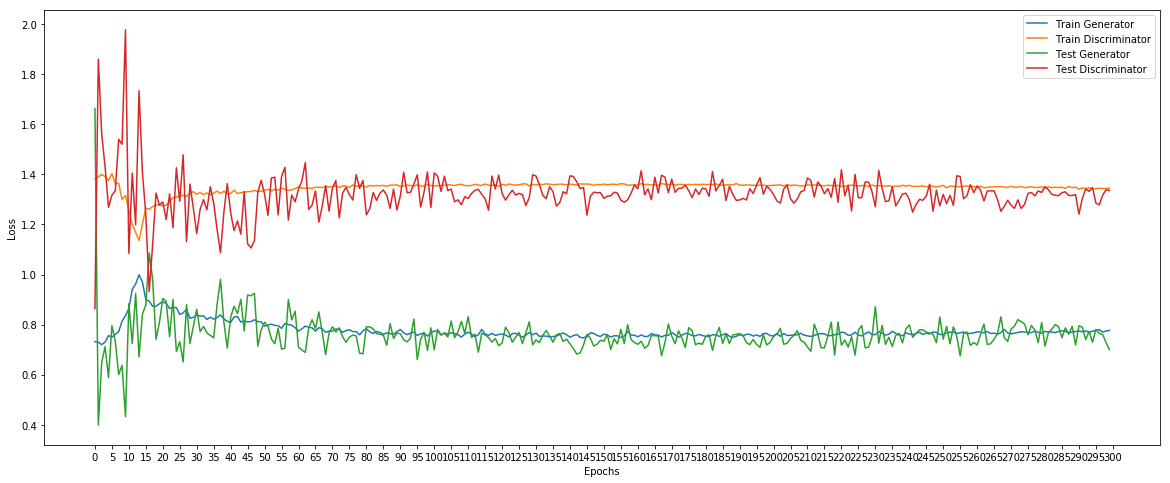

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,8))    
tr_gen, = ax.plot(train_gen_list, label='Train Generator')
tr_dsc, = ax.plot(train_dsc_list, label='Train Discriminator')
ts_gen, = ax.plot(test_gen_list, label='Test Generator')
ts_dsc, = ax.plot(test_dsc_list, label='Test Discriminator')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.xticks(np.arange(0, len(train_gen_list)+1, 5.0))

ax.legend([tr_gen, tr_dsc, ts_gen, ts_dsc], ['Train Generator','Train Discriminator', 'Test Generator', 'Test Discriminator'], loc = 'upper right')
plt.show()

### 학습 결과 출력

#### Condition 별 생성 이미지 확인

주어진 조건에 맞게 이미지가 생성되는것을 확인 할 수 있다.
이전에 Dense layer를 이용한 결과보다 더 깔끔한 결과가 나옴을 확인 할수 있다.

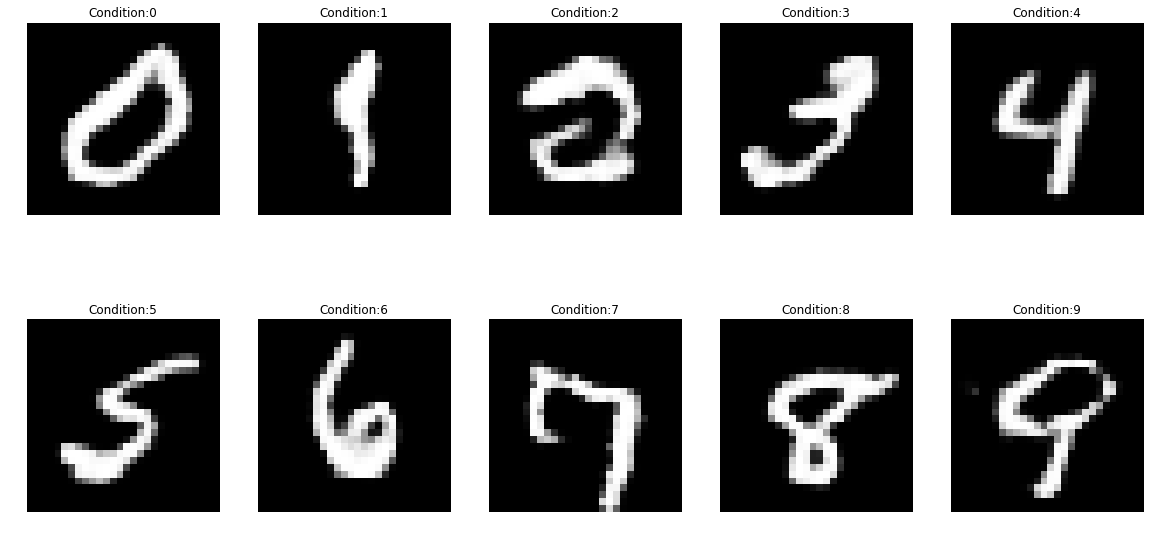

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

noises = tf.random.normal([10, 100])
condition = list(range(10))
cond_np = np.zeros([10,10]).astype(np.float32)

for i, cond in enumerate(condition):
    cond_np[i][cond] = 1.0
    
cond_tensor = tf.convert_to_tensor(cond_np, dtype=np.float32)

generated_image = convG([noises, cond_tensor])

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,0].title.set_text("Condition:"+str(condition[0]))
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[0,1].title.set_text("Condition:"+str(condition[1]))
axes[0,2].imshow(generated_image[2], cmap='gray')
axes[0,2].title.set_text("Condition:"+str(condition[2]))
axes[0,3].imshow(generated_image[3], cmap='gray')
axes[0,3].title.set_text("Condition:"+str(condition[3]))
axes[0,4].imshow(generated_image[4], cmap='gray')
axes[0,4].title.set_text("Condition:"+str(condition[4]))

axes[1,0].imshow(generated_image[5], cmap='gray')
axes[1,0].title.set_text("Condition:"+str(condition[5]))
axes[1,1].imshow(generated_image[6], cmap='gray')
axes[1,1].title.set_text("Condition:"+str(condition[6]))
axes[1,2].imshow(generated_image[7], cmap='gray')
axes[1,2].title.set_text("Condition:"+str(condition[7]))
axes[1,3].imshow(generated_image[8], cmap='gray')
axes[1,3].title.set_text("Condition:"+str(condition[8]))
axes[1,4].imshow(generated_image[9], cmap='gray')
axes[1,4].title.set_text("Condition:"+str(condition[9]))

plt.show()

#### 훈련 과정에 따른 생성 이미지

Epoch 별로 저장한 이미지를 gif로 생성하여 추가하였다.
처음에는 노이즈였던 이미지가 점차 숫자의 모습을 갖추는 것을 확인 할 수 있다.
Loss graph 에서 나타듯이 Dense layer에 비해서 학습하는 속도가 빠름을 확인 할 수 있다.

In [0]:
anim_file = 'convcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image_conv*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 5*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


![alt text](https://i.imgur.com/CMsiwOV.gif)